## Guardians of the Crypto
### A Streamlit Application for Enhanced Price Prediction and Informed Decision-Making
###### by Mirna Philip, Justin Farnan, and Arya Shahbazi

###### The cryptocurrency market is very unpredictable, with prices changing a lot in a short time, making it hard for investors and traders to make good decisions. Our project, Guardians of the Crypto, aims to solve this problem by using past price data to predict changes in cryptocurrency prices. By focusing on this method, we want to create a reliable tool that helps traders and investors understand the market better and make confident decisions. Our main goals are to collect past price data for major cryptocurrencies using the Coinbase API. We will clean and prepare this data and train different machine learning models, including simple models like Linear Regression and advanced ones like Long Short-Term Memory (LSTM) networks, to predict cryptocurrency price changes accurately. We will evaluate these models, improve the best one, and develop a Streamlit application that uses past price data and other trading metrics to help cryptocurrency traders and investors make better decisions in a volatile market.

In [2]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pytz
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objects as go
from ipywidgets import interact, Dropdown
from plotly.subplots import make_subplots
import matplotlib.ticker as ticker
import statsmodels.api as sm
import matplotlib.dates as mdates
import plotly.express as px
#import shap
# from historic_api_pulls.extract_coinbase import combine_price_data, previous_week

In [3]:
# Configuration to suppress warnings
warnings.filterwarnings('ignore')

# Additional configurations for better control over visualizations (optional)
plt.style.use('ggplot')  # For ggplot-like style in plots
pd.options.display.max_columns = None  # Ensure all columns are visible when displaying DataFrames

## Loading the Database

In [4]:
filePath = 'RAW_Data/train_historic_updt_717.csv'
# Loading the CSV file
data = pd.read_csv(filePath)

# Display the first few rows of the dataframe
print("First few rows of the dataset:")
data.head(2)

First few rows of the dataset:


Unnamed: 0        time       low      high     open     close  \
0           0  2021-07-19    0.7286    0.8003    0.794    0.7337   
1           1  2021-07-19  334.8700  379.8900  379.200  340.3900   

         volume  price_change  average_price  volatility product_id  \
0  4.540856e+07       -0.0603        0.76445    9.840791  MATIC-USD   
1  2.913119e+04      -38.8100      357.38000   13.444023   COMP-USD   

      load_dt  
0  2024-07-17  
1  2024-07-17

#### Data Inspection and Understanding

In [5]:
def print_dataframe_shape(df, name):
    rows, columns = df.shape
    print(f"{name} database has {rows} rows and {columns} columns.")
    print(f"Names of the columns are: \n", df.columns.tolist())

print_dataframe_shape(data, "Cryptocurrency")

Cryptocurrency database has 10853 rows and 12 columns.
Names of the columns are: 
 ['Unnamed: 0', 'time', 'low', 'high', 'open', 'close', 'volume', 'price_change', 'average_price', 'volatility', 'product_id', 'load_dt']


In [6]:
data['product_id'].value_counts()

product_id
MATIC-USD    1093
COMP-USD     1093
ETH-USD      1093
SOL-USD      1093
BTC-USD      1093
LTC-USD      1093
UNI-USD      1093
ADA-USD      1093
LINK-USD     1093
AVAX-USD     1016
Name: count, dtype: int64

In [7]:
def separateCryptoData(data):
    cryptoDfs = {}
    unique_product_ids = data['product_id'].unique()
    
    for product_id in unique_product_ids:
        cryptoDfs[product_id] = data[data['product_id'] == product_id]
    
    return cryptoDfs

# Example usage
cryptoDfs = separateCryptoData(data)

# Access individual DataFrames
SOLdf = cryptoDfs.get('SOL-USD')
BTCdf = cryptoDfs.get('BTC-USD')
ETHdf = cryptoDfs.get('ETH-USD') 
ADAdf = cryptoDfs.get('ADA-USD')
LINKdf = cryptoDfs.get('LINK-USD')
LTCdf = cryptoDfs.get('LTC-USD')
COMPdf = cryptoDfs.get('COMP-USD')
UNIdf = cryptoDfs.get('UNI-USD')
MATICdf = cryptoDfs.get('MATIC-USD')
AVAXdf = cryptoDfs.get('AVAX-USD')

In [8]:
# Display basic information about the dataframe
def basicInformation(name, cryptoDfs):
    print(f"\nBasic information about the {name}:")
    cryptoDfs.info()
    print("\n" + "="*50 + "\n")
    
cryptos_info = {
    'SOL': SOLdf,
    'BTC': BTCdf,
    'ETH': ETHdf,
    'ADA': ADAdf,
    'LINK': LINKdf,
    'LTC': LTCdf,
    'COMP': COMPdf,
    'UNI': UNIdf,
    'MATIC': MATICdf,
    'AVAX': AVAXdf
}

for name, df in cryptos_info.items():
    basicInformation(name, df)


Basic information about the SOL:
<class 'pandas.core.frame.DataFrame'>
Index: 1093 entries, 3 to 10828
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1093 non-null   int64  
 1   time           1093 non-null   object 
 2   low            1093 non-null   float64
 3   high           1093 non-null   float64
 4   open           1093 non-null   float64
 5   close          1093 non-null   float64
 6   volume         1093 non-null   float64
 7   price_change   1093 non-null   float64
 8   average_price  1093 non-null   float64
 9   volatility     1093 non-null   float64
 10  product_id     1093 non-null   object 
 11  load_dt        1089 non-null   object 
dtypes: float64(8), int64(1), object(3)
memory usage: 111.0+ KB



Basic information about the BTC:
<class 'pandas.core.frame.DataFrame'>
Index: 1093 entries, 4 to 10820
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  


In [9]:
# Display summary statistics for the numerical columns
def summaryStatistics(name, cryptoData):
    print(f"\nSummary statistics for the {name}:")
    print(cryptoData.describe())
    print("\n" + "="*50 + "\n")
    
for name, df in cryptos_info.items():
    summaryStatistics(name, df)


Summary statistics for the SOL:
         Unnamed: 0          low         high         open        close  \
count   1093.000000  1093.000000  1093.000000  1093.000000  1093.000000   
mean    5394.172919    72.807522    79.600661    76.212259    76.311115   
std     3152.642382    58.779788    64.227330    61.666002    61.675614   
min        3.000000     8.000000    10.080000     9.640000     9.640000   
25%     2661.000000    22.490000    24.150000    23.260000    23.270000   
50%     5389.000000    40.702000    44.963000    42.940000    43.090000   
75%     8124.000000   120.080000   134.980000   127.520000   127.830000   
max    10828.000000   245.800000   260.000000   258.764000   258.763000   

             volume  price_change  average_price   volatility  
count  1.093000e+03   1093.000000    1093.000000  1093.000000  
mean   1.718028e+06      0.098856      76.204091     9.204767  
std    1.449443e+06      5.262758      61.460170     6.614862  
min    1.876976e+05    -26.140000  

In [10]:
# Check for missing values
def checkMissingValues(name, cryptoData):
    print(f"\nMissing values in the {name}:")
    print(cryptoData.isnull().sum())
    print("\n" + "="*50 + "\n")

for name, df in cryptos_info.items():
    checkMissingValues(name, df)


Missing values in the SOL:
Unnamed: 0       0
time             0
low              0
high             0
open             0
close            0
volume           0
price_change     0
average_price    0
volatility       0
product_id       0
load_dt          4
dtype: int64



Missing values in the BTC:
Unnamed: 0       0
time             0
low              0
high             0
open             0
close            0
volume           0
price_change     0
average_price    0
volatility       0
product_id       0
load_dt          4
dtype: int64



Missing values in the ETH:
Unnamed: 0       0
time             0
low              0
high             0
open             0
close            0
volume           0
price_change     0
average_price    0
volatility       0
product_id       0
load_dt          4
dtype: int64



Missing values in the ADA:
Unnamed: 0       0
time             0
low              0
high             0
open             0
close            0
volume           0
price_change     0
average

In [11]:
def checkDuplicateValues(name, cryptoData):
    print(f"\nDuplicate values in the {name}:")
    print(cryptoData.duplicated().sum())
    print("\n" + "="*50 + "\n")

for name, df in cryptos_info.items():
    checkDuplicateValues(name, df)


Duplicate values in the SOL:
0



Duplicate values in the BTC:
0



Duplicate values in the ETH:
0



Duplicate values in the ADA:
0



Duplicate values in the LINK:
0



Duplicate values in the LTC:
0



Duplicate values in the COMP:
0



Duplicate values in the UNI:
0



Duplicate values in the MATIC:
0



Duplicate values in the AVAX:
0




## Exploratory Data Analysis (EDA)

In [12]:
# Remove the 'Unnamed: 0' column and other columns as it's redundant
data.drop(columns=['Unnamed: 0','load_dt'], inplace=True)

# Convert 'time' column to datetime format
data['time'] = pd.to_datetime(data['time'])

# Sort the DataFrame by the 'time' column
data.sort_values(by='time', ascending=True, inplace=True)

# Set 'time' as the index of the DataFrame
data.set_index('time', inplace=True)

# Calculate daily percentage change in 'close' price
#df['pct_change'] = df['close'].pct_change() # Keeping it in decimal format for more accurate results
# Group the DataFrame by 'product_id' and then apply the percentage change to the 'close' column
data['pct_change'] = data.groupby('product_id')['close'].pct_change()

# Display the first few rows of the updated DataFrame
data.head()


# Print the updated DataFrame to verify changes
print("Updated DataFrame with Daily Frequency and Interpolated Values:")
print(data.head())

# Review unique counts of product IDs if necessary
print("\nCount of unique product IDs:")
print(data['product_id'].value_counts())

Updated DataFrame with Daily Frequency and Interpolated Values:
                   low         high        open        close        volume  \
time                                                                         
2021-07-17     15.0000     15.68336     15.2400     15.35974  1.919231e+06   
2021-07-17      0.7832      0.82180      0.8115      0.80210  3.840267e+07   
2021-07-17  31179.0100  31949.99000  31389.5700  31533.91000  5.695574e+03   
2021-07-17      1.1503      1.19540      1.1714      1.17300  3.048600e+07   
2021-07-17    117.7300    122.95000    120.7100    120.02000  1.088085e+05   

            price_change  average_price  volatility product_id  pct_change  
time                                                                        
2021-07-17       0.11974       15.34168    4.555733   LINK-USD         NaN  
2021-07-17      -0.00940        0.80250    4.928498  MATIC-USD         NaN  
2021-07-17     144.34000    31564.50000    2.472753    BTC-USD         NaN  
2021

In [13]:
data.isnull().sum()

low               0
high              0
open              0
close             0
volume            0
price_change      0
average_price     0
volatility        0
product_id        0
pct_change       10
dtype: int64

In [14]:
# Calculate the percentage change per each coin separately
data['pct_change'] = data.groupby('product_id')['close'].pct_change() * 100

# Compute the average percentage change for each coin
avg_pct_change = data.groupby('product_id')['pct_change'].transform(lambda x: x.fillna(x.mean()))

# Fill NaN values with the average percentage change per coin
data['pct_change'] = data['pct_change'].fillna(avg_pct_change)

# Check the updated DataFrame
print(data)

                   low         high        open        close        volume  \
time                                                                         
2021-07-17     15.0000     15.68336     15.2400     15.35974  1.919231e+06   
2021-07-17      0.7832      0.82180      0.8115      0.80210  3.840267e+07   
2021-07-17  31179.0100  31949.99000  31389.5700  31533.91000  5.695574e+03   
2021-07-17      1.1503      1.19540      1.1714      1.17300  3.048600e+07   
2021-07-17    117.7300    122.95000    120.7100    120.02000  1.088085e+05   
...                ...          ...         ...          ...           ...   
2024-07-11      7.7600      8.18200      8.0230      7.83100  4.183063e+05   
2024-07-11      0.3845      0.40500      0.3887      0.39610  1.928626e+07   
2024-07-11     66.4400     69.15000     66.9600     67.37000  1.479559e+05   
2024-07-11     25.0200     26.37000     25.7500     25.21000  4.112866e+05   
2024-07-11    135.6800    146.00000    141.9800    135.70000  8.

In [15]:
def separateCryptoData(data):
    cryptoDfs = {}
    unique_product_ids = data['product_id'].unique()
    
    for product_id in unique_product_ids:
        cryptoDfs[product_id] = data[data['product_id'] == product_id]
    
    return cryptoDfs

# Example usage
cryptoDfs = separateCryptoData(data)

# Access individual DataFrames
SOLdf = cryptoDfs.get('SOL-USD')
BTCdf = cryptoDfs.get('BTC-USD')
ETHdf = cryptoDfs.get('ETH-USD') 
ADAdf = cryptoDfs.get('ADA-USD')
LINKdf = cryptoDfs.get('LINK-USD')
LTCdf = cryptoDfs.get('LTC-USD')
COMPdf = cryptoDfs.get('COMP-USD')
UNIdf = cryptoDfs.get('UNI-USD')
MATICdf = cryptoDfs.get('MATIC-USD')
AVAXdf = cryptoDfs.get('AVAX-USD')

In [16]:
# Display basic information about the dataframe
def basicInformation(name, cryptoDfs):
    print(f"\nBasic information about the {name}:")
    cryptoDfs.info()
    print("\n" + "="*50 + "\n")
    
cryptos_info = {
    'SOL': SOLdf,
    'BTC': BTCdf,
    'ETH': ETHdf,
    'ADA': ADAdf,
    'LINK': LINKdf,
    'LTC': LTCdf,
    'COMP': COMPdf,
    'UNI': UNIdf,
    'MATIC': MATICdf,
    'AVAX': AVAXdf
}

for name, df in cryptos_info.items():
    basicInformation(name, df)


Basic information about the SOL:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1093 entries, 2021-07-17 to 2024-07-11
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   low            1093 non-null   float64
 1   high           1093 non-null   float64
 2   open           1093 non-null   float64
 3   close          1093 non-null   float64
 4   volume         1093 non-null   float64
 5   price_change   1093 non-null   float64
 6   average_price  1093 non-null   float64
 7   volatility     1093 non-null   float64
 8   product_id     1093 non-null   object 
 9   pct_change     1093 non-null   float64
dtypes: float64(9), object(1)
memory usage: 93.9+ KB



Basic information about the BTC:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1093 entries, 2021-07-17 to 2024-07-11
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   low   

In [17]:
# Descriptive Statistics
def descriptiveStatistics(name, cryptoData):
    print(f"\nDescriptive statistics for the {name}:")
    print(cryptoData.describe())
    print("\n" + "="*50 + "\n")

for name, data in cryptos_info.items():
    descriptiveStatistics(name, data)


Descriptive statistics for the SOL:
               low         high         open        close        volume  \
count  1093.000000  1093.000000  1093.000000  1093.000000  1.093000e+03   
mean     72.807522    79.600661    76.212259    76.311115  1.718028e+06   
std      58.779788    64.227330    61.666002    61.675614  1.449443e+06   
min       8.000000    10.080000     9.640000     9.640000  1.876976e+05   
25%      22.490000    24.150000    23.260000    23.270000  8.534432e+05   
50%      40.702000    44.963000    42.940000    43.090000  1.339784e+06   
75%     120.080000   134.980000   127.520000   127.830000  2.082816e+06   
max     245.800000   260.000000   258.764000   258.763000  1.582611e+07   

       price_change  average_price   volatility   pct_change  
count   1093.000000    1093.000000  1093.000000  1093.000000  
mean       0.098856      76.204091     9.204767     0.310595  
std        5.262758      61.460170     6.614862     5.676798  
min      -26.140000       9.445000 

In [18]:
# Identify numeric columns for statistical analysis
numeric_cols = data.select_dtypes(include=[np.number])  # This selects all the columns that are of numeric type

# Group by 'product_id' and calculate basic statistics for numeric columns
grouped_stats = data.groupby('product_id')[numeric_cols.columns].agg(['mean', 'std', 'min', 'max'])

# Calculate skewness and kurtosis separately using apply() for compatibility
skewness = data.groupby('product_id')[numeric_cols.columns].apply(lambda x: x.skew()).rename(columns=lambda x: x + '_skew')
kurtosis = data.groupby('product_id')[numeric_cols.columns].apply(lambda x: x.kurt()).rename(columns=lambda x: x + '_kurtosis')

# Concatenate the skewness and kurtosis DataFrames to the grouped_stats DataFrame
detailed_stats = pd.concat([grouped_stats, skewness, kurtosis], axis=1)

print("\nDetailed Summary Statistics by Cryptocurrency:")
print(detailed_stats)


Detailed Summary Statistics by Cryptocurrency:
            (low, mean)  (low, std)  (low, min)  (low, max)  (high, mean)  \
product_id                                                                  
AVAX-USD      34.040689   26.709943        8.62      126.25     37.301407   

            (high, std)  (high, min)  (high, max)  (open, mean)  (open, std)  \
product_id                                                                     
AVAX-USD      29.814001         8.92        147.5     35.685709    28.226677   

            (open, min)  (open, max)  (close, mean)  (close, std)  \
product_id                                                          
AVAX-USD           8.78       135.21      35.642835     28.209774   

            (close, min)  (close, max)  (volume, mean)  (volume, std)  \
product_id                                                              
AVAX-USD            8.79        135.29   976037.655243  814449.444941   

            (volume, min)  (volume, max)  (price_ch

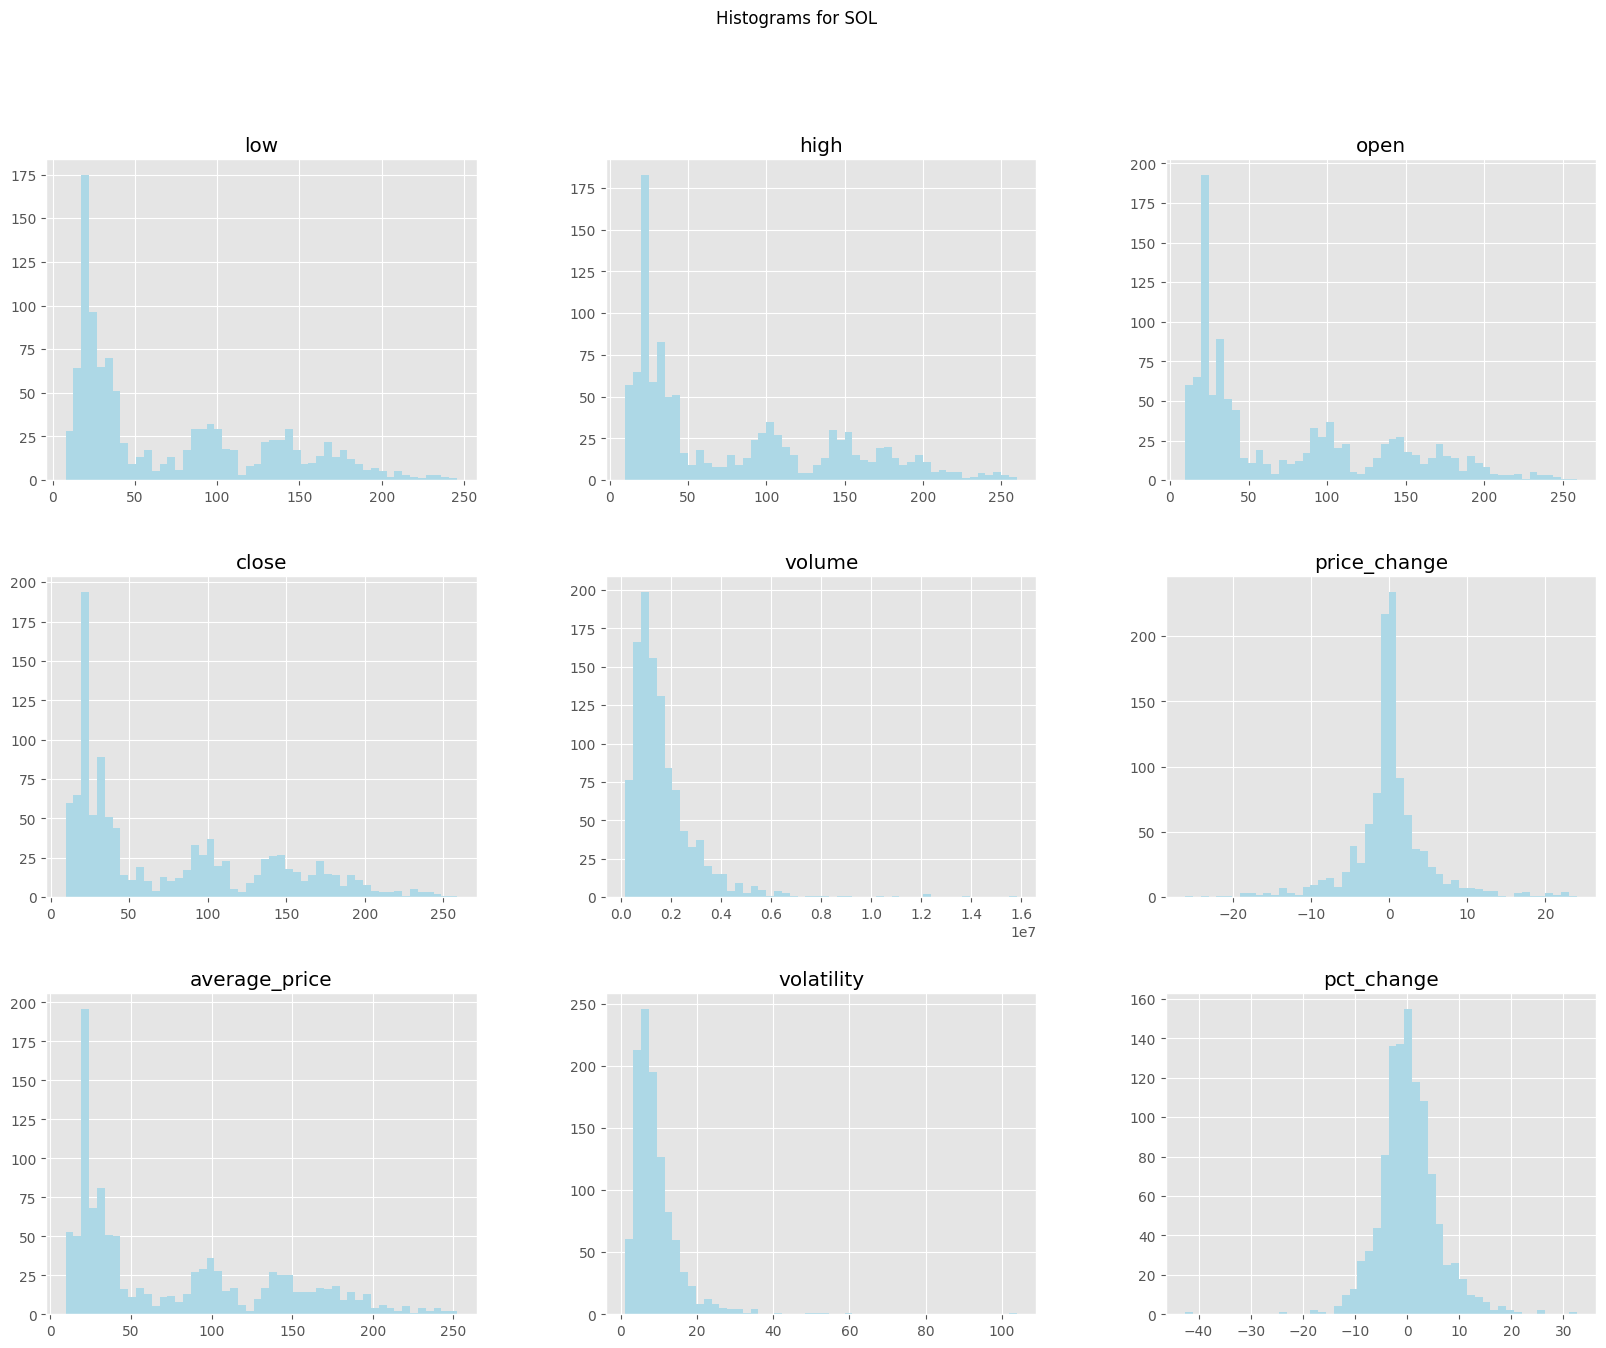

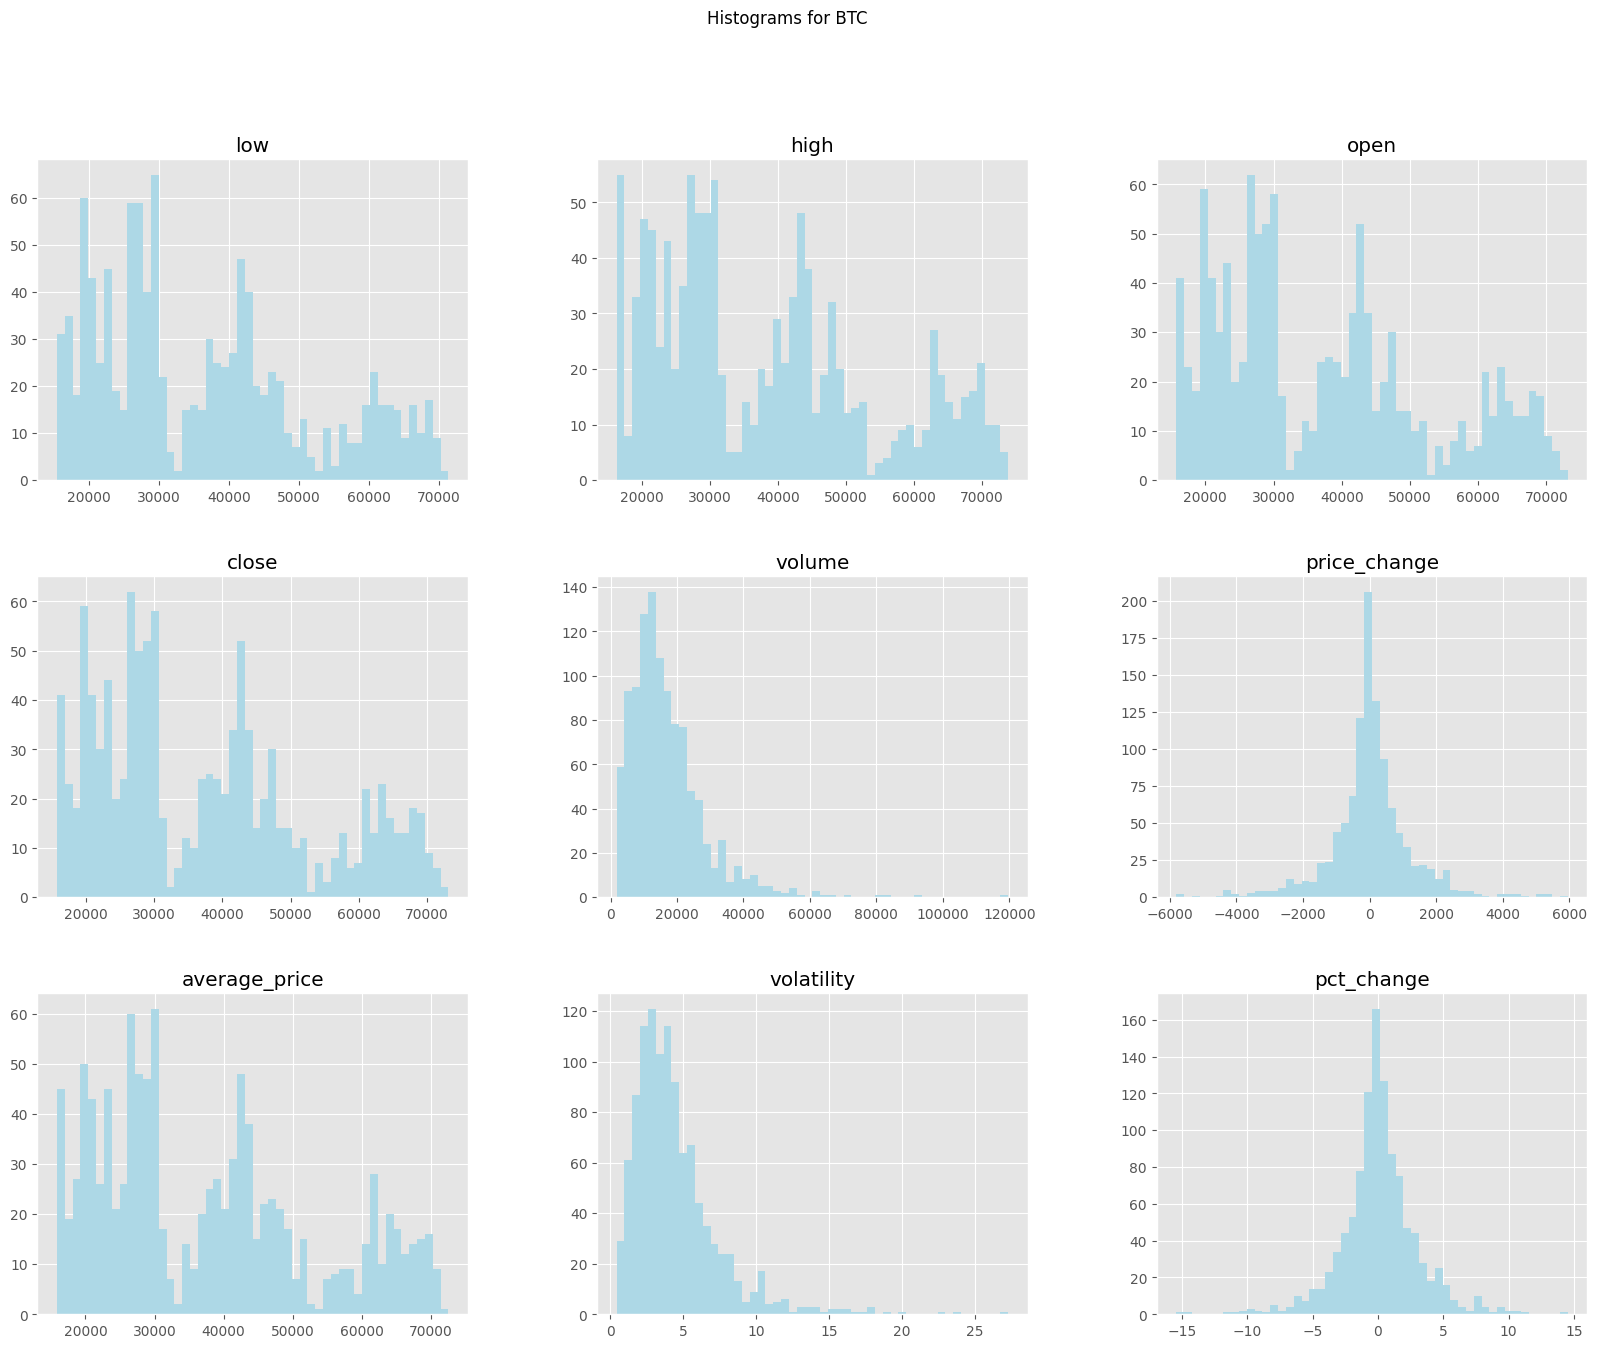

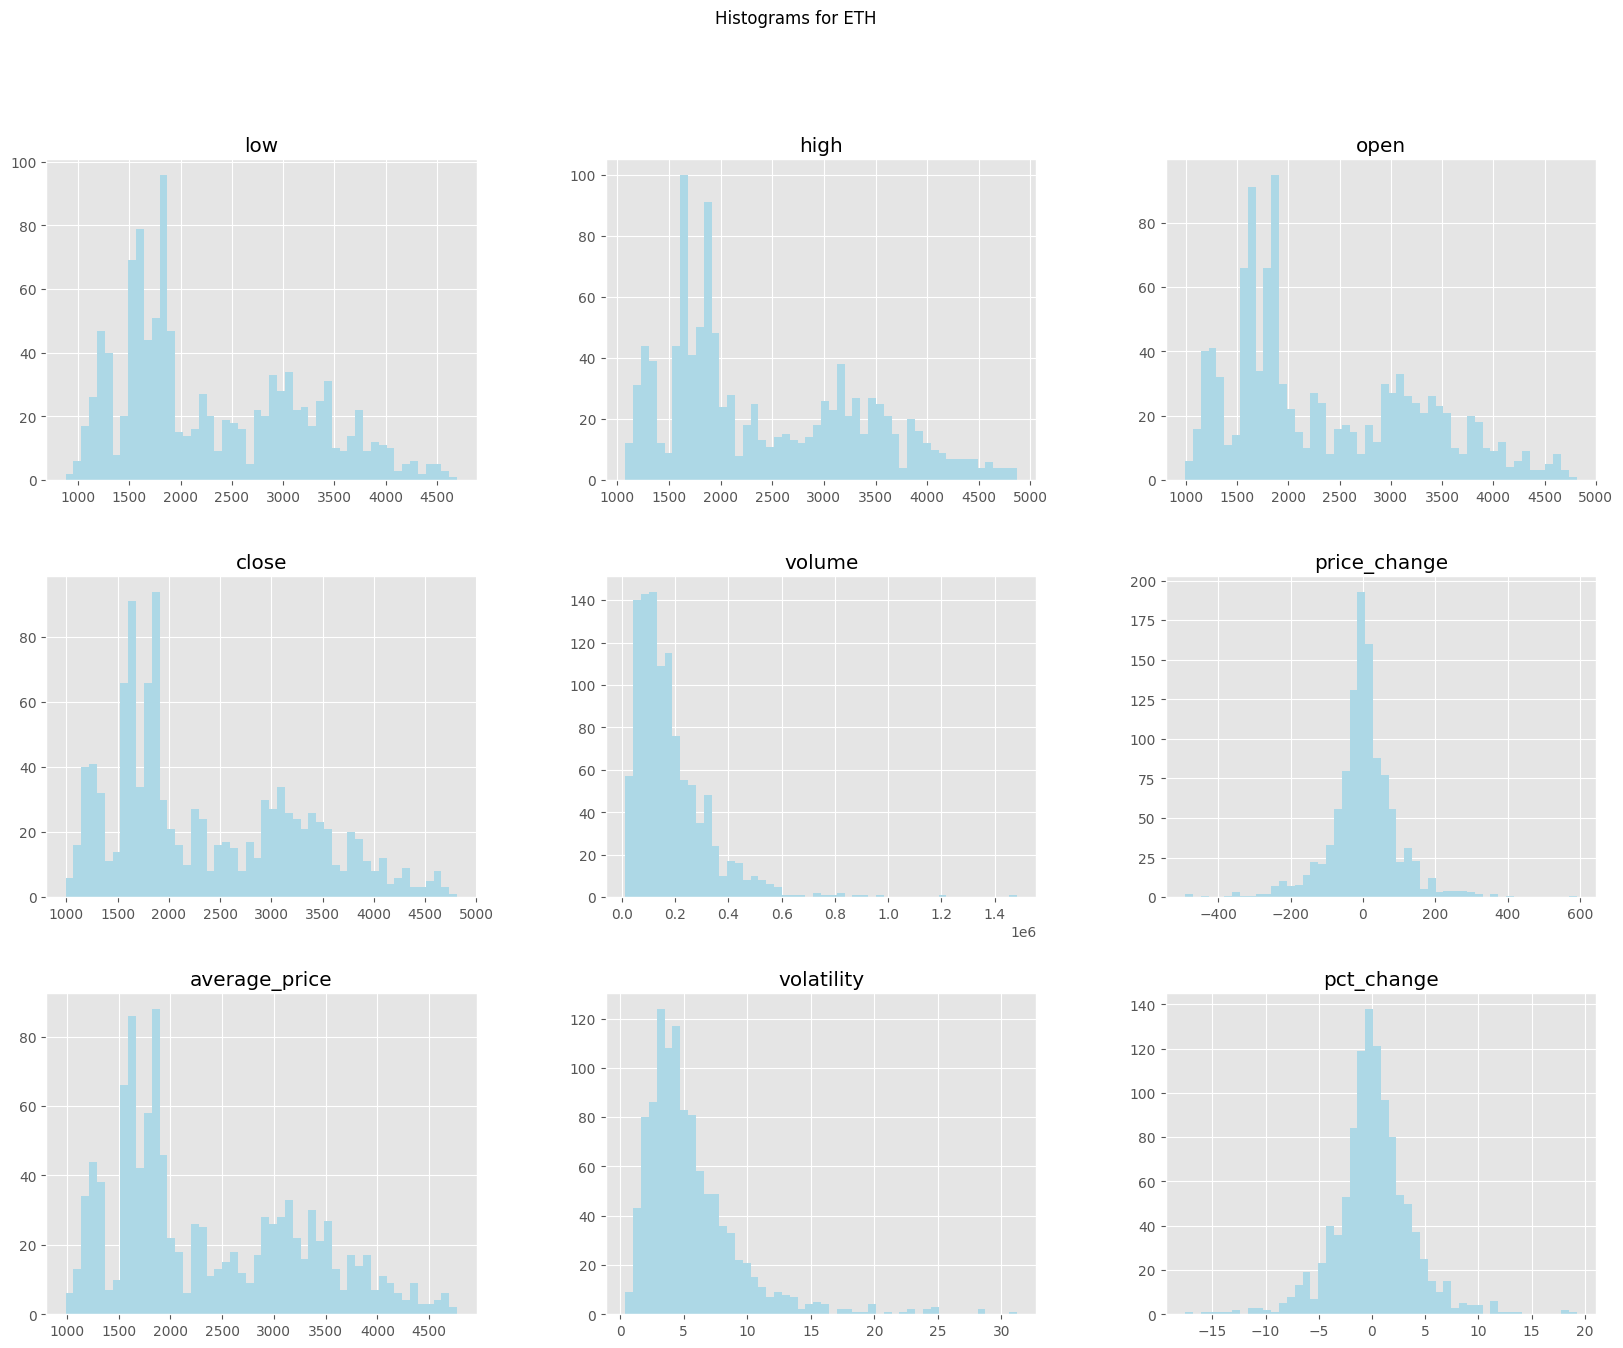

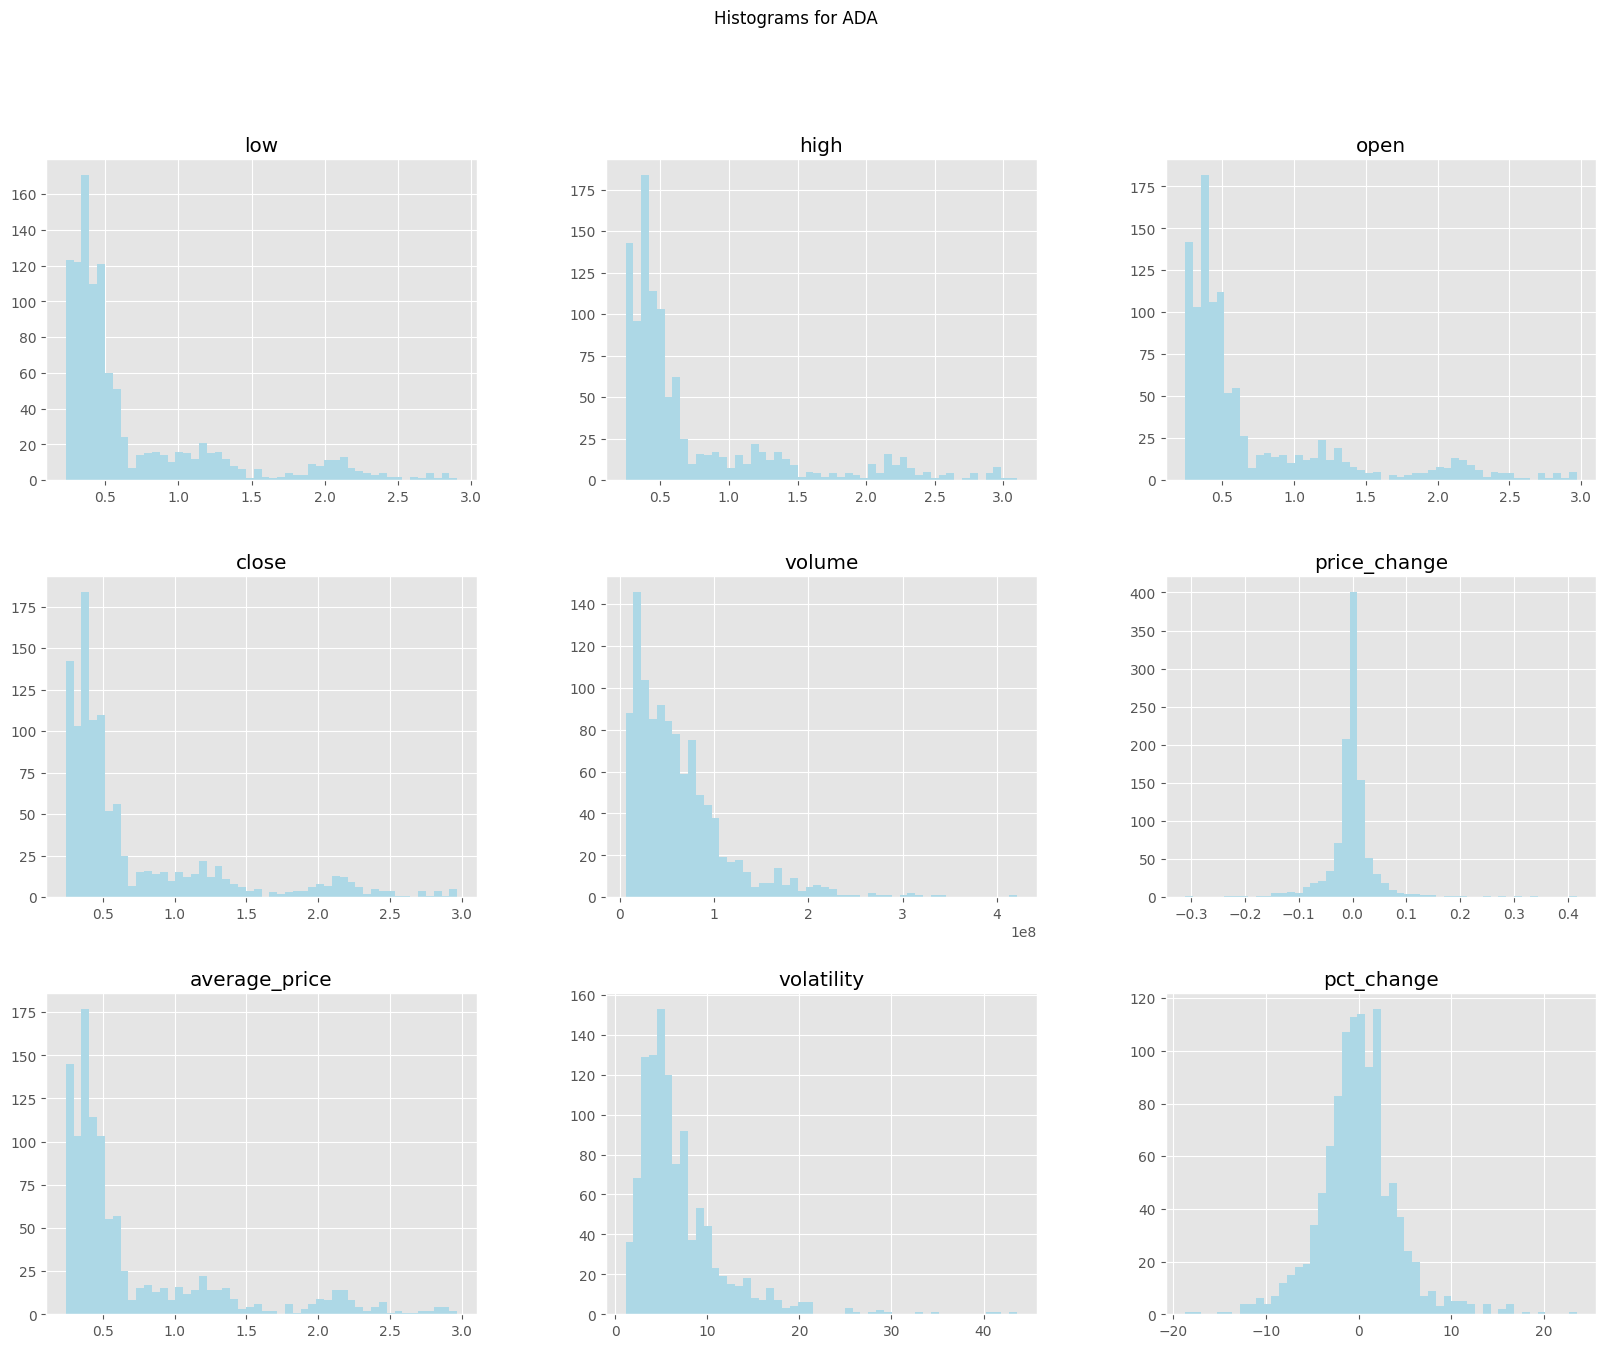

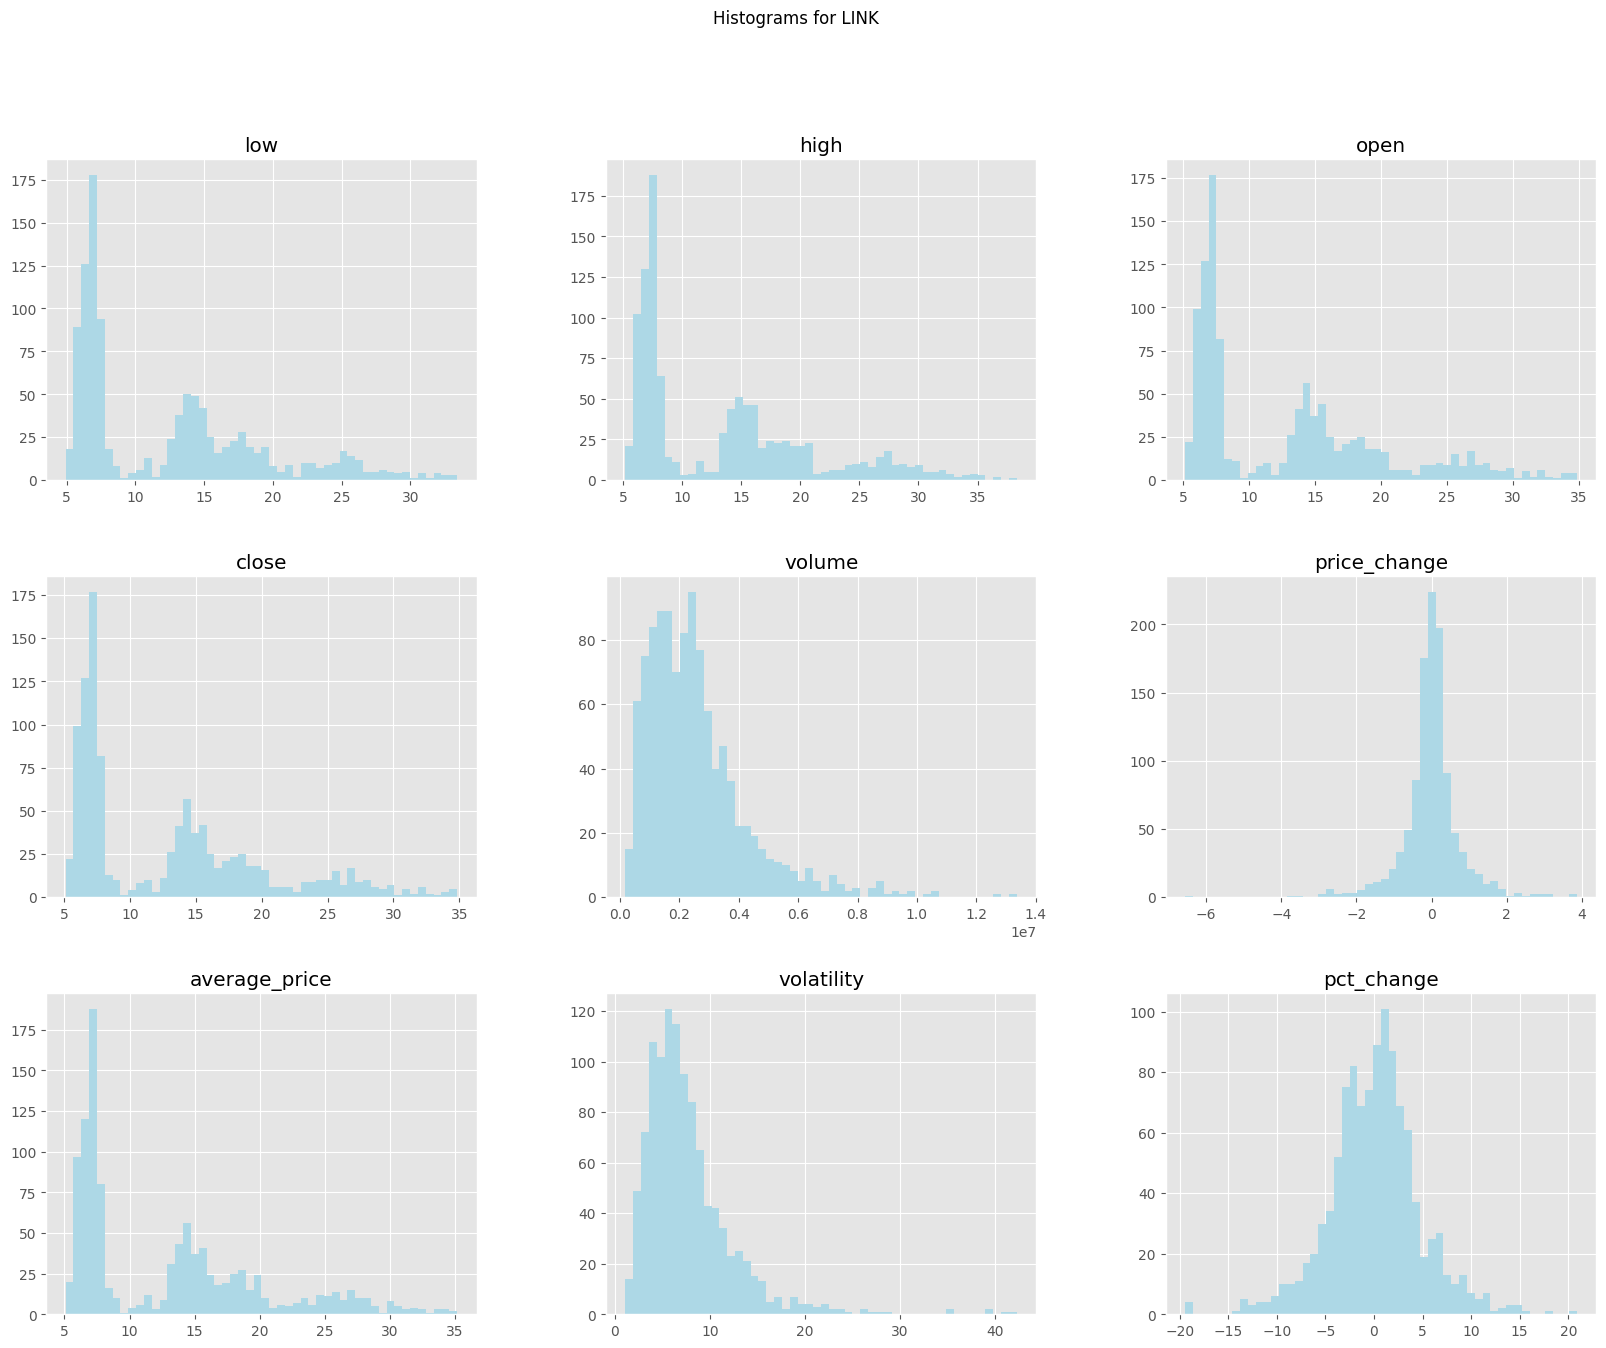

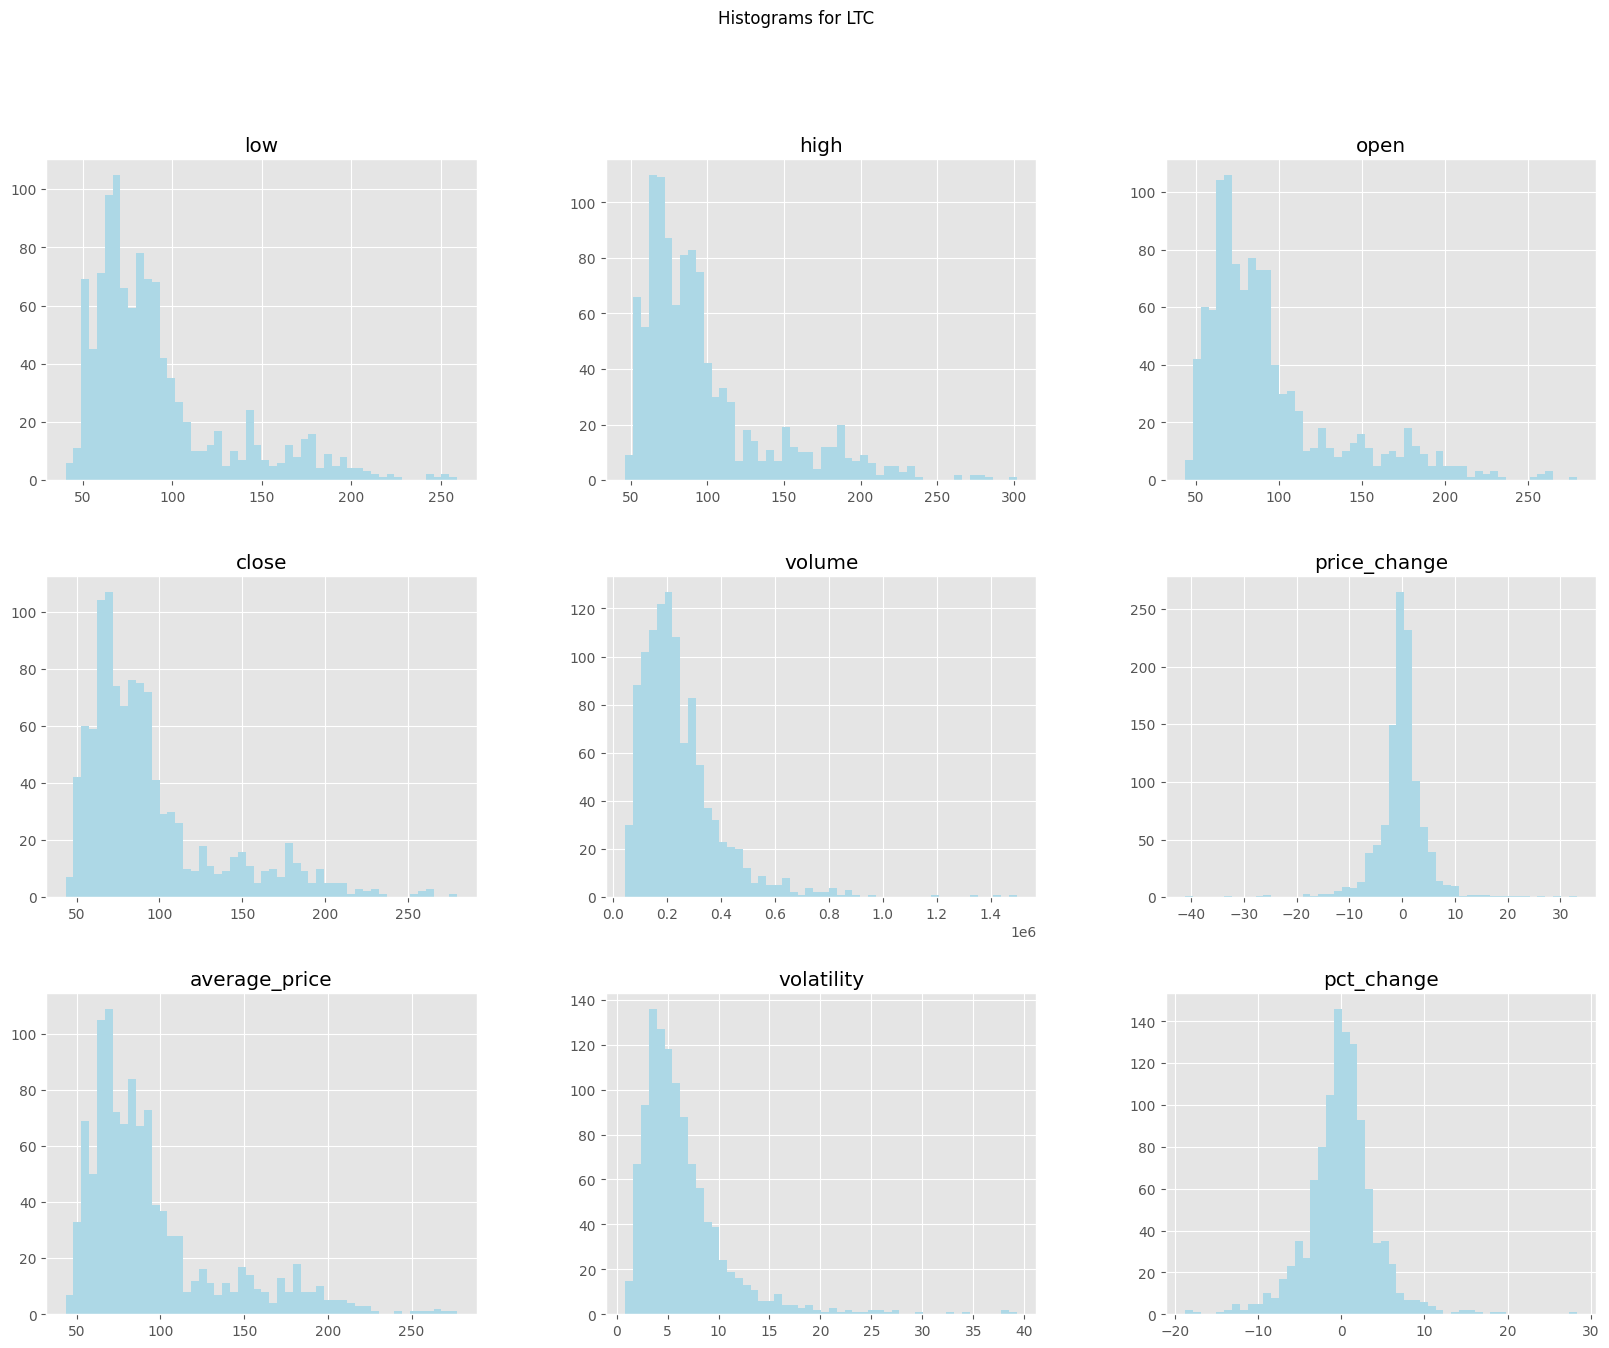

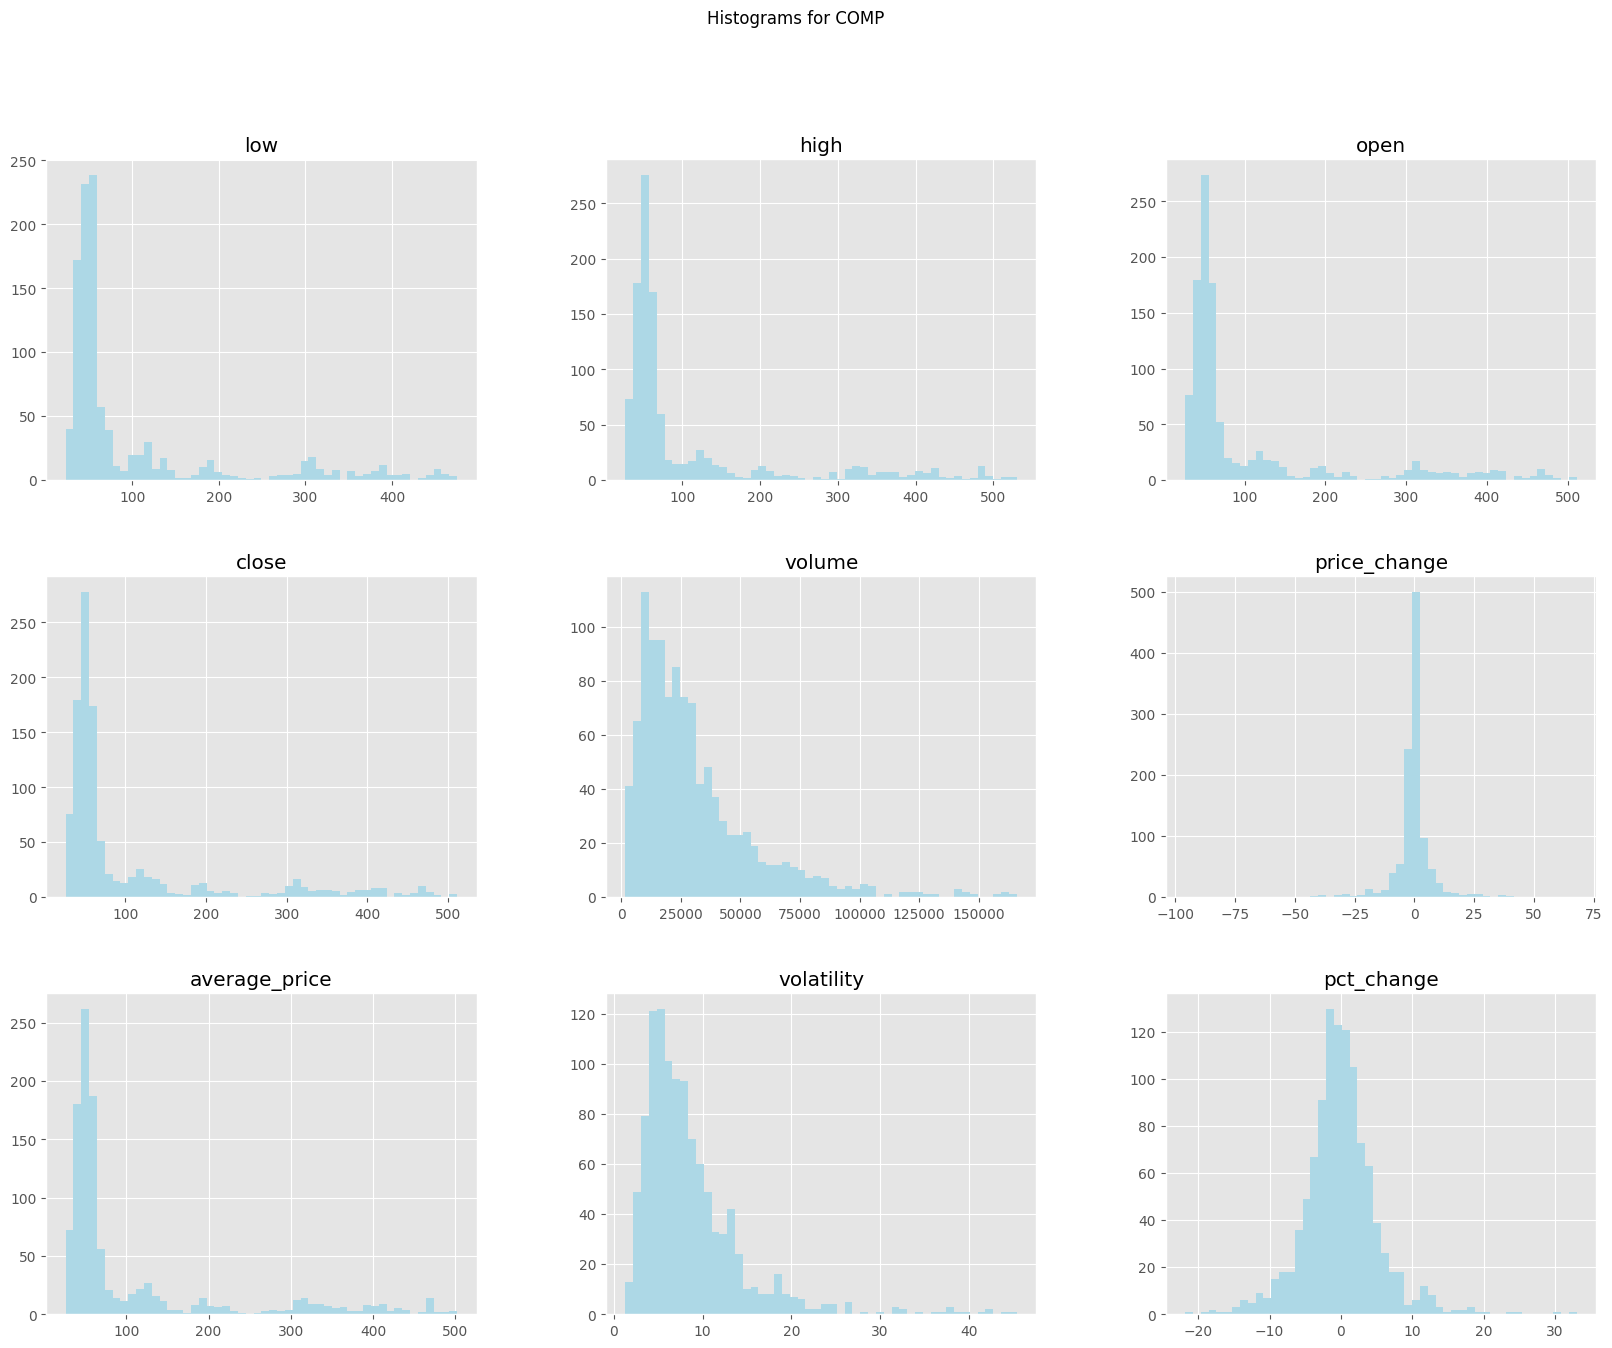

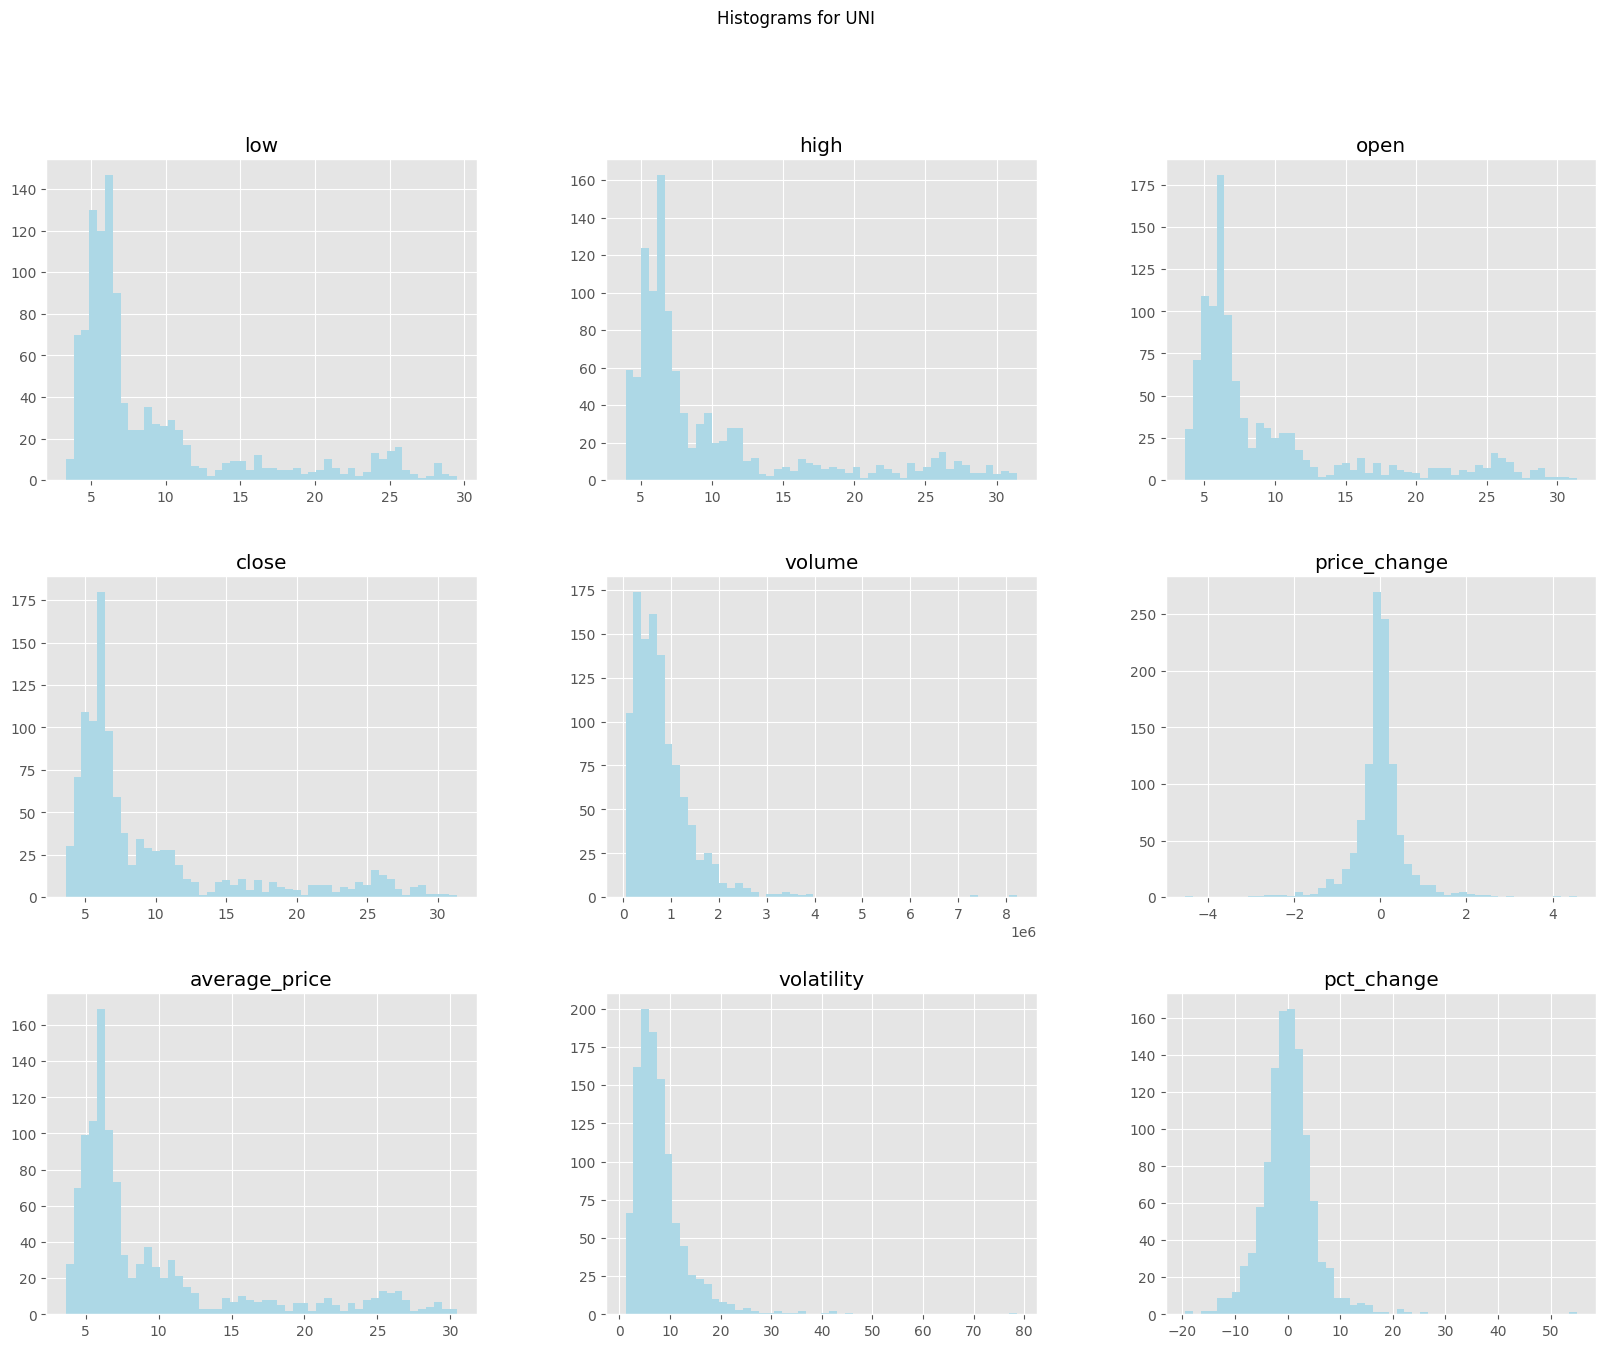

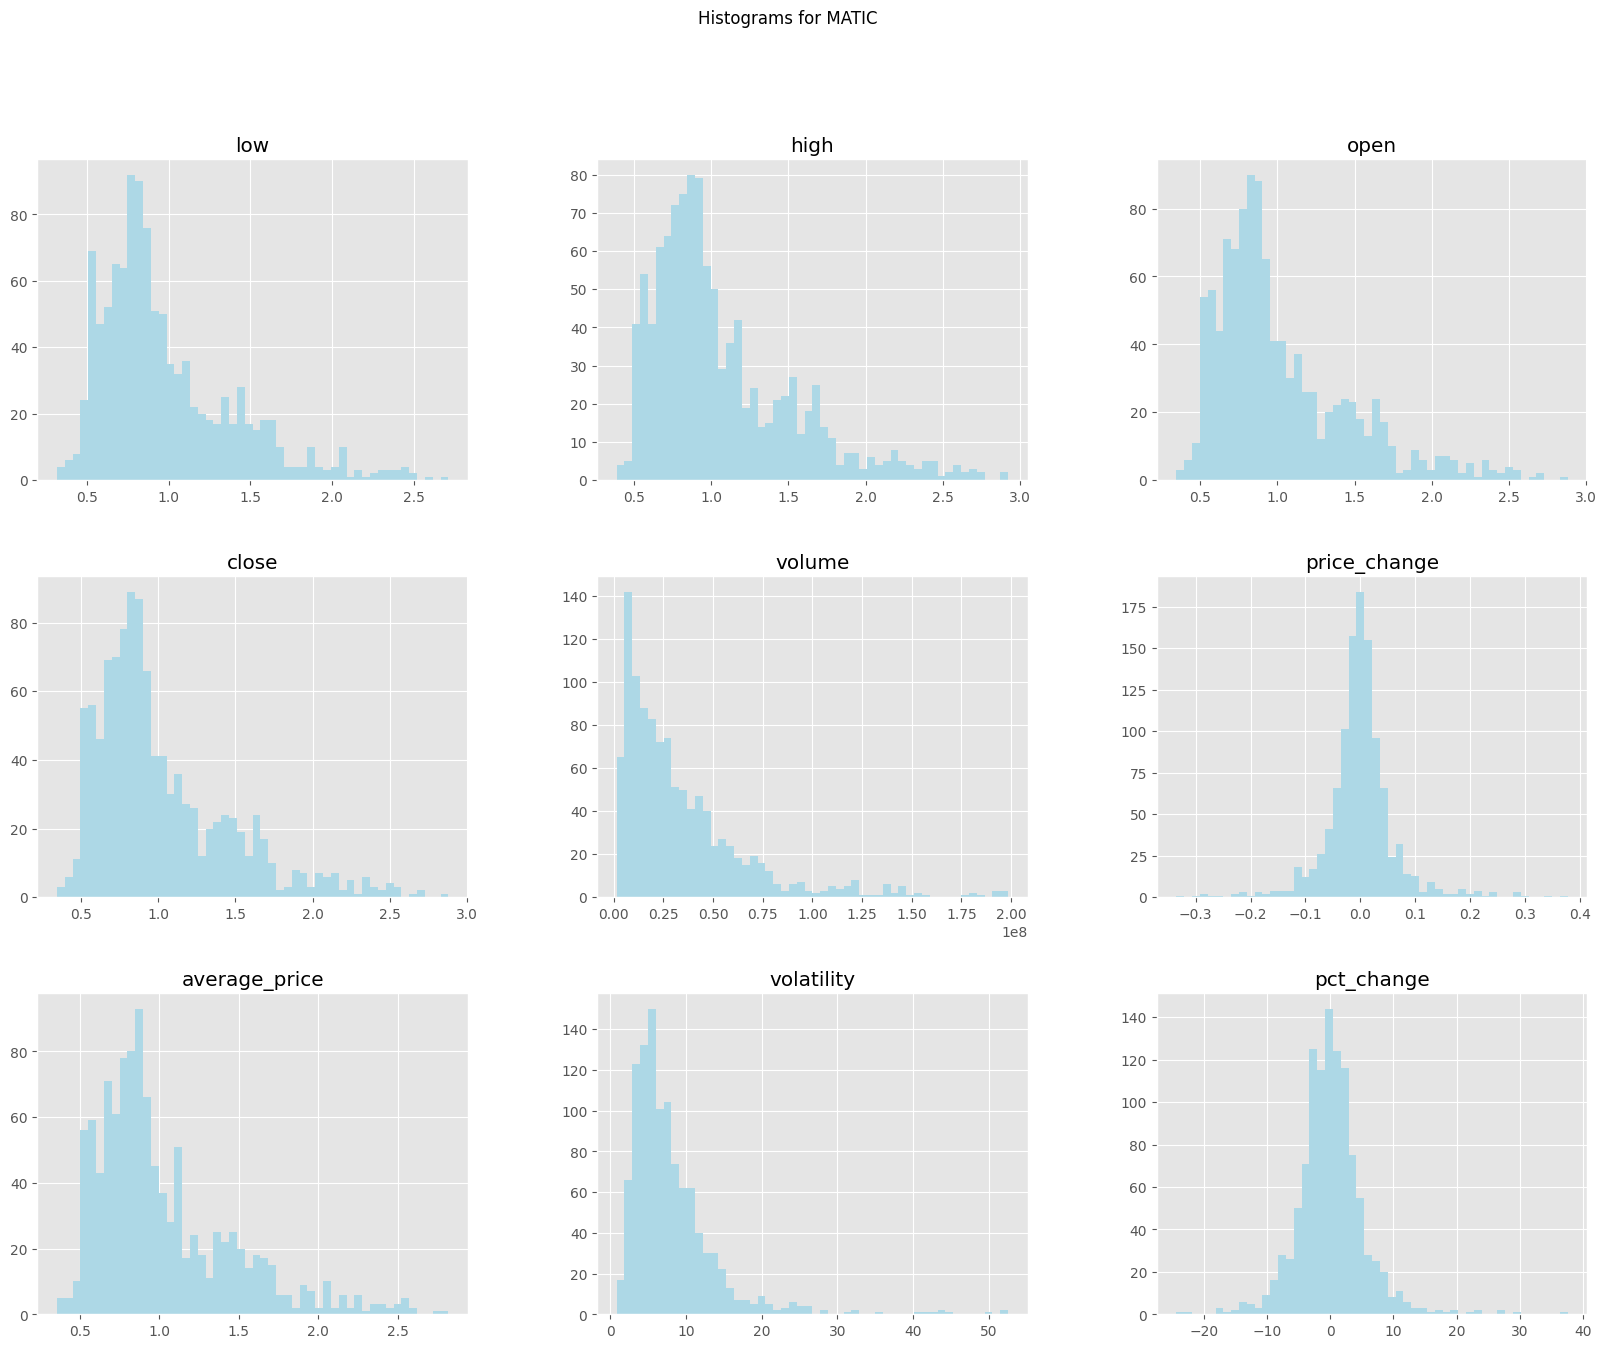

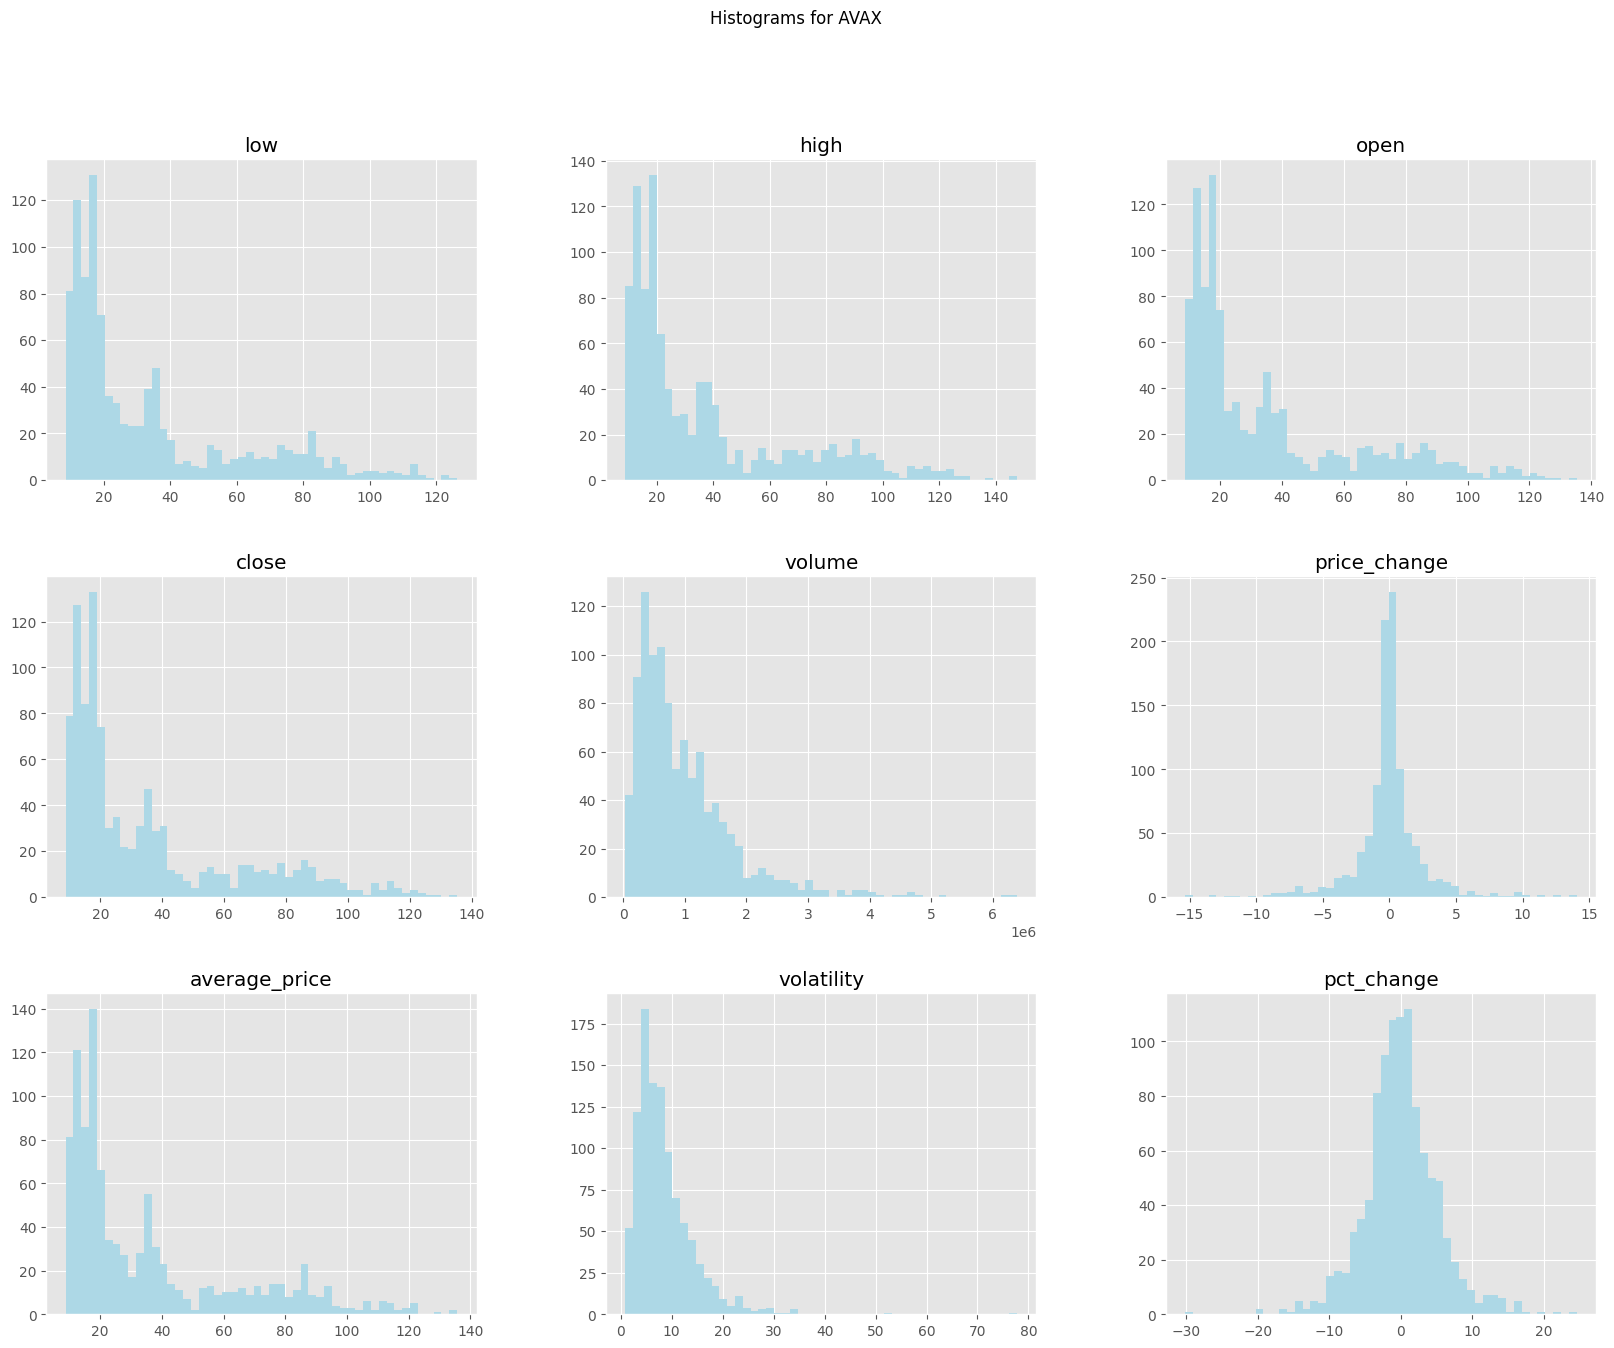

In [19]:
def plotHistograms(name, cryptoData):
    cryptoData.hist(bins=50, figsize=(20, 15), color="lightblue")
    plt.suptitle(f'Histograms for {name}')
    plt.show()

for name, df in cryptos_info.items():
    plotHistograms(name, df)

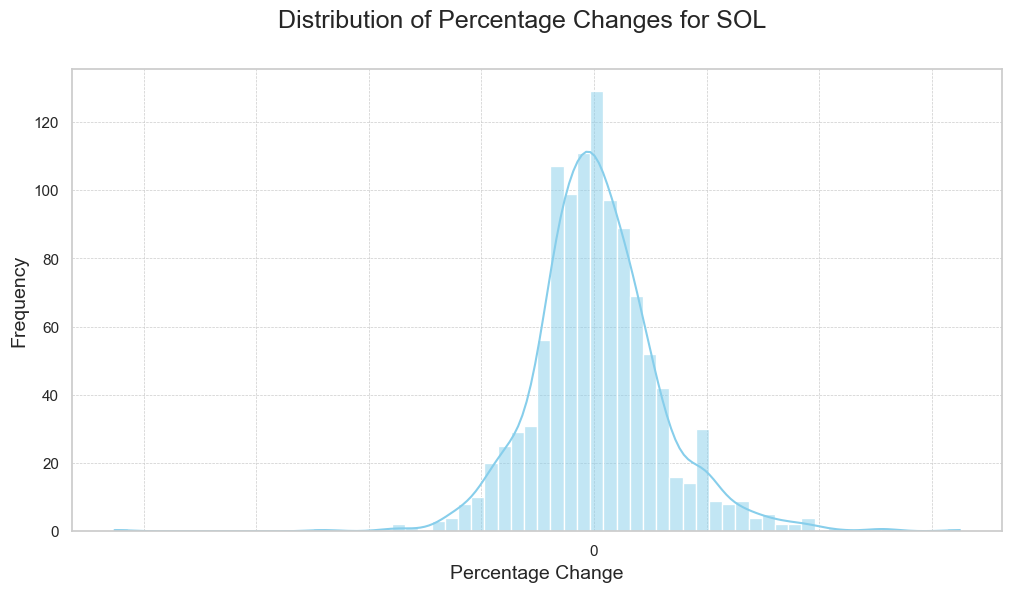

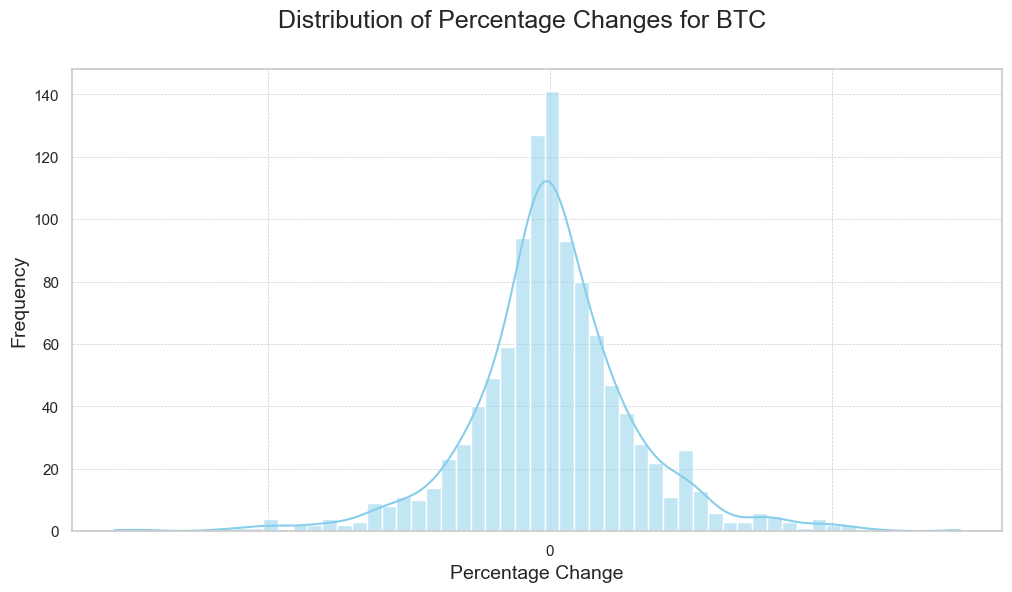

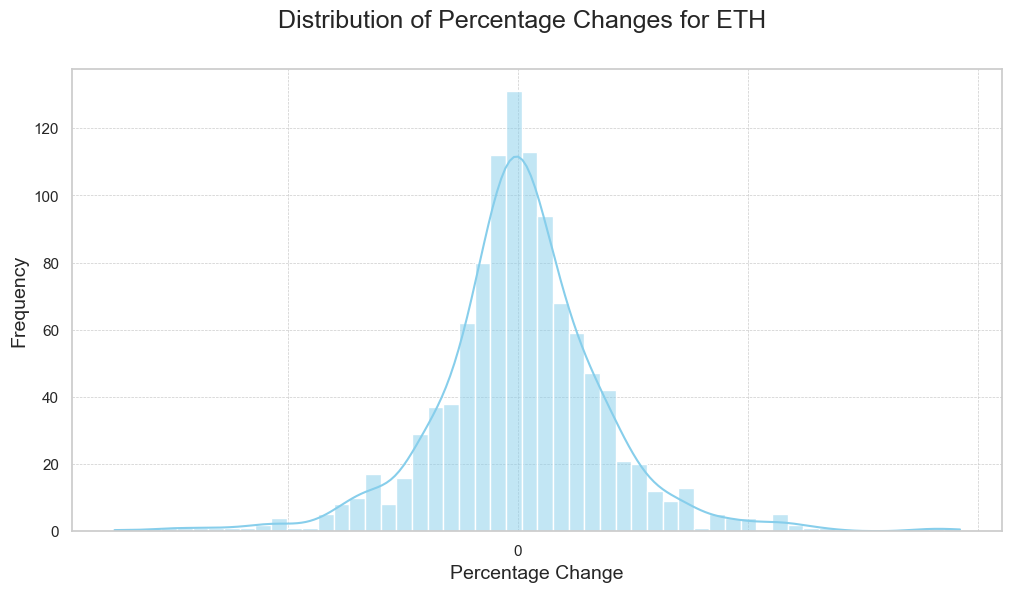

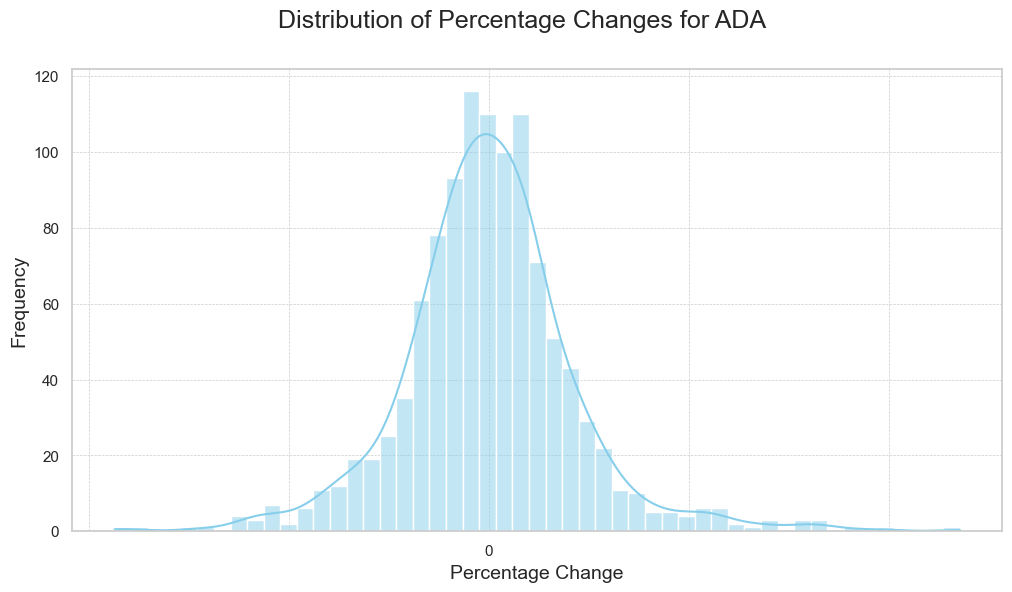

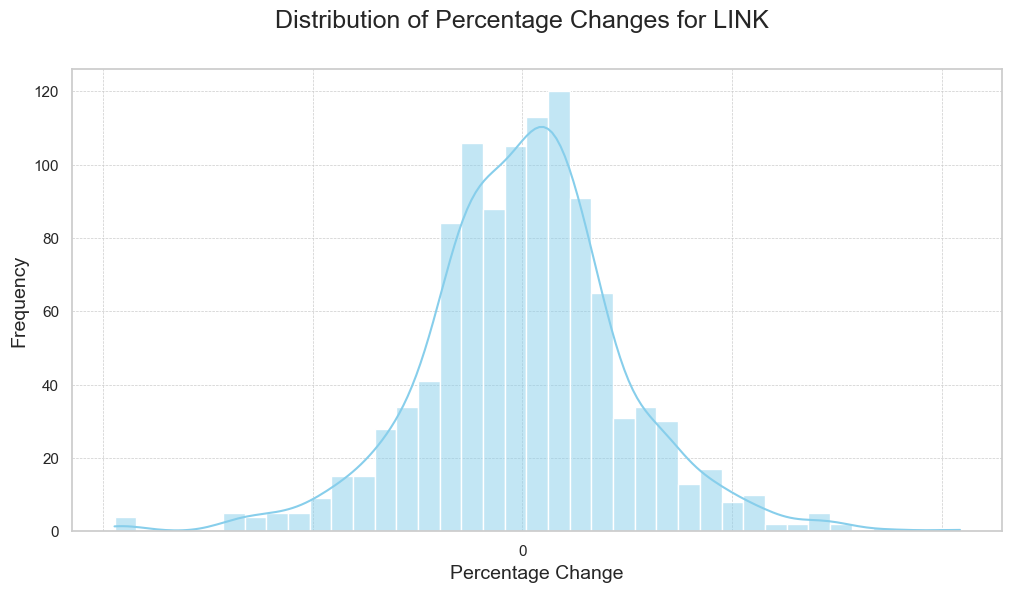

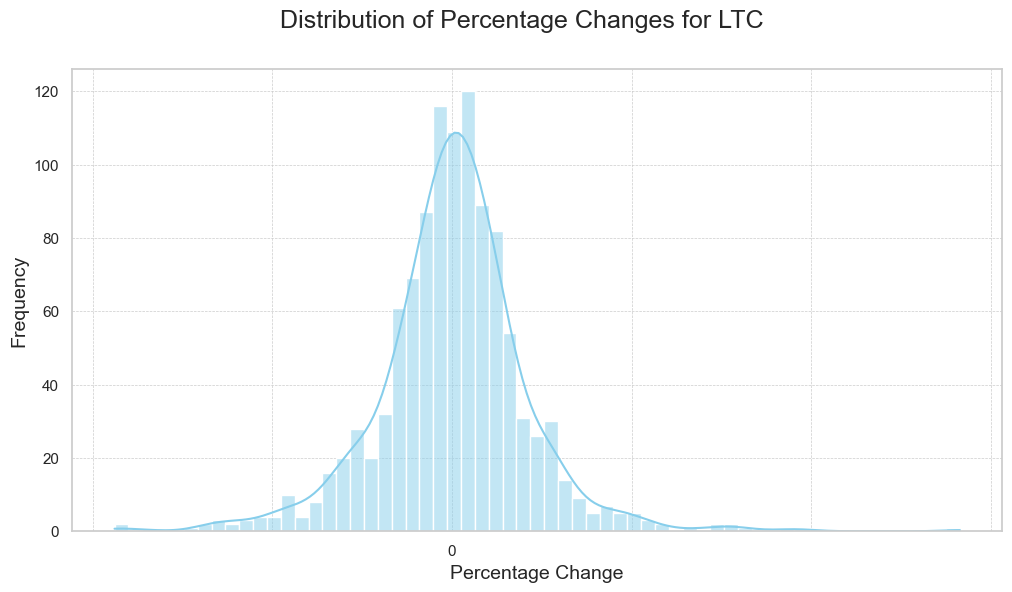

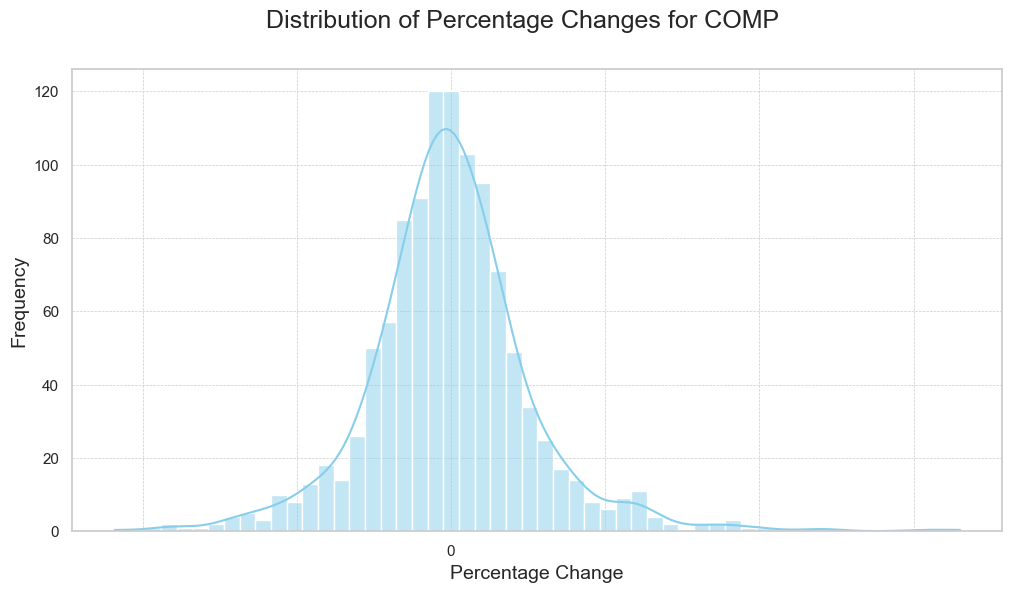

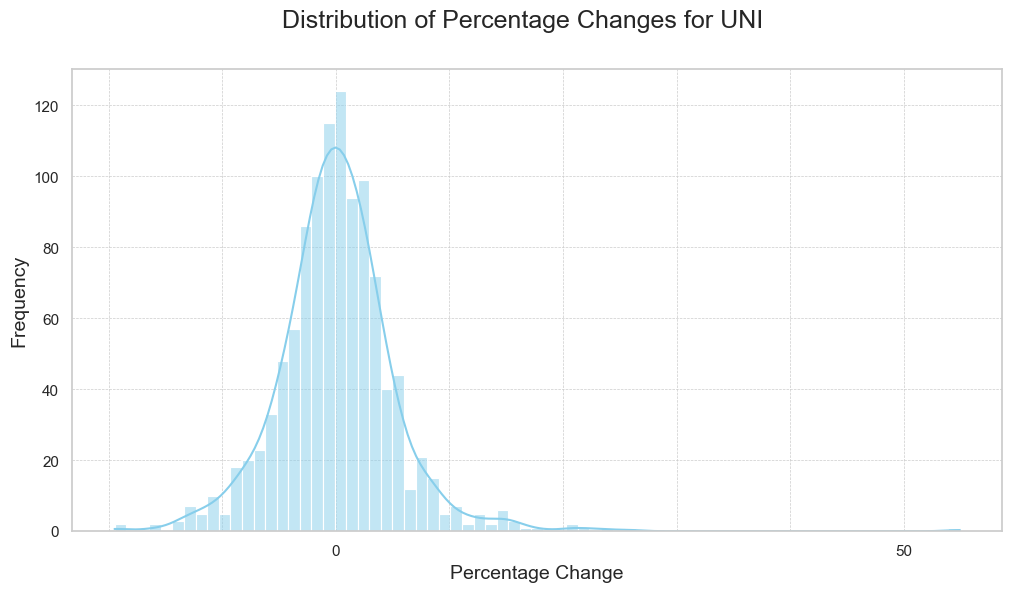

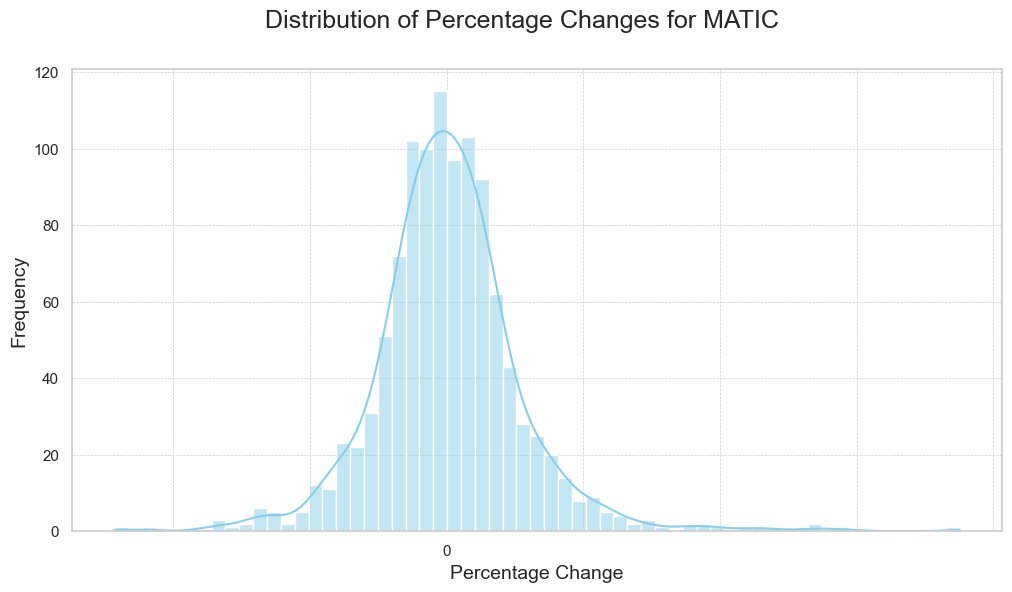

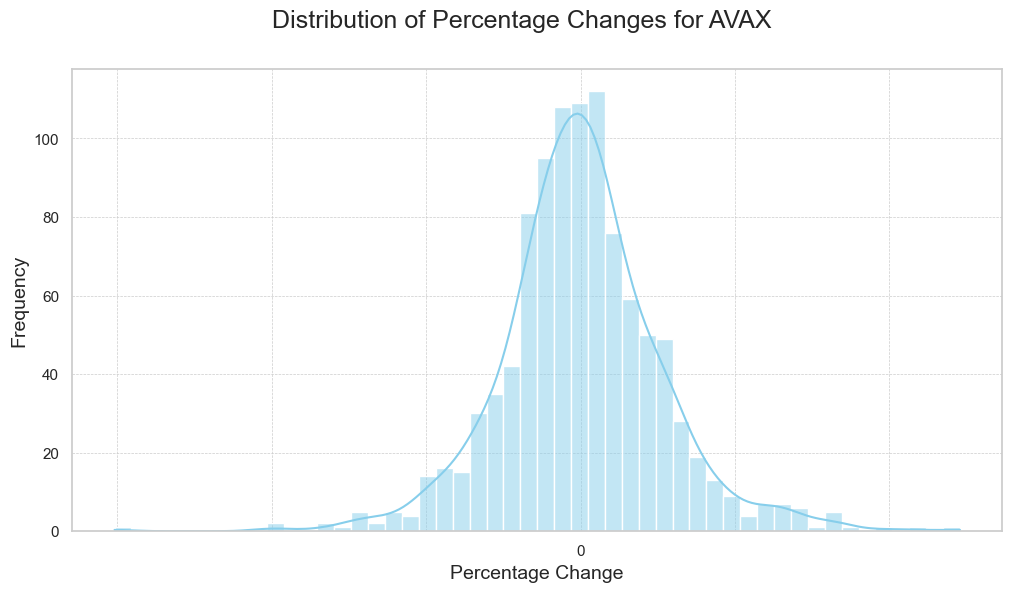

In [20]:
# Function to plot the distribution of percentage changes for each cryptocurrency
def plotPercentageChangeDistribution(name, data):
    sns.set(style="whitegrid")

    for coin in data['product_id'].unique():
        plt.figure(figsize=(12, 6))
        
        # Reset index to make 'pct_change' column accessible
        coin_data = data[data['product_id'] == coin].reset_index()
        
        ax = sns.histplot(coin_data['pct_change'], kde=True, color='skyblue')
        
        # Formatting the plot
        ax.set_xlabel('Percentage Change', fontsize=14)
        ax.set_ylabel('Frequency', fontsize=14)
        
        # Handling extreme values by setting custom ticks based on data range
        pct_range = coin_data['pct_change'].max() - coin_data['pct_change'].min()
        if pct_range > 1000:
            major_tick = int(pct_range / 10)  # reduce number of major ticks for wide ranges
        else:
            major_tick = 50  # default tick setting for closer ranges
        
        ax.xaxis.set_major_locator(ticker.MultipleLocator(major_tick))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(major_tick / 5))  # smaller increments
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

        # Add grid for better readability
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        plt.suptitle(f'Distribution of Percentage Changes for {name}', fontsize=18)
        plt.show()

# Example usage
for name, df in cryptos_info.items():
    plotPercentageChangeDistribution(name, df)


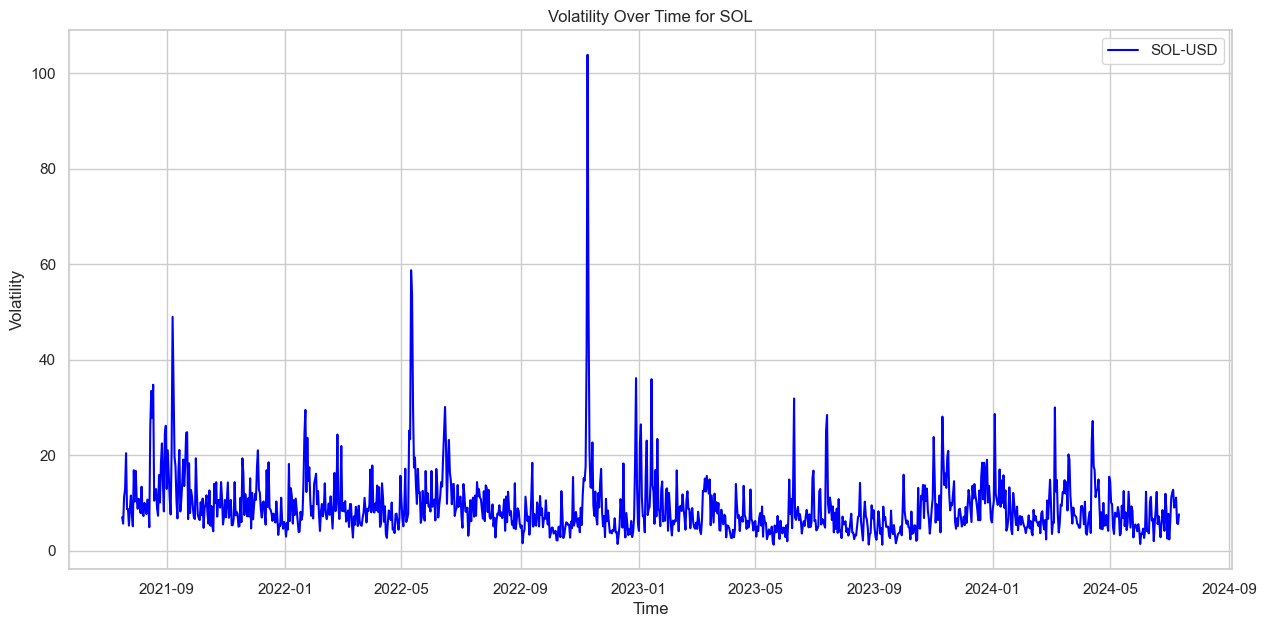

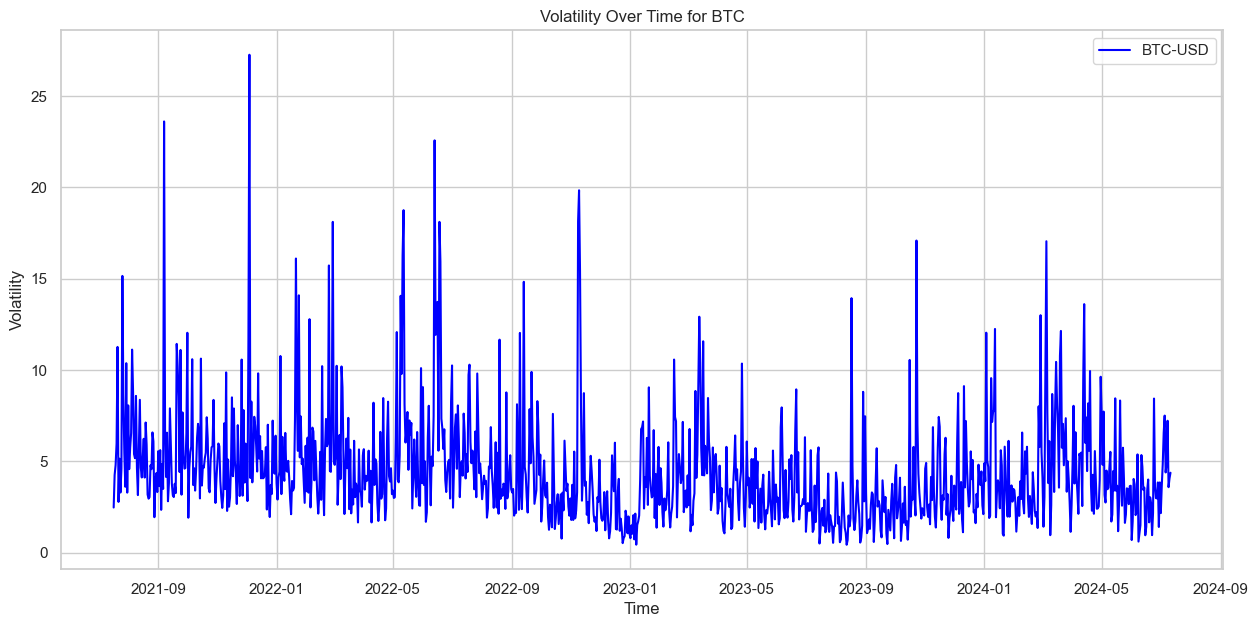

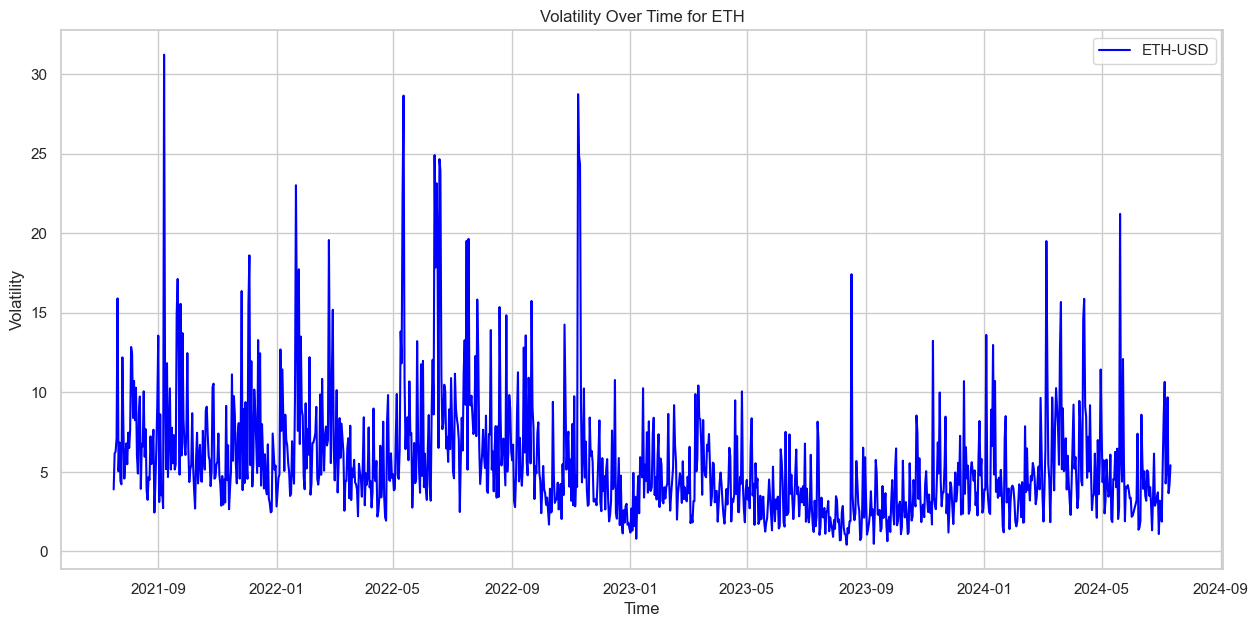

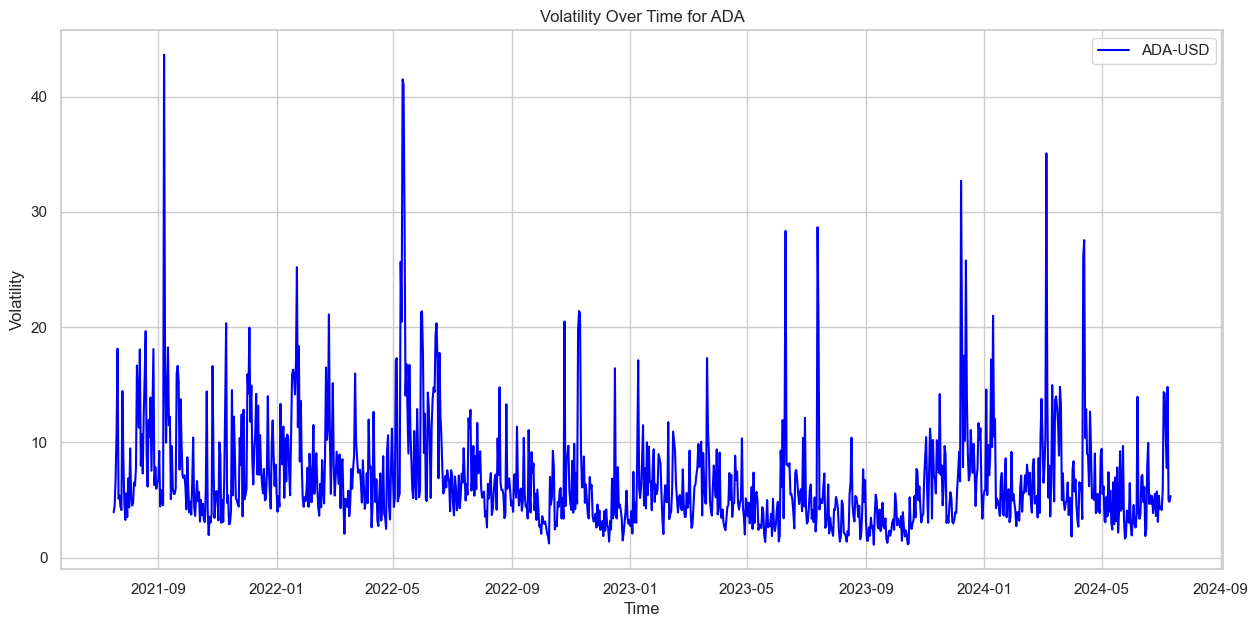

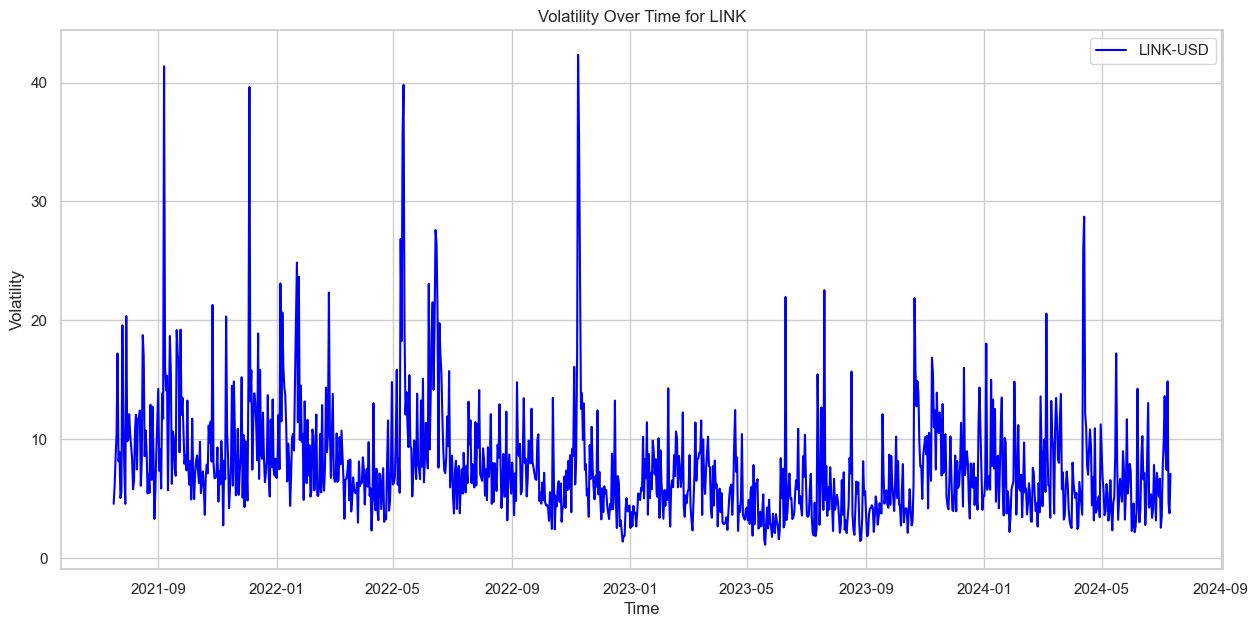

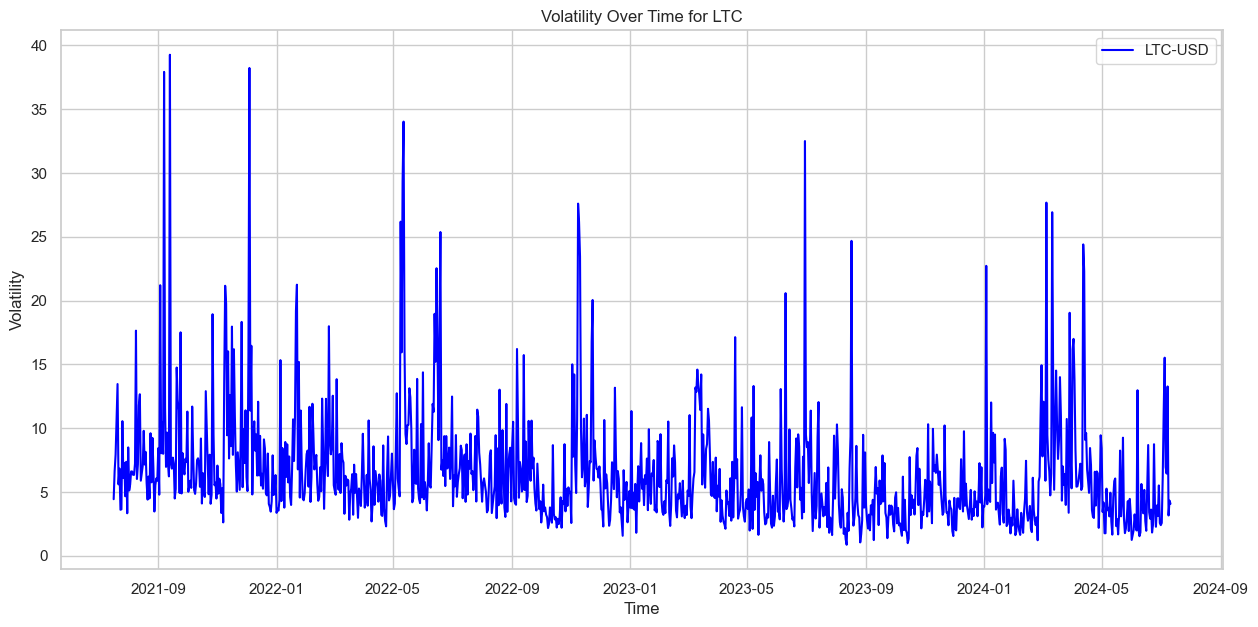

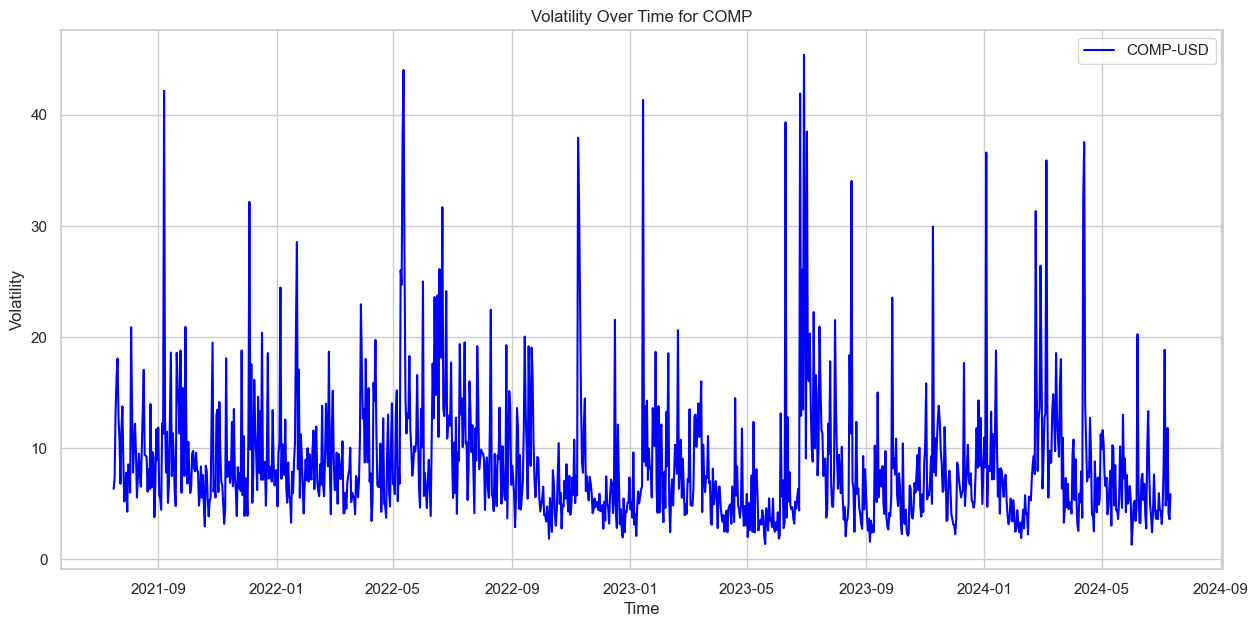

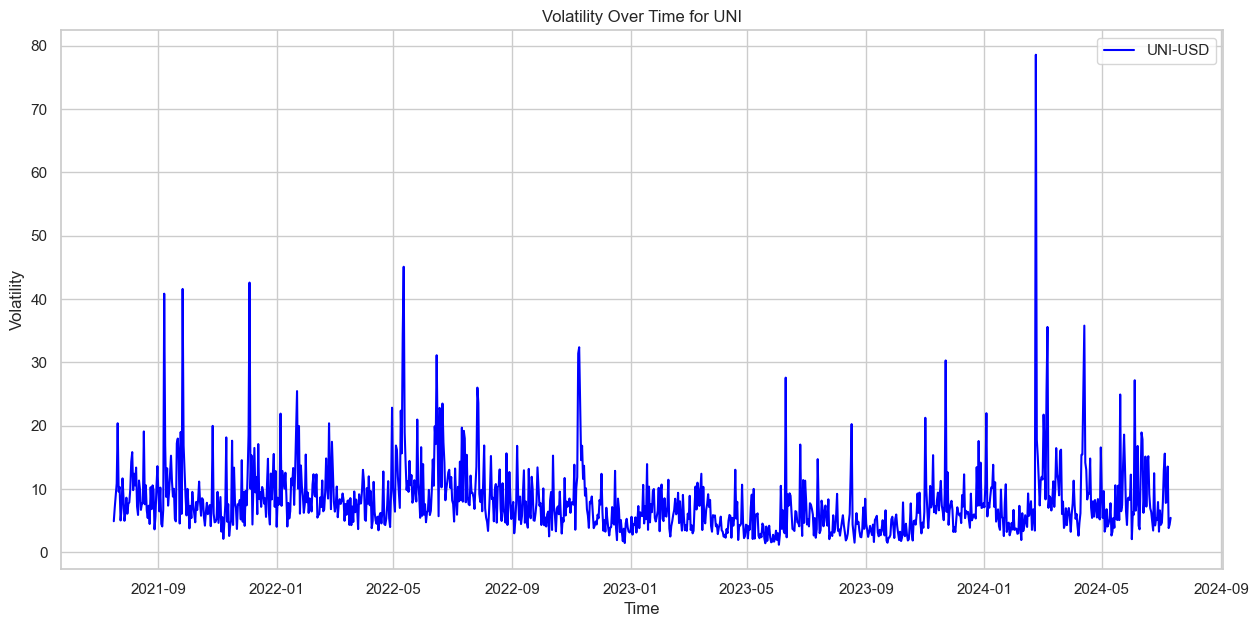

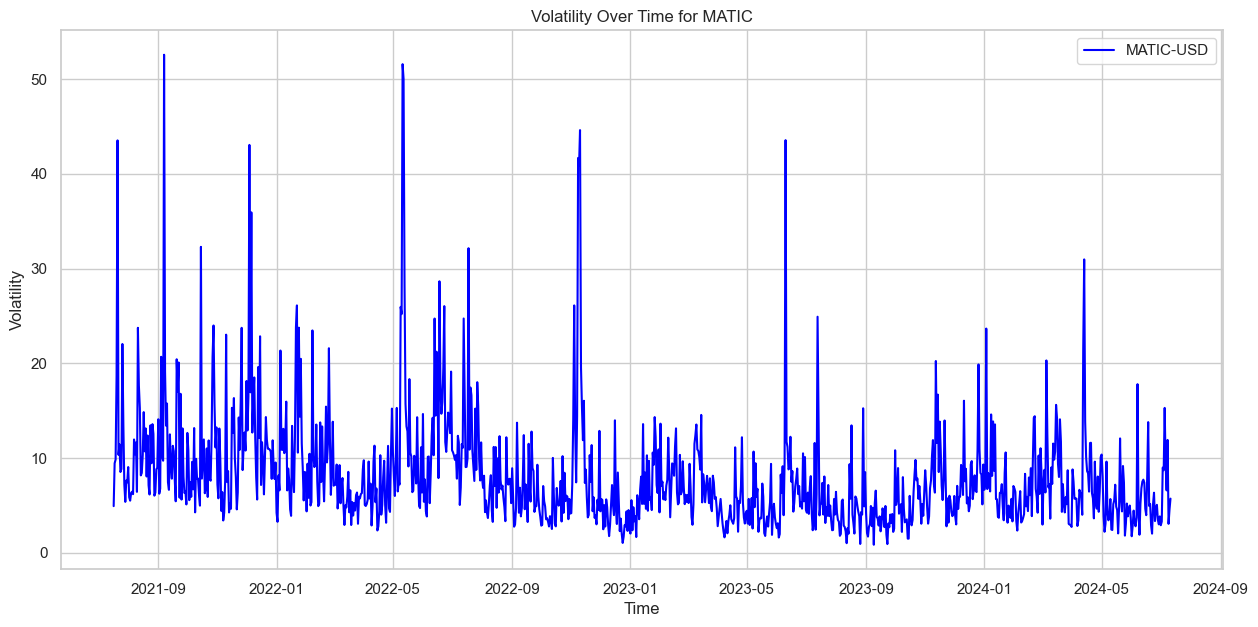

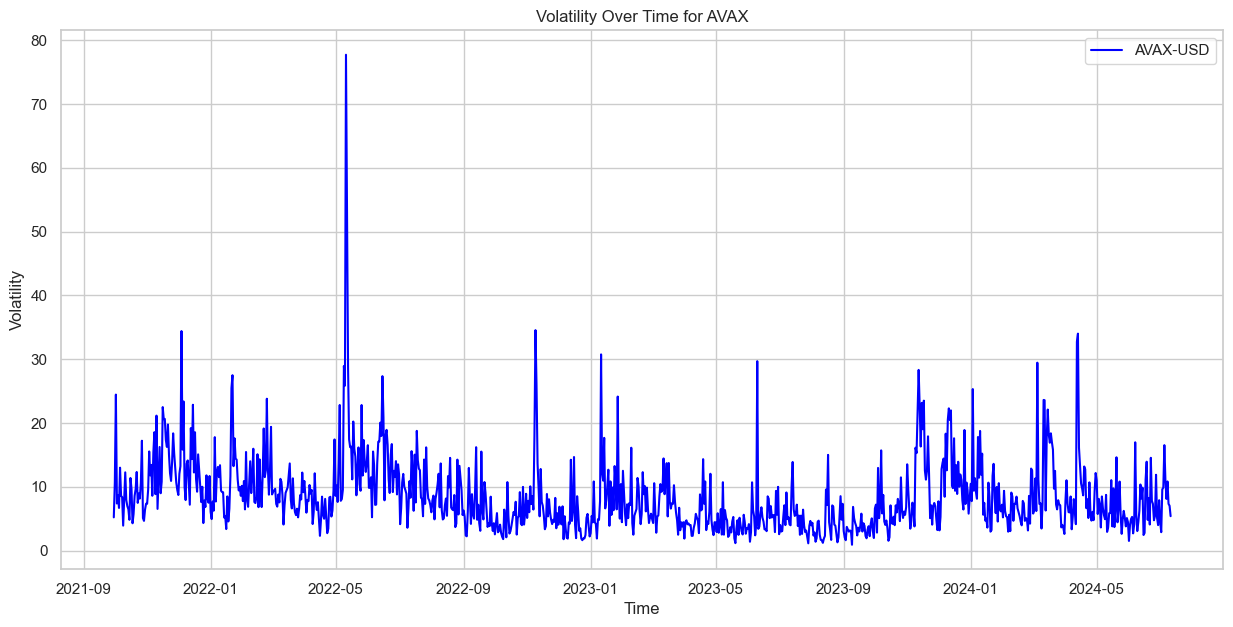

In [21]:
def calculateVolatility(cryptoData):
    # Calculate volatility if not present
    if 'volatility' not in cryptoData.columns:
        cryptoData.loc[:, 'volatility'] = cryptoData['close'].pct_change().rolling(window=10).std() * (252**0.5)

def plotVolatilityOverTime(name, data):
    # Plot volatility over time
    calculateVolatility(data)
    plt.figure(figsize=(15, 7))
    
    # Reset index to make 'time' column accessible
    data = data.reset_index()

    for product in data['product_id'].unique():
        product_data = data[data['product_id'] == product]
        plt.plot(product_data['time'], product_data['volatility'], label=product, color="blue")
    
    plt.title(f'Volatility Over Time for {name}')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

# Example usage
for name, df in cryptos_info.items():
    plotVolatilityOverTime(name, df)


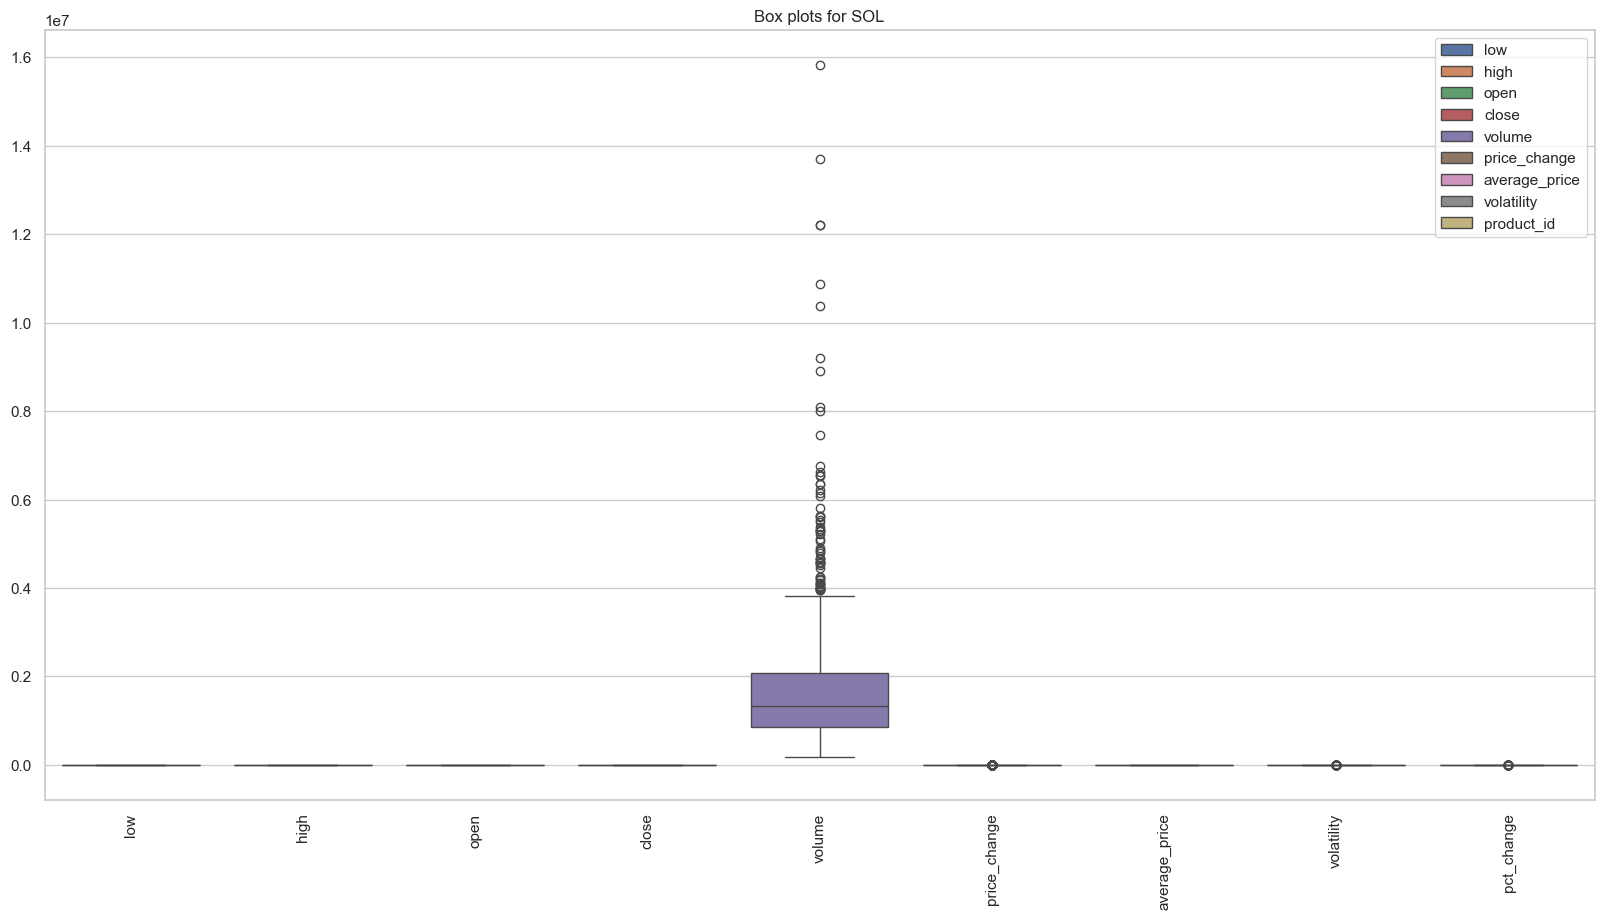

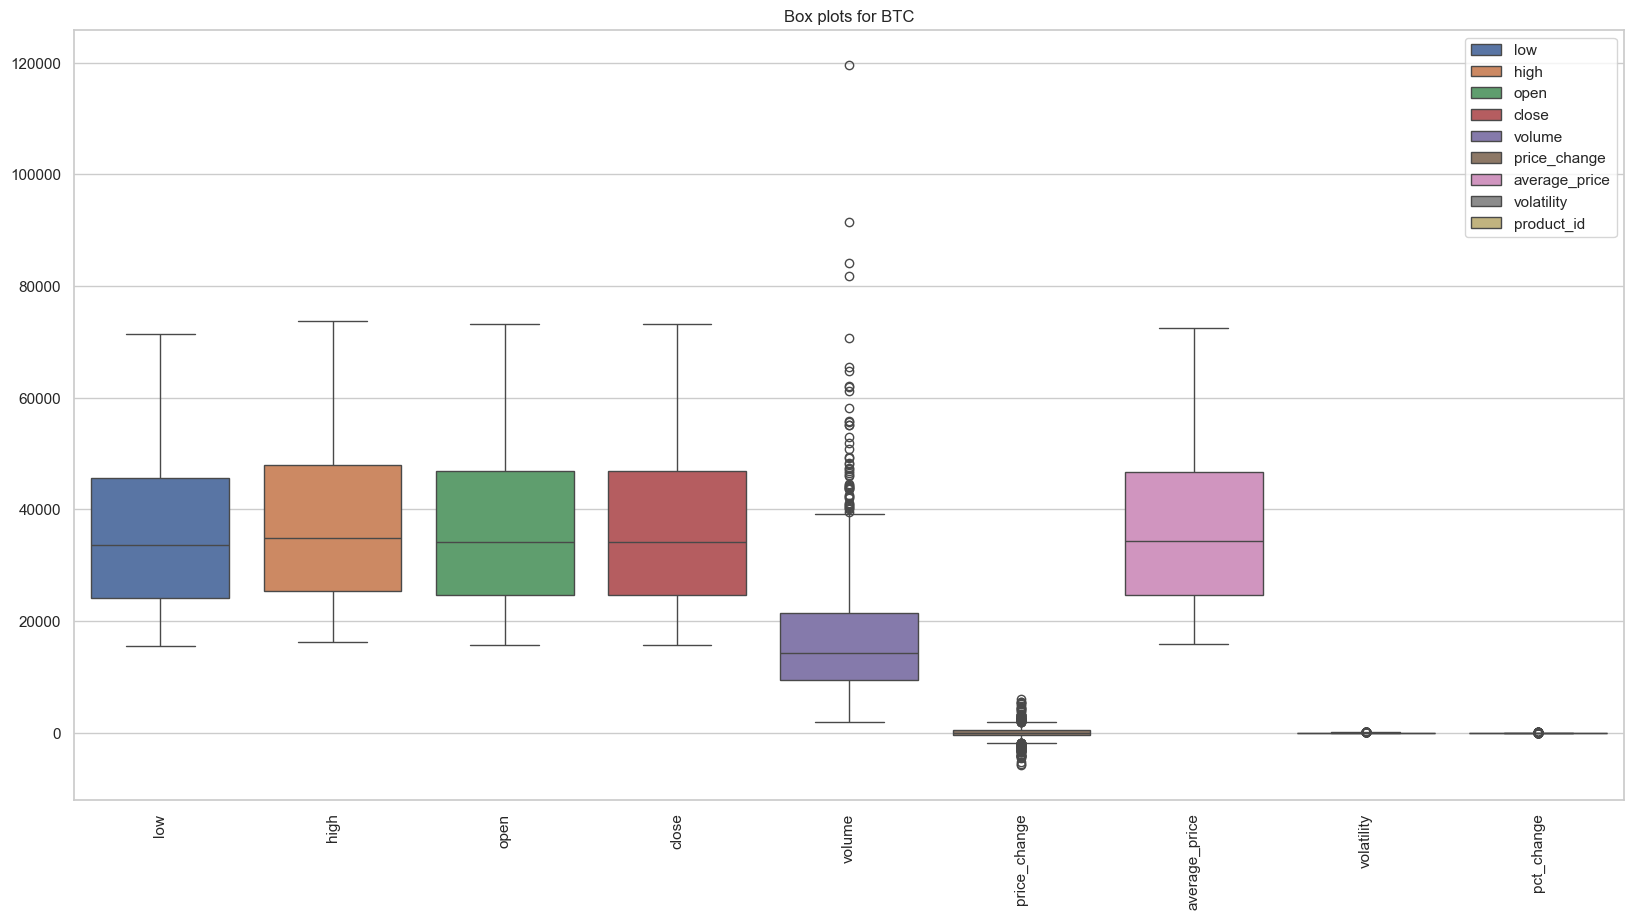

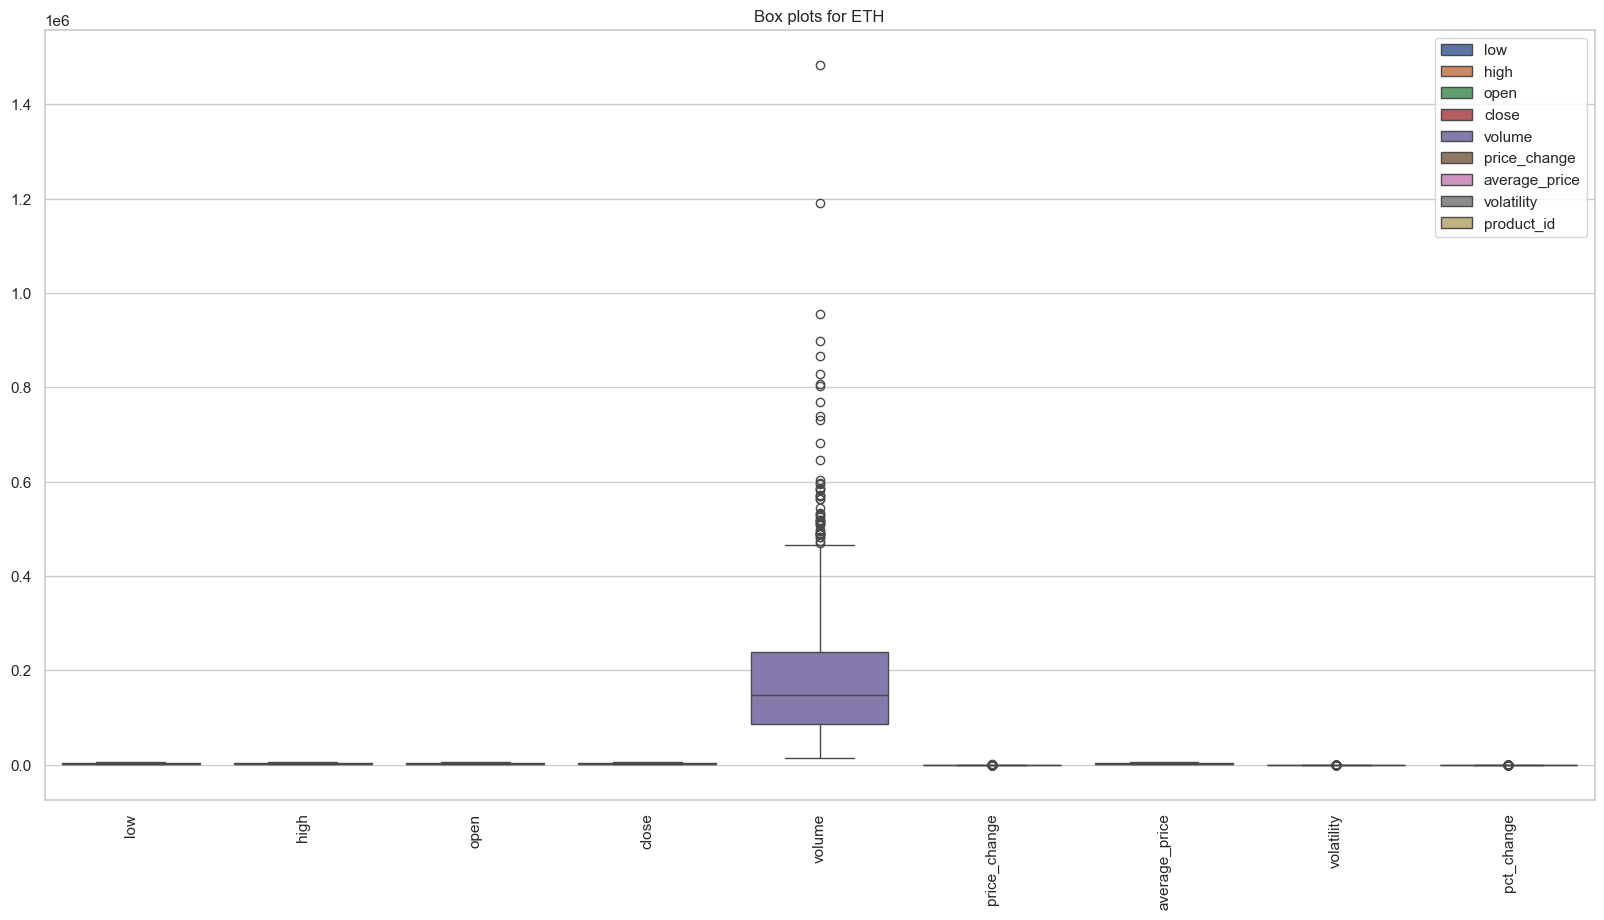

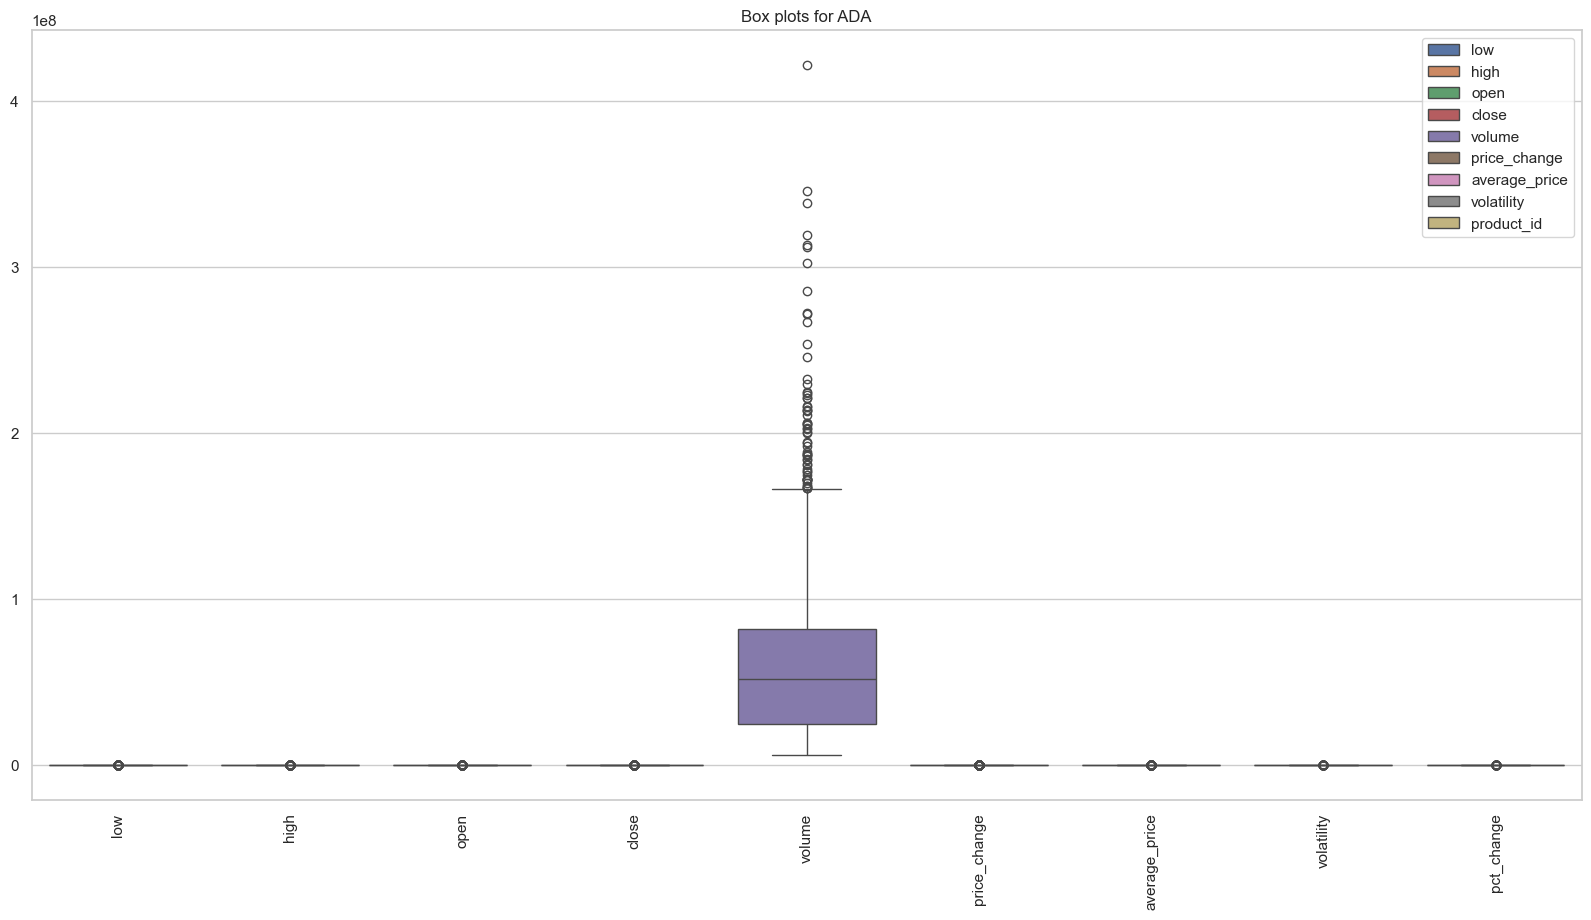

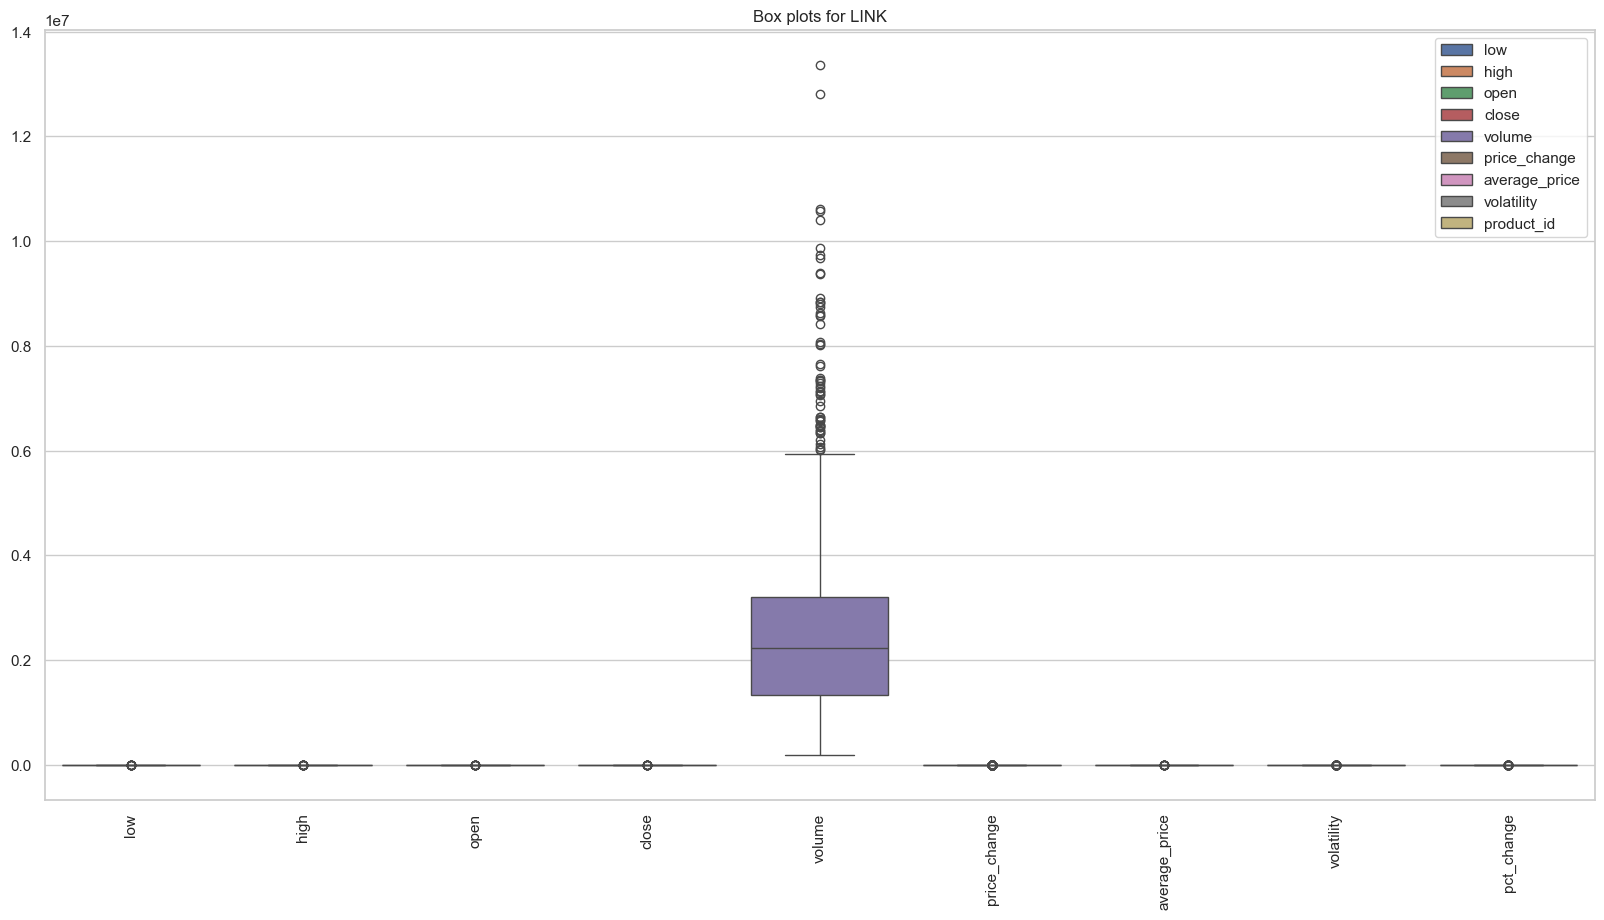

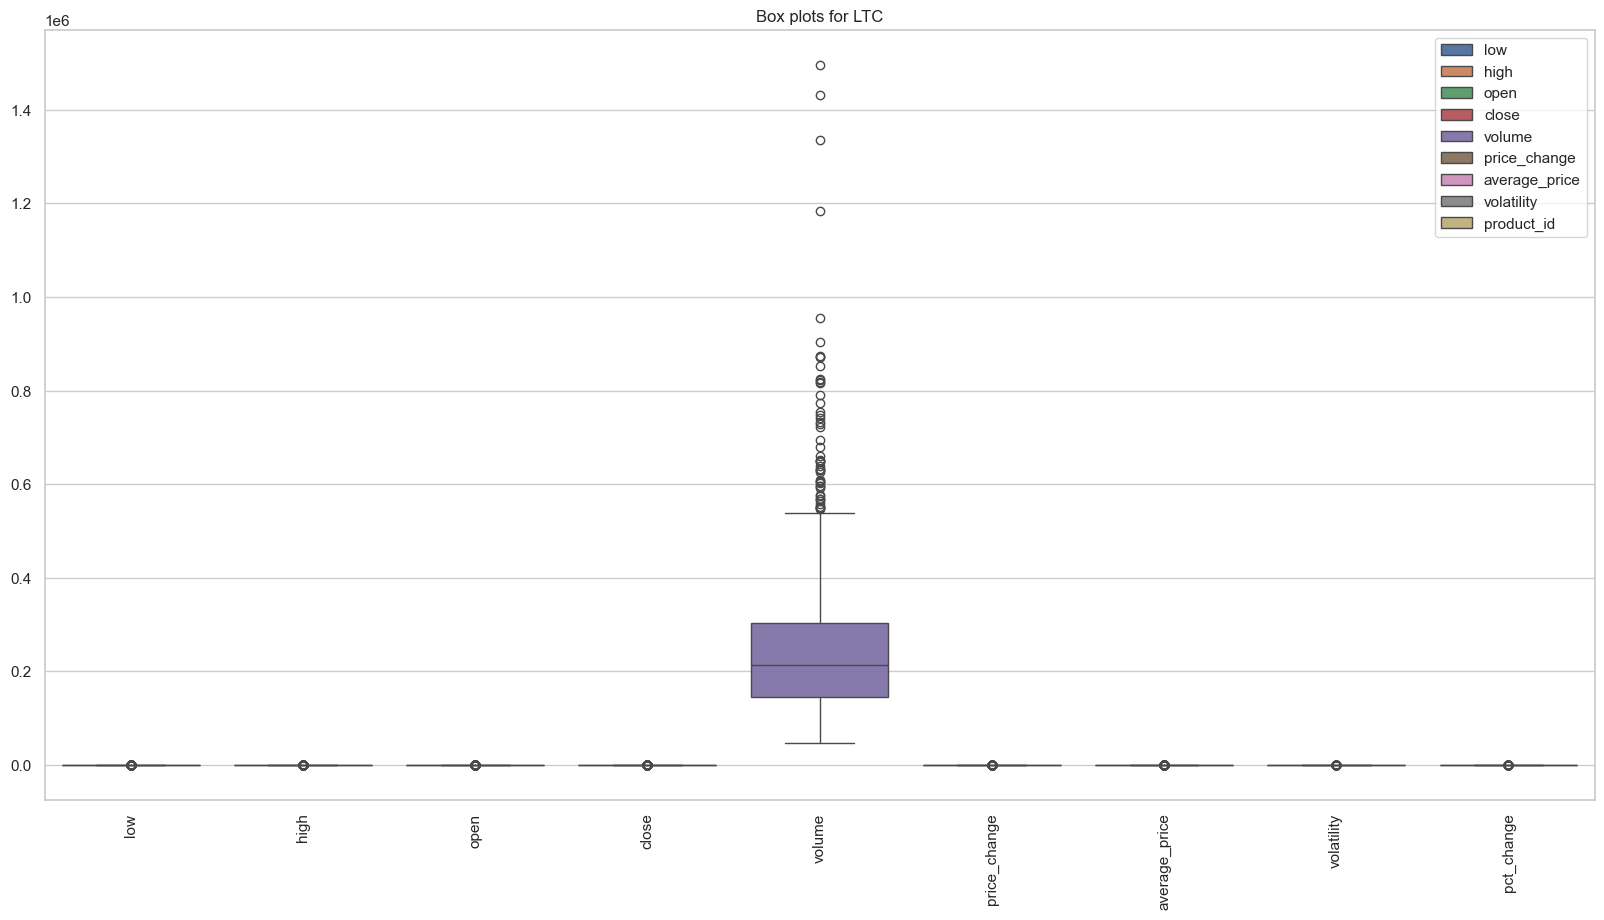

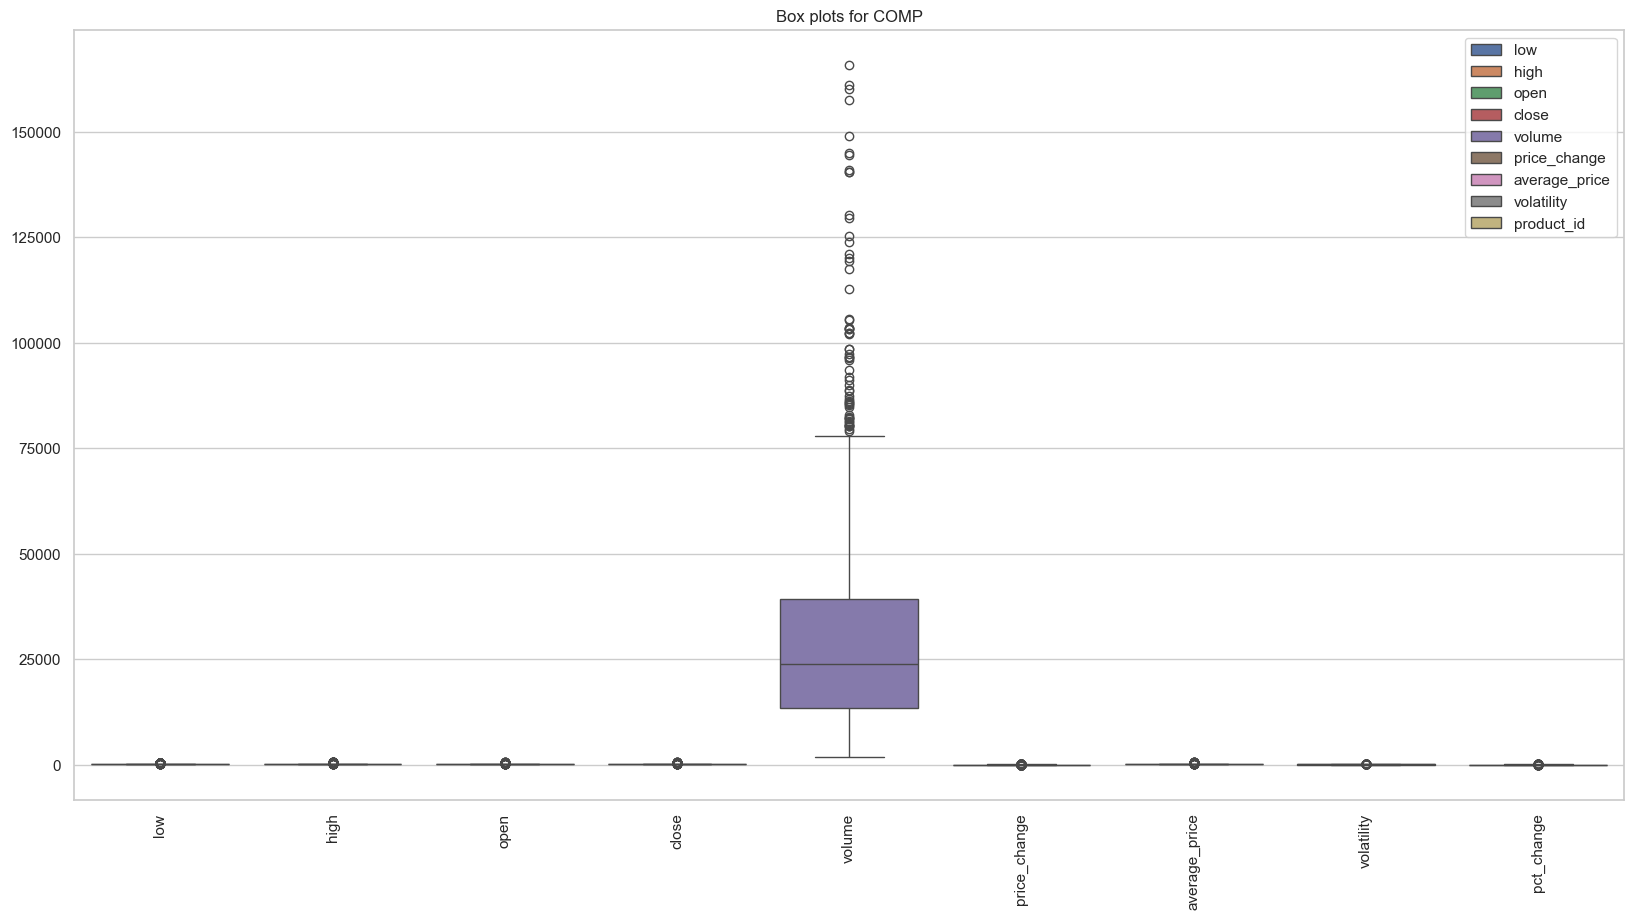

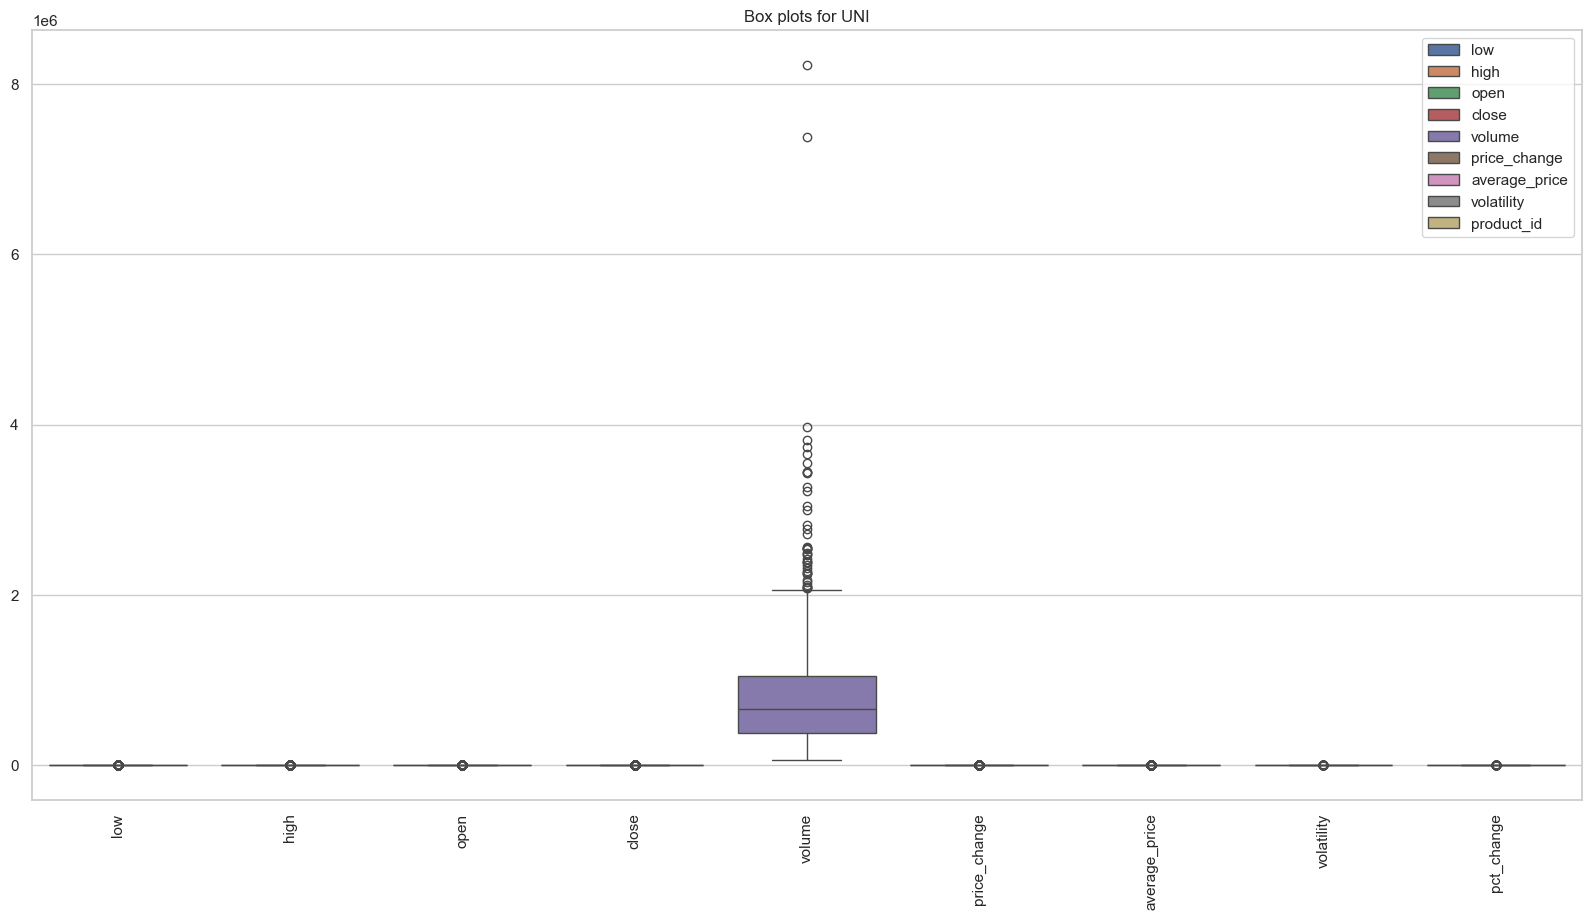

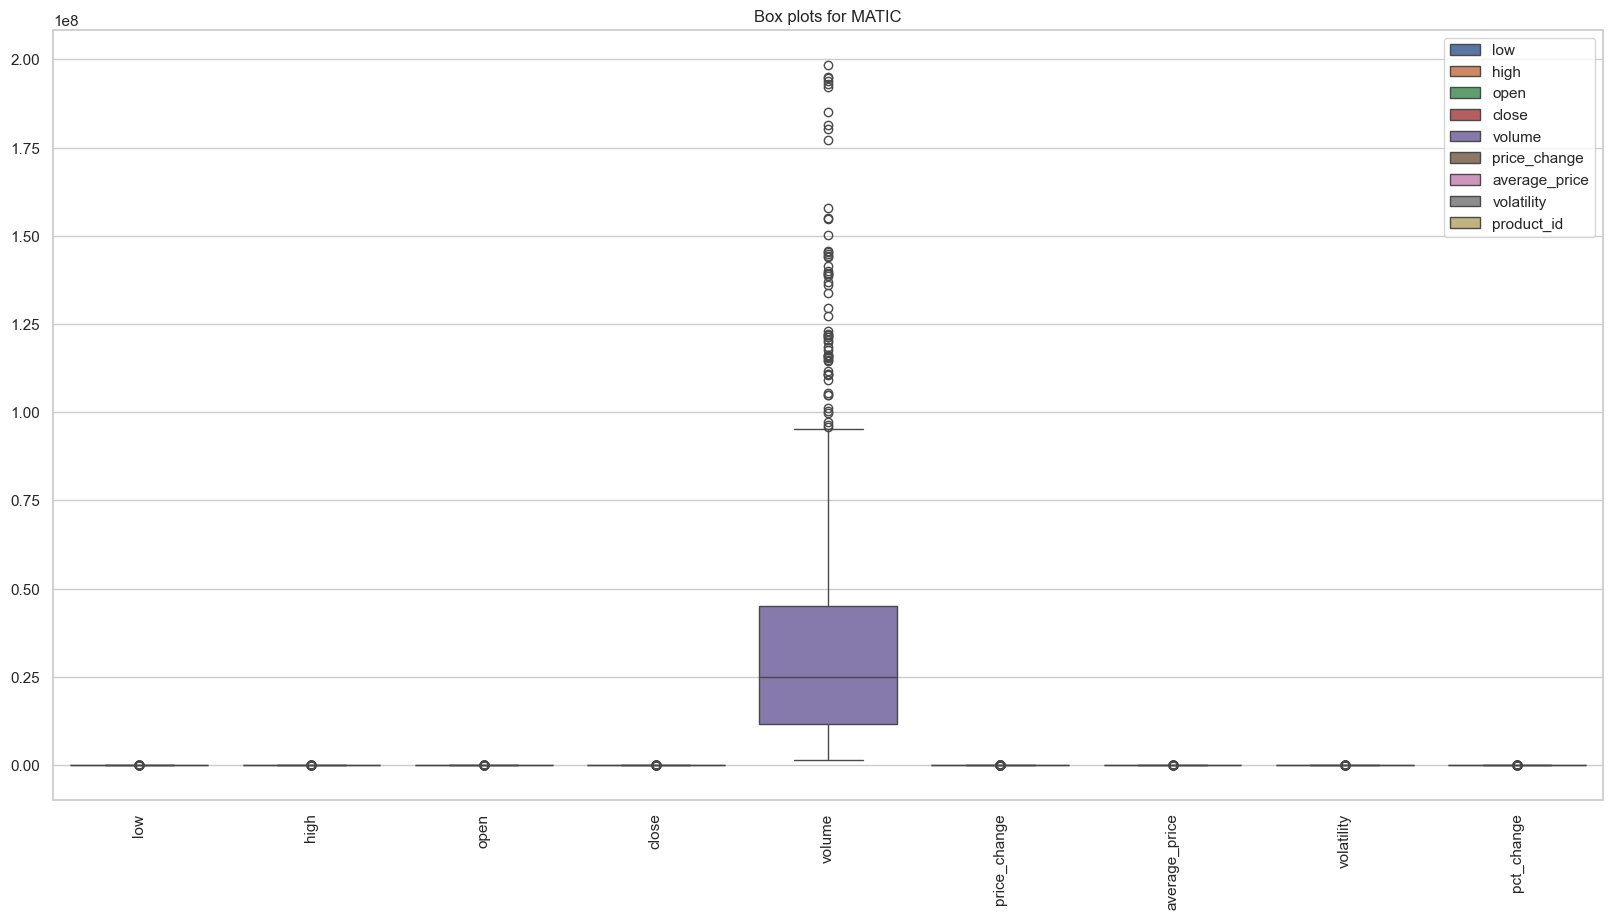

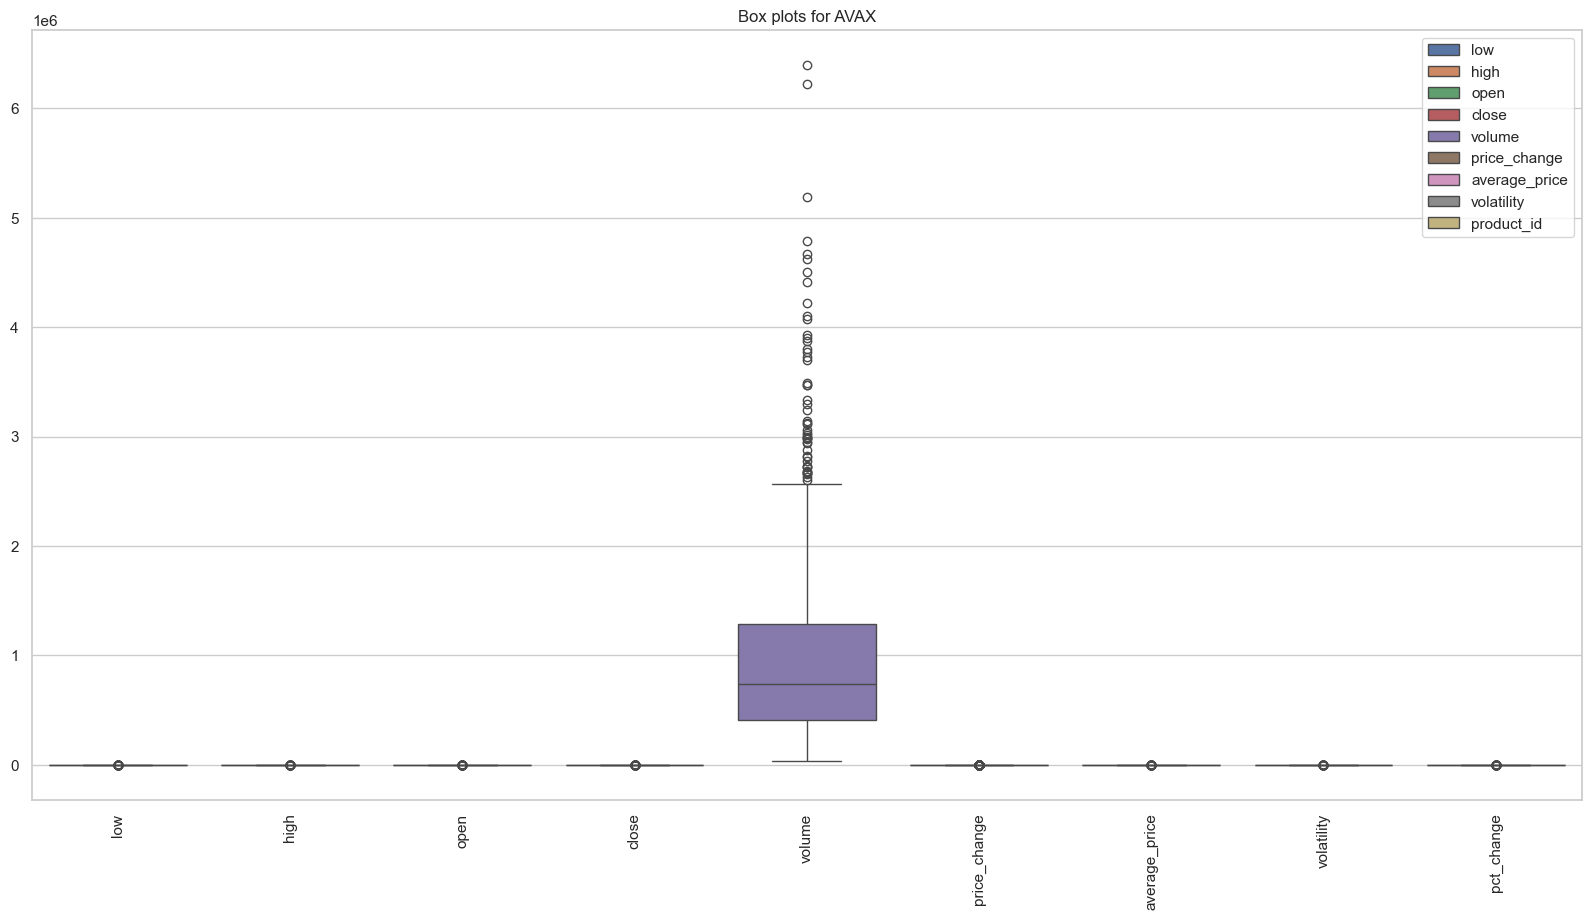

In [22]:
# Box plots
def plotBoxPlots(name, cryptoData):
    plt.figure(figsize=(20, 10))
    sns.boxplot(data=cryptoData)
    plt.title(f'Box plots for {name}')
    plt.xticks(rotation=90)
    plt.legend(labels=cryptoData.columns)
    plt.show()
    
for name, df in cryptos_info.items():
    plotBoxPlots(name, df)

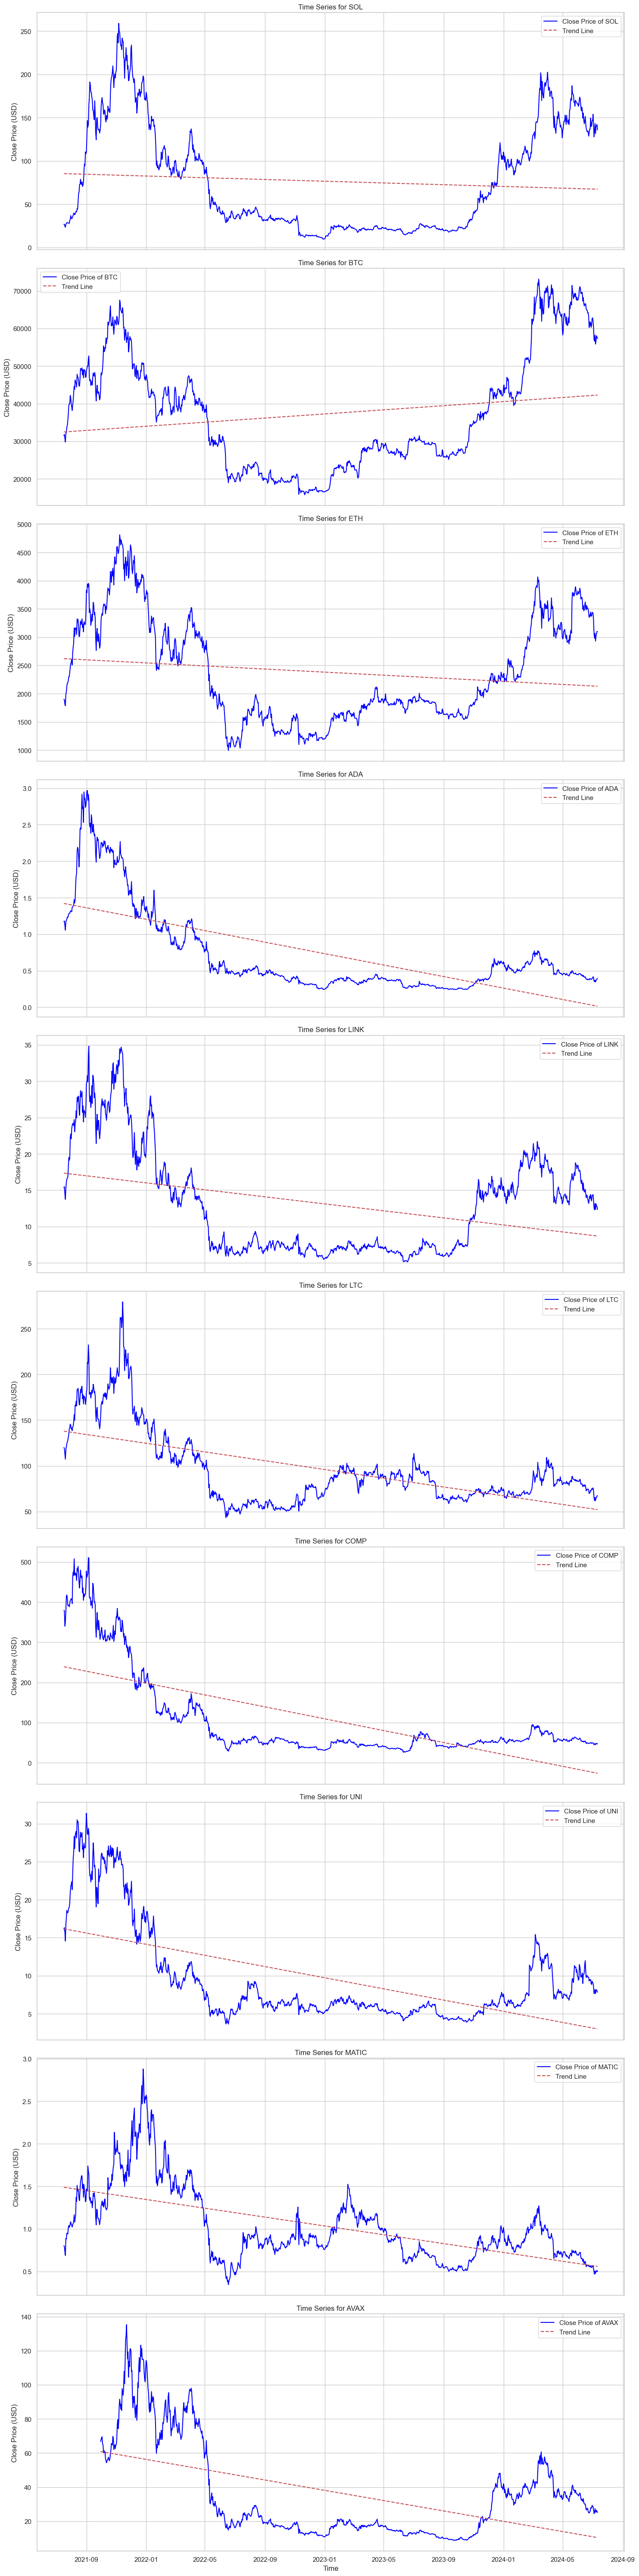

In [23]:
# Function to plot closing prices with subplots and trend lines
def plotClosingPricesWithTrend(cryptos_info):
    num_cryptos = len(cryptos_info)
    fig, axs = plt.subplots(num_cryptos, figsize=(15, 6 * num_cryptos), sharex=True)

    for i, (label, data) in enumerate(cryptos_info.items()):
        # Reset index to make 'time' column accessible
        data = data.reset_index()

        axs[i].plot(data['time'], data['close'], label=f'Close Price of {label}', color='blue')
        
        # Adding a trend line
        z = np.polyfit(mdates.date2num(data['time']), data['close'], 1)
        p = np.poly1d(z)
        axs[i].plot(data['time'], p(mdates.date2num(data['time'])), "r--", label="Trend Line")
        
        axs[i].set_title(f'Time Series for {label}')
        axs[i].set_ylabel('Close Price (USD)')
        axs[i].legend()

    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

# Example usage
plotClosingPricesWithTrend(cryptos_info)

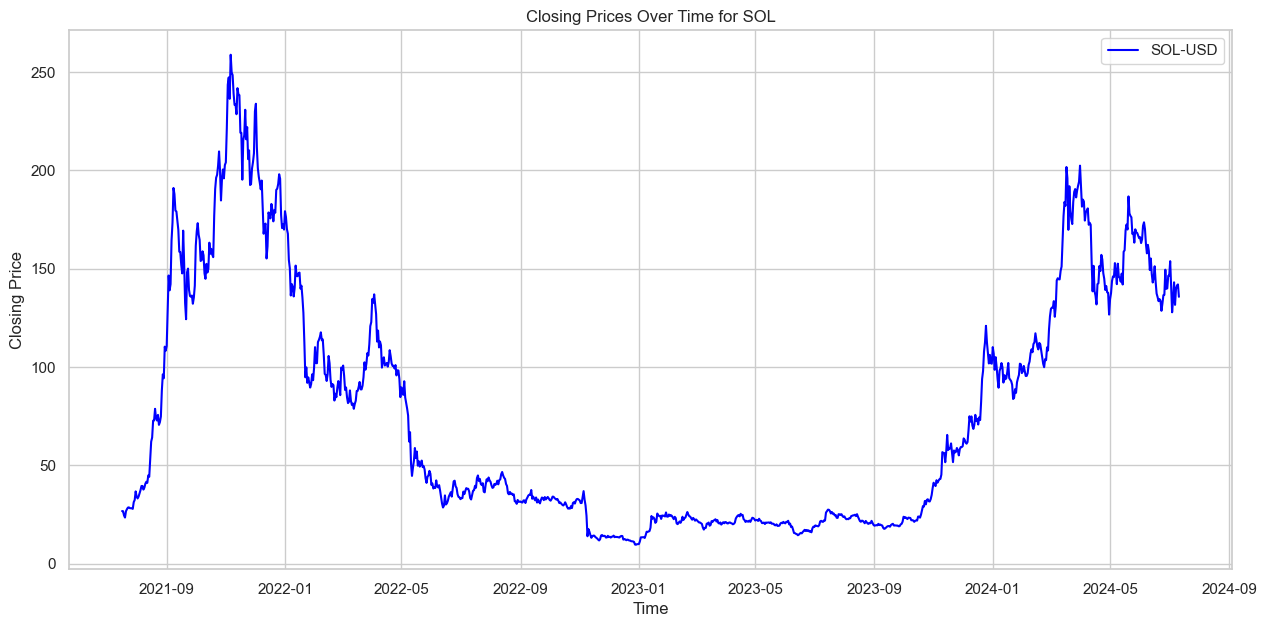

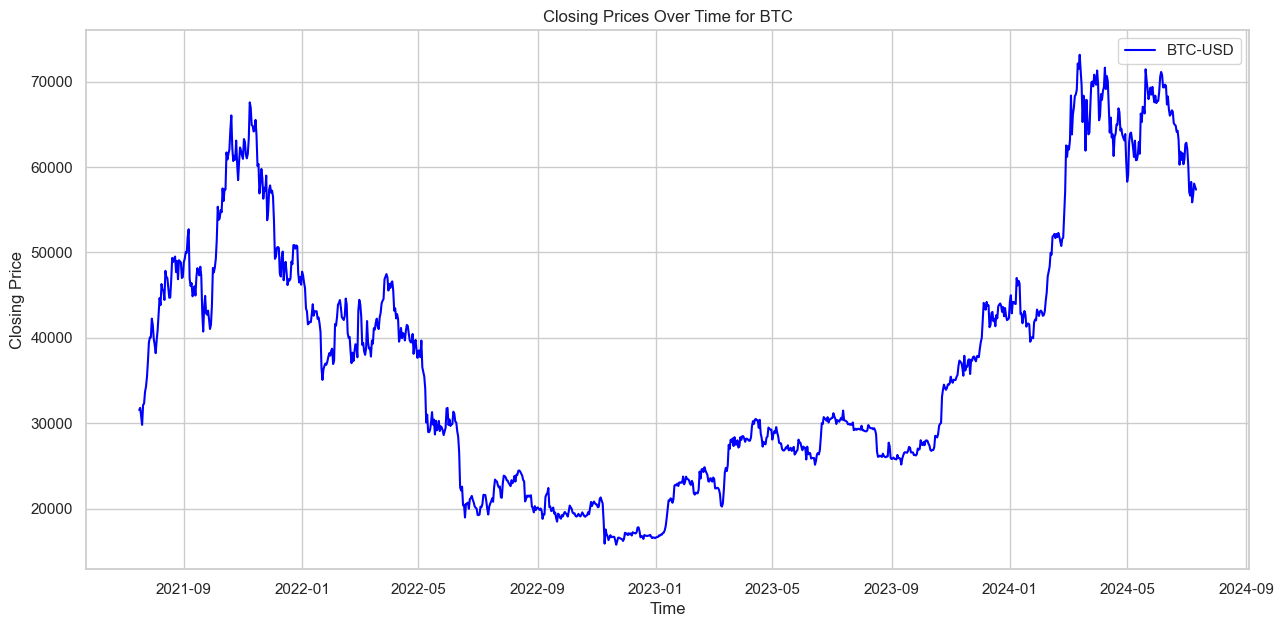

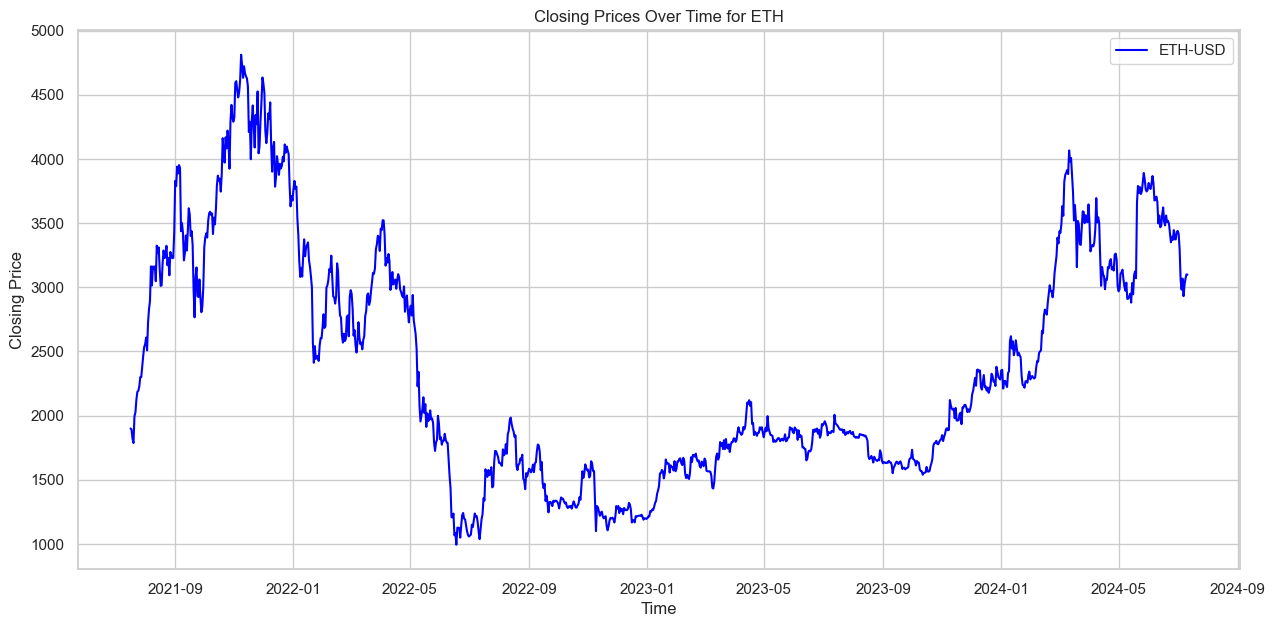

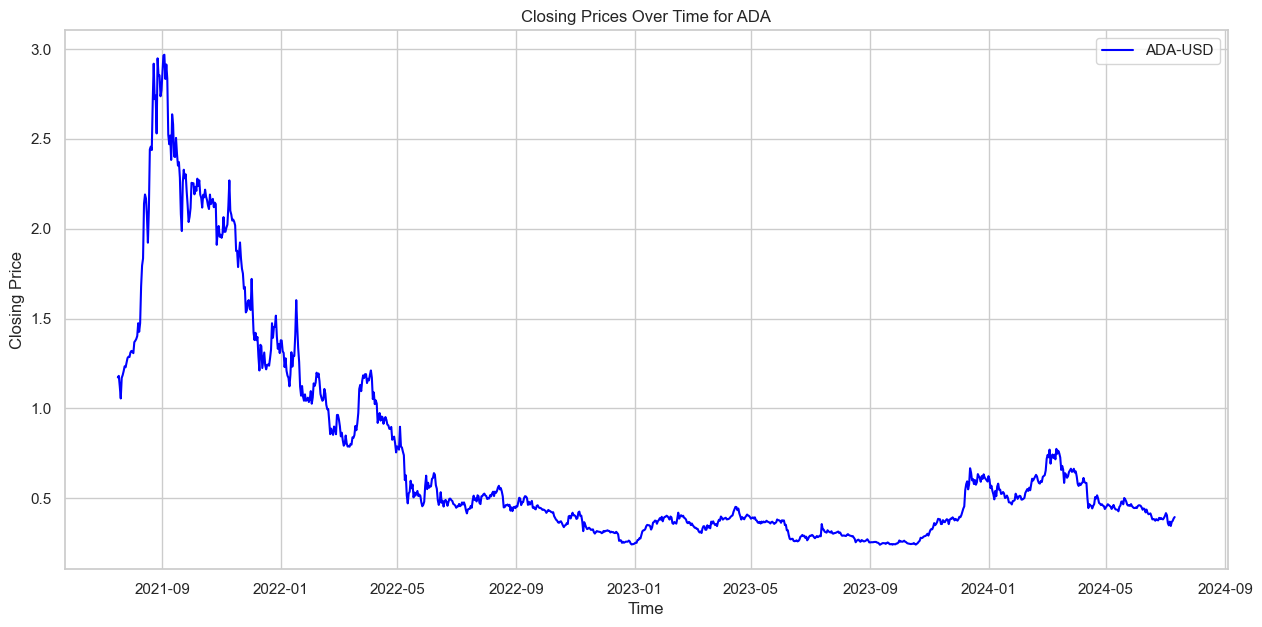

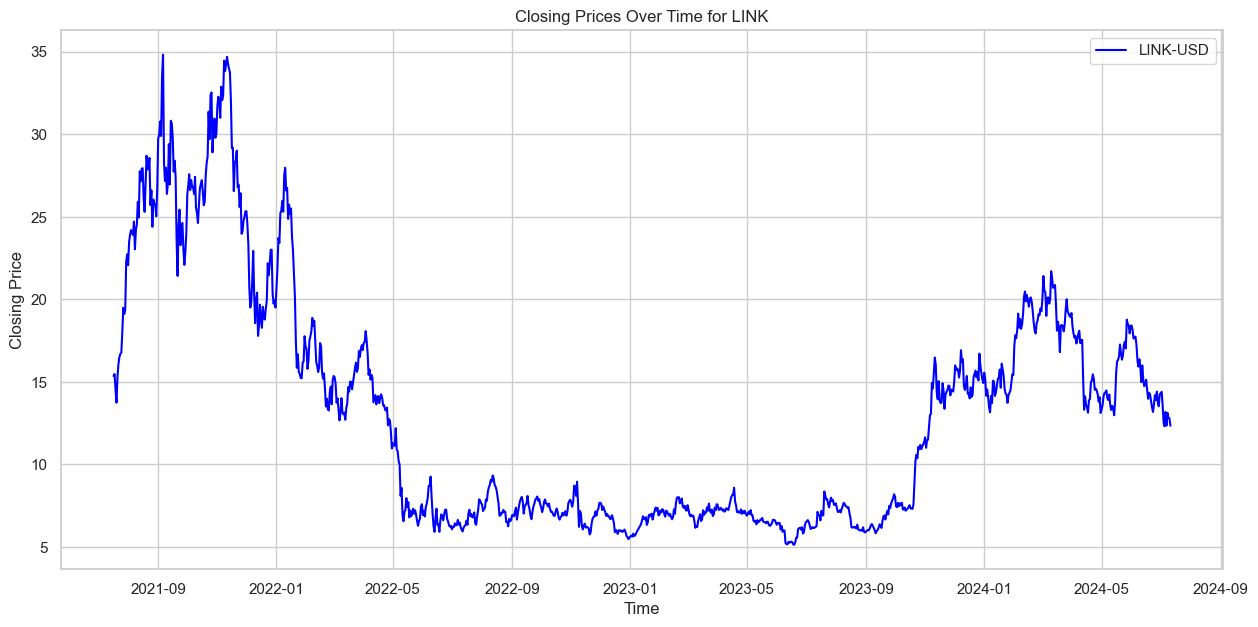

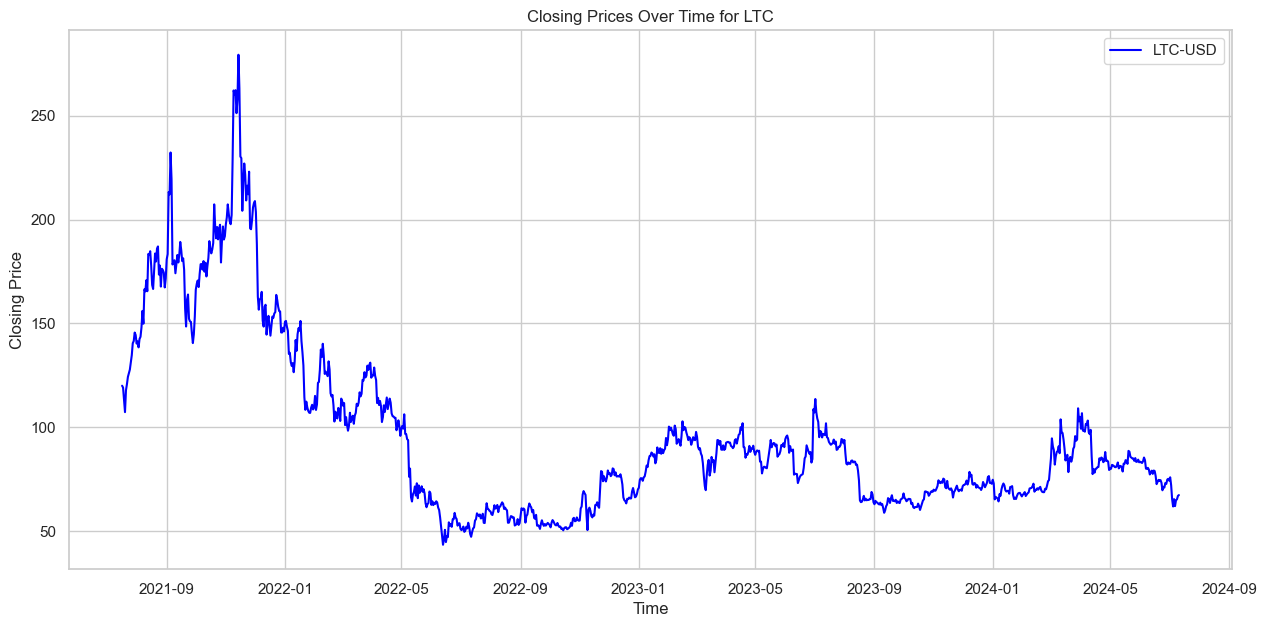

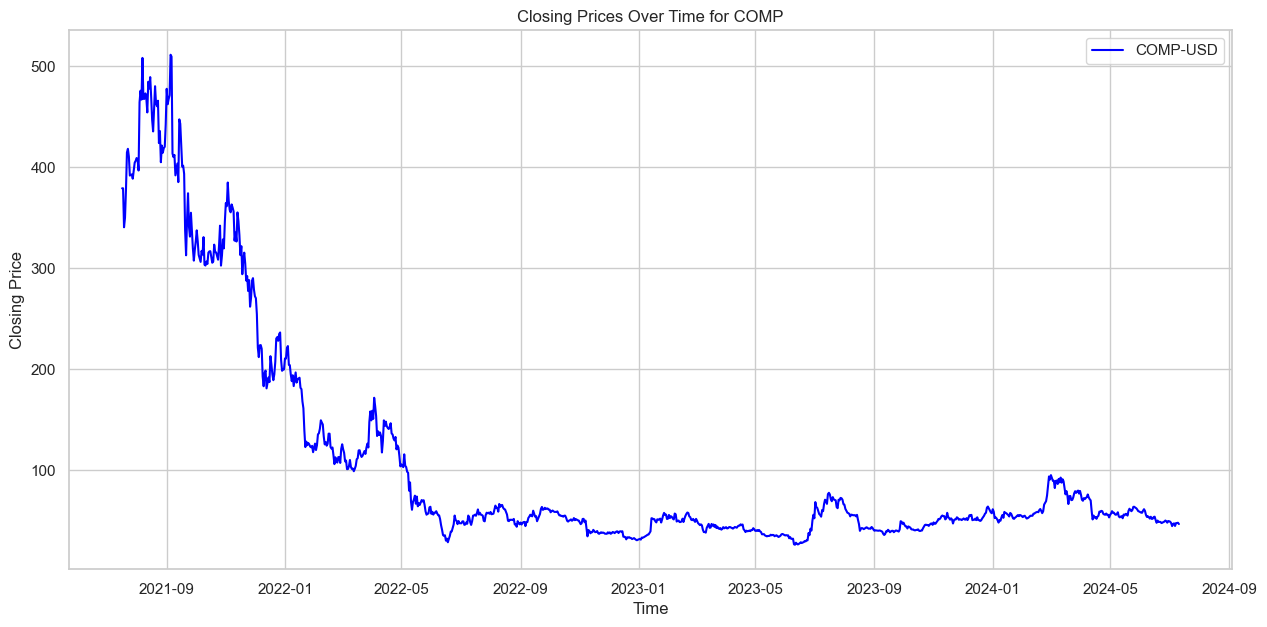

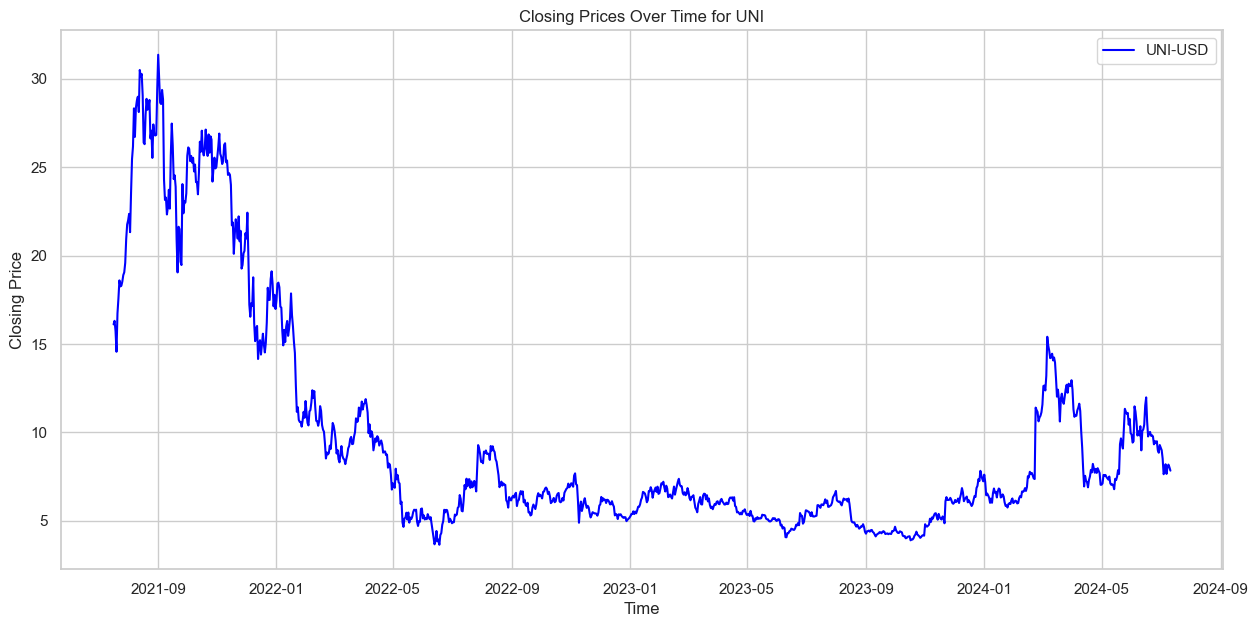

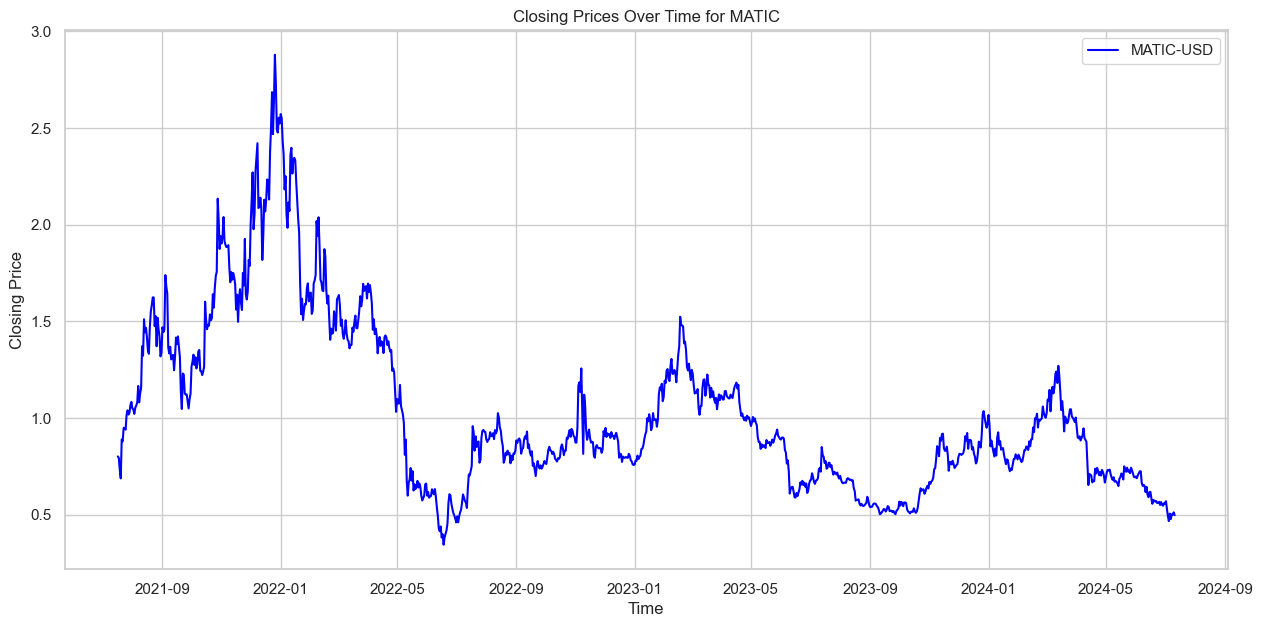

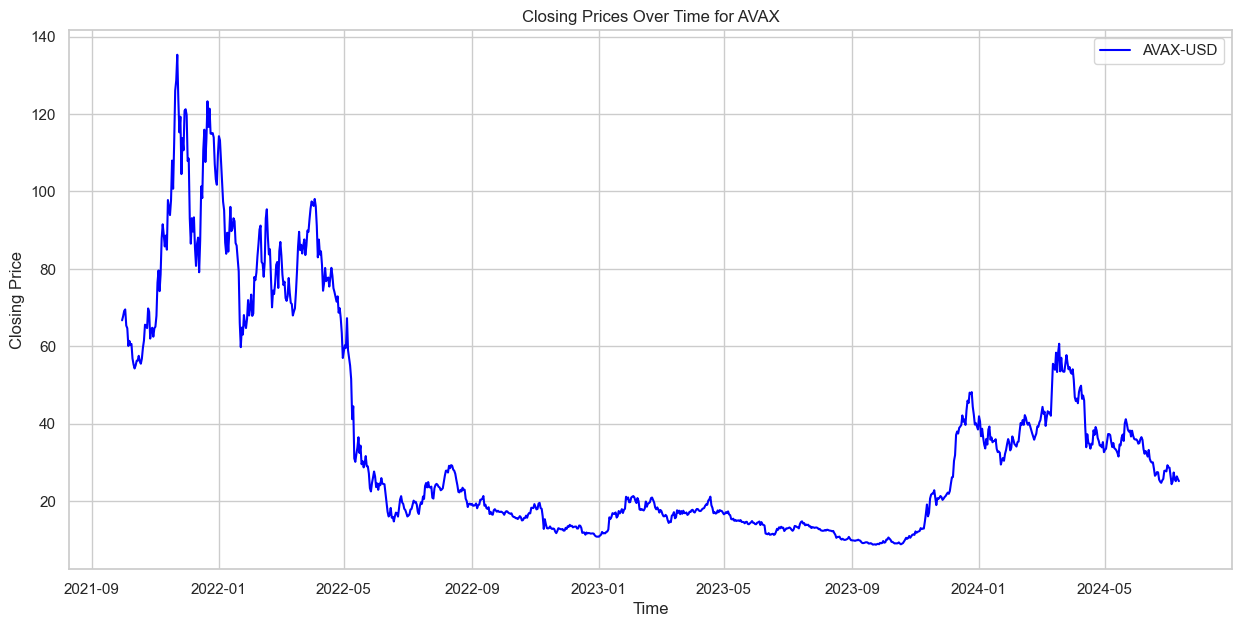

In [24]:
# Line plot for closing prices
def plotClosingPrices(name, data):
    plt.figure(figsize=(15, 7))
    
    # Reset index to make 'time' column accessible
    data = data.reset_index()
    
    for product in data['product_id'].unique():
        product_data = data[data['product_id'] == product]
        plt.plot(product_data['time'], product_data['close'], label=product, color='blue')
    
    plt.title(f'Closing Prices Over Time for {name}')
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

# Example usage
for name, df in cryptos_info.items():
    plotClosingPrices(name, df)

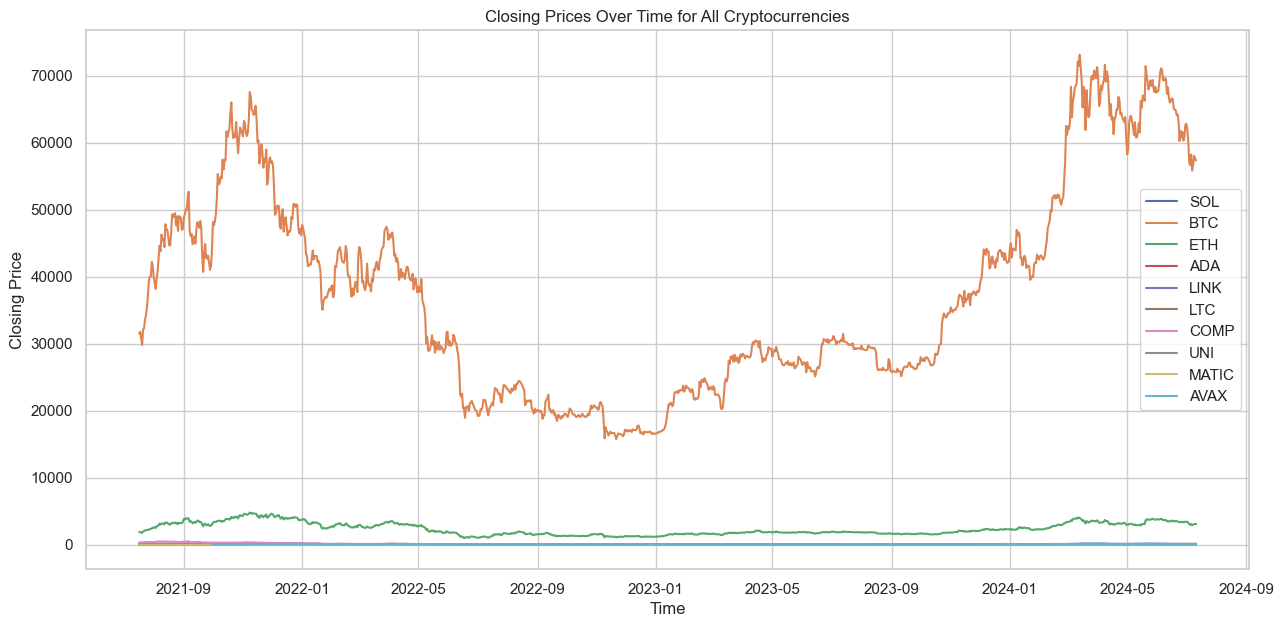

In [25]:
# Function to plot closing prices for all cryptos in one plot
def plotClosingPricesAll(cryptos_info):
    plt.figure(figsize=(15, 7))
    for name, df in cryptos_info.items():
        # Reset index to make 'time' column accessible
        df = df.reset_index()
        plt.plot(df['time'], df['close'], label=name)
    plt.title('Closing Prices Over Time for All Cryptocurrencies')
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
plotClosingPricesAll(cryptos_info)

In [26]:
### Add Title and enhance the visualization with specific cryptocurrency title
def test_stationarity(timeseries, crypto, window=12):
    # Calculate rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()

    # Prepare Plotly graph using a more detailed layout
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=timeseries.index, y=timeseries, name='Original', line=dict(color='#4FBAF7')), secondary_y=False)
    fig.add_trace(go.Scatter(x=timeseries.index, y=rolling_mean, name='Rolling Mean', line=dict(color='red')), secondary_y=False)
    fig.add_trace(go.Scatter(x=timeseries.index, y=rolling_std, name='Rolling Std Dev', line=dict(color='black')), secondary_y=True)

    # Perform Dickey-Fuller test
    result = adfuller(timeseries.dropna(), autolag='AIC', maxlag=20)
    test_stat = result[0]
    p_value = result[1]
    critical_values = result[4]

    # Add Dickey-Fuller test results to the plot
    title_text = f'{crypto} - Dickey-Fuller Test: Test Statistic = {test_stat:.2f}, p-value = {p_value:.4f}'
    fig.update_layout(title=title_text,
                      xaxis_title='Time',
                      yaxis_title='Value',
                      legend_title='Legend',
                      font=dict(size=14),
                      showlegend=True,
                      margin=dict(l=20, r=20, t=50, b=20))

    for key, value in critical_values.items():
        fig.add_hline(y=value, line_dash="dot", annotation_text=f'Critical Value {key}', 
                      annotation_position="bottom right")

    # Enhance visibility and zoom
    fig.update_yaxes(range=[min(timeseries.dropna()) * 0.95, max(timeseries.dropna()) * 1.05], secondary_y=False)
    fig.update_yaxes(range=[min(rolling_std.dropna()) * 0.95, max(rolling_std.dropna()) * 1.05], secondary_y=True)
    
    fig.show()

# Dropdown to select cryptocurrency
dropdown = Dropdown(options=data['product_id'].unique())

# Function to update plot based on selected cryptocurrency
def update_plot(crypto):
    crypto_data = data[data['product_id'] == crypto]['pct_change']  # Changed to 'pct_change' as requested
    test_stationarity(crypto_data, crypto)

# Show dropdown and update plot based on selection
interact(update_plot, crypto=dropdown)


interactive(children=(Dropdown(description='crypto', options=('AVAX-USD',), value='AVAX-USD'), Output()), _dom…

<function __main__.update_plot(crypto)>

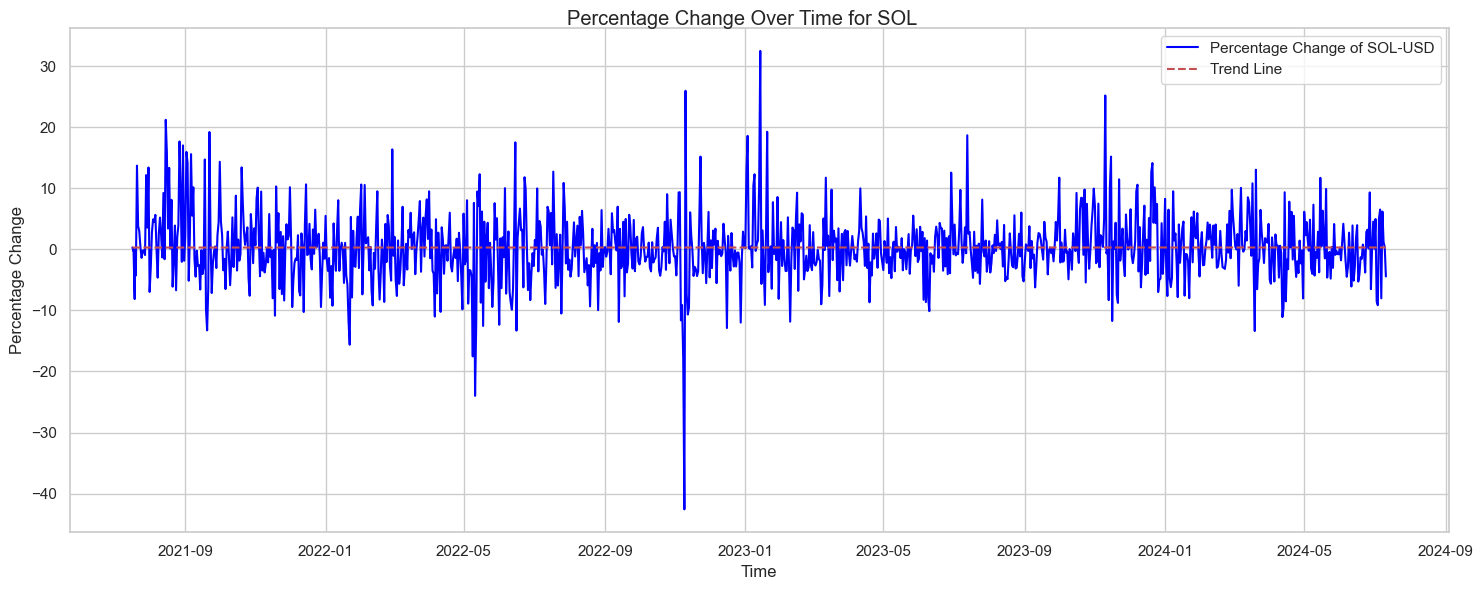

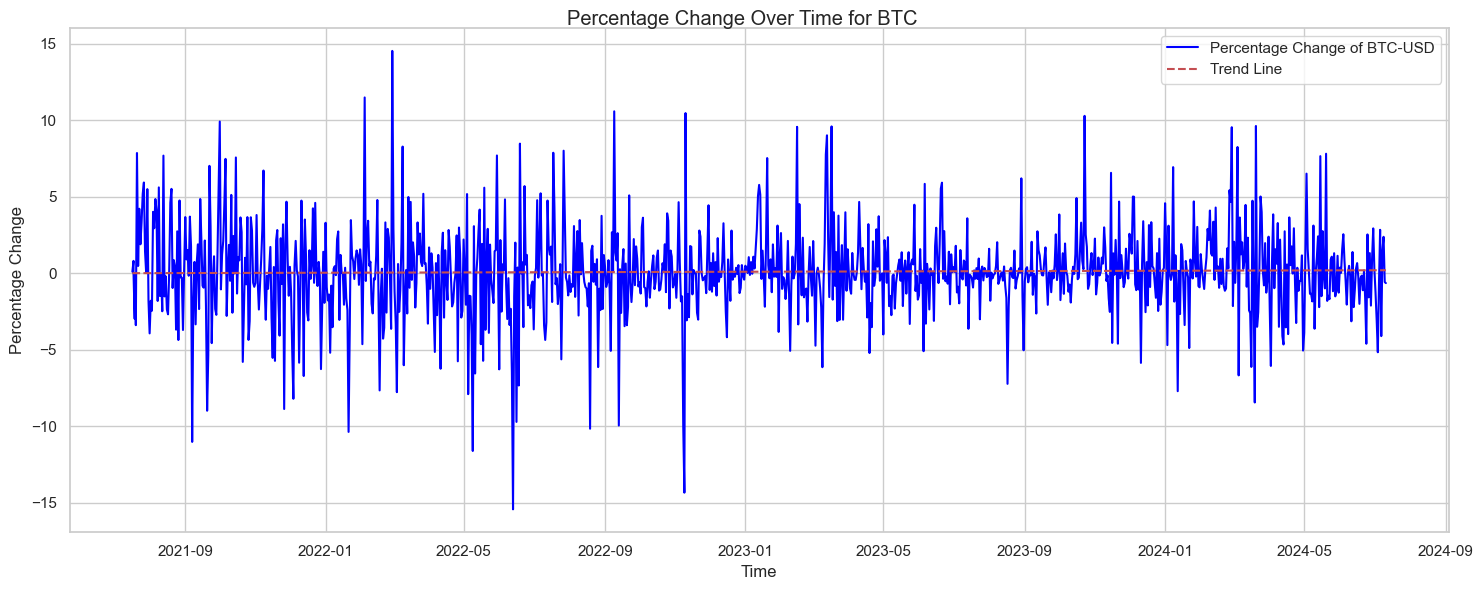

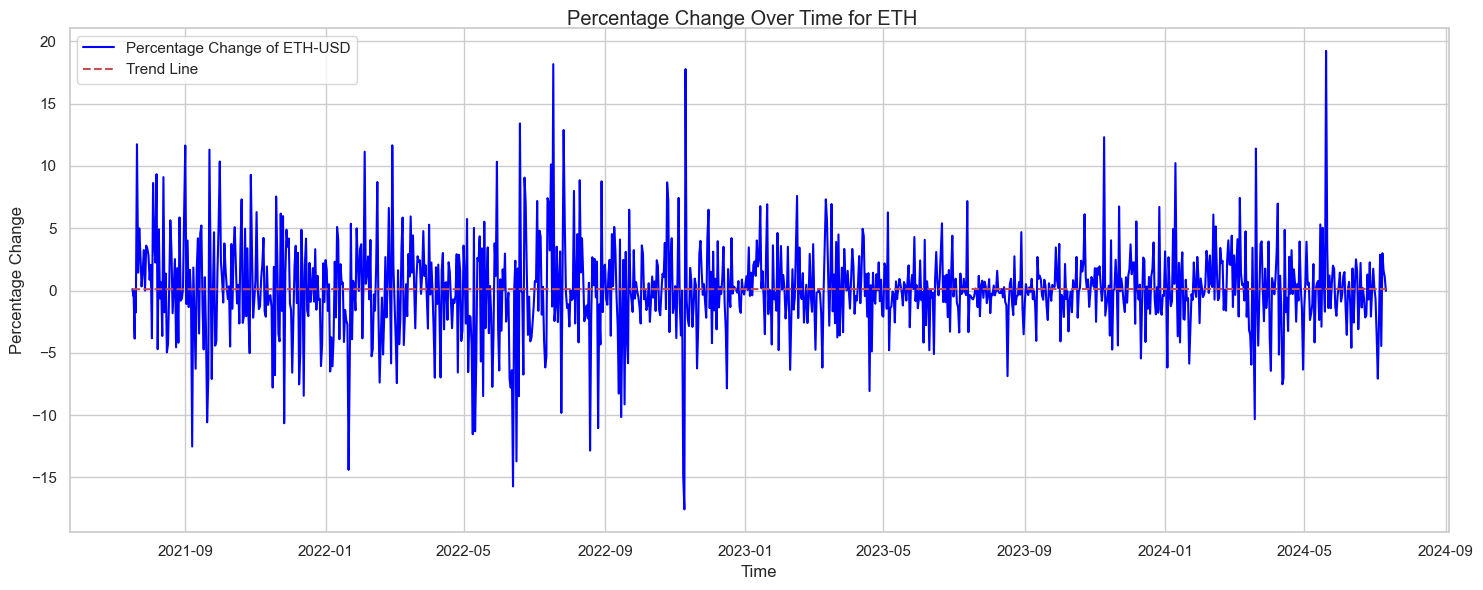

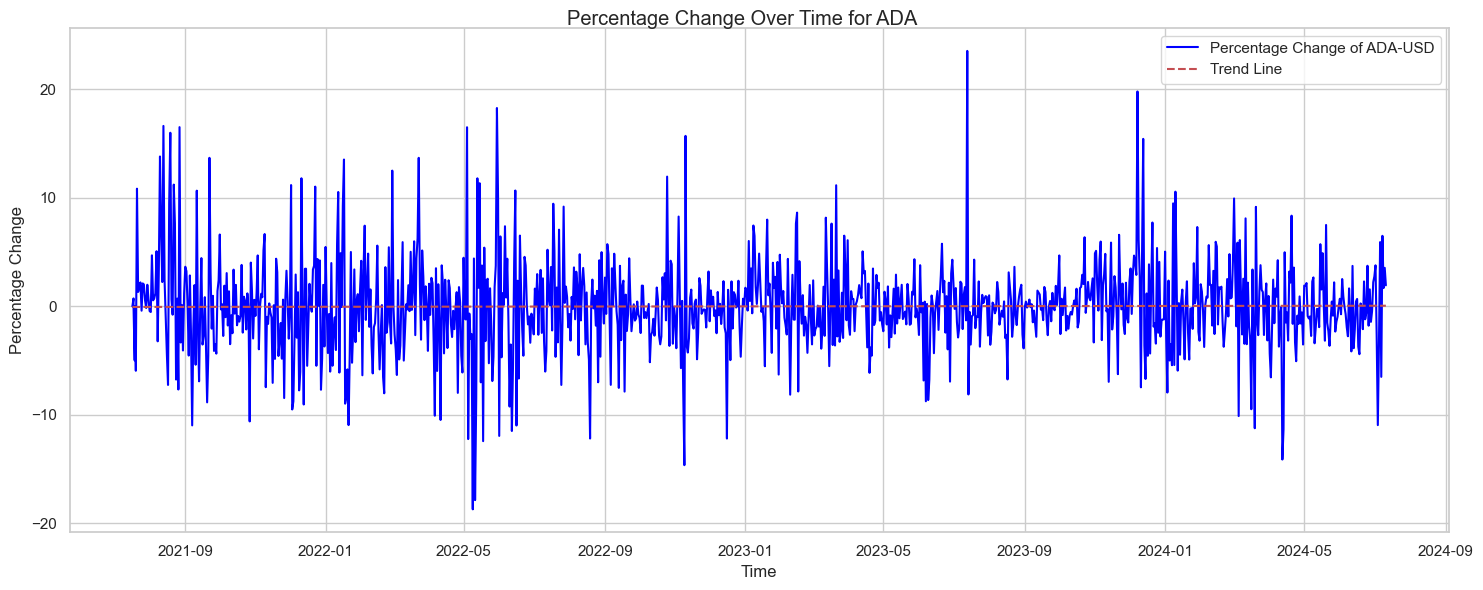

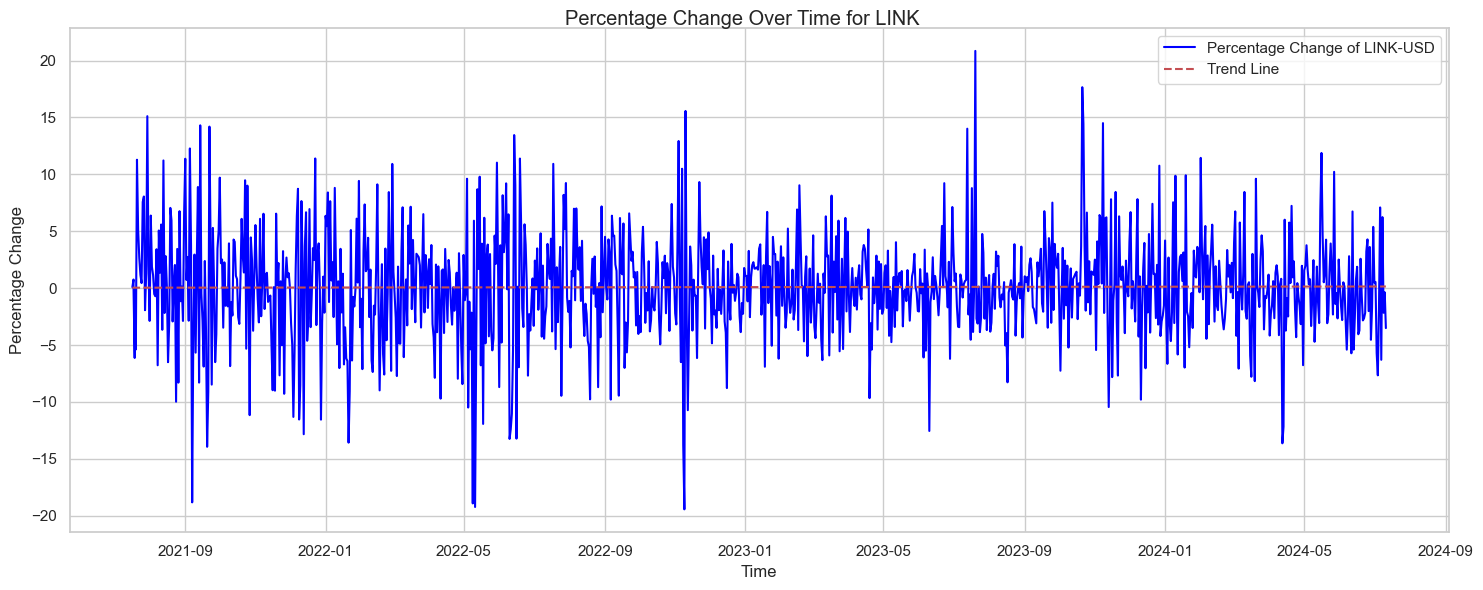

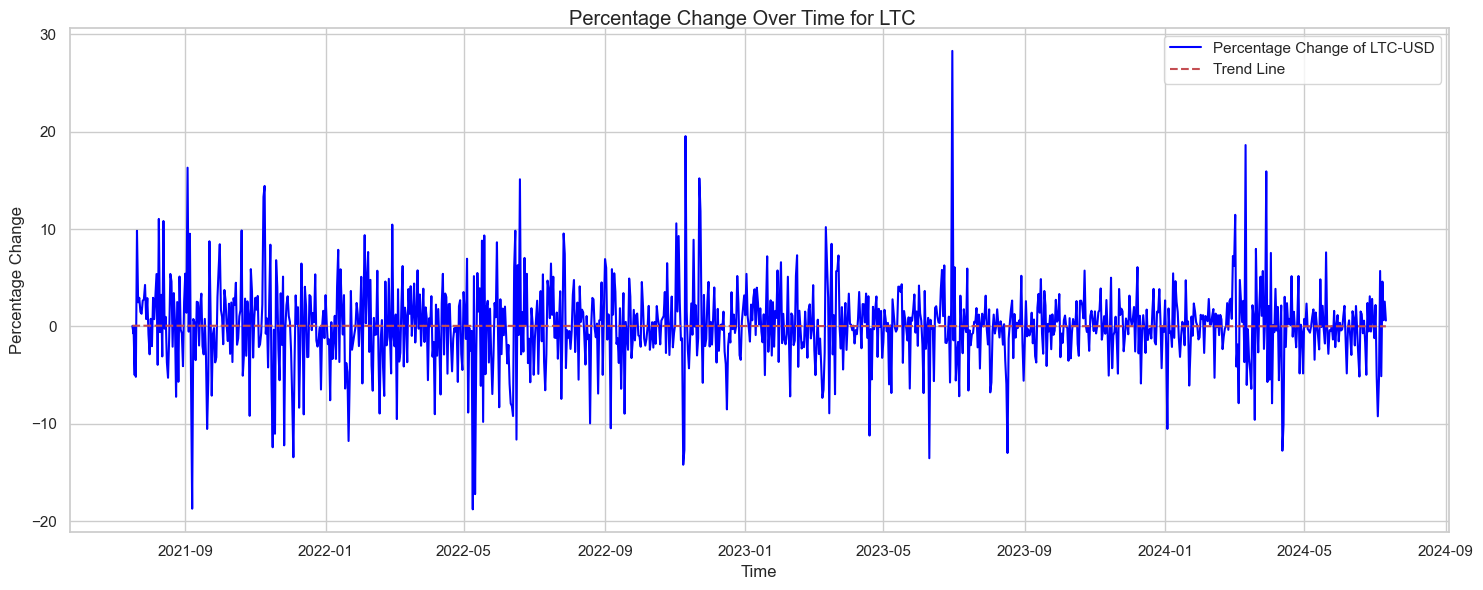

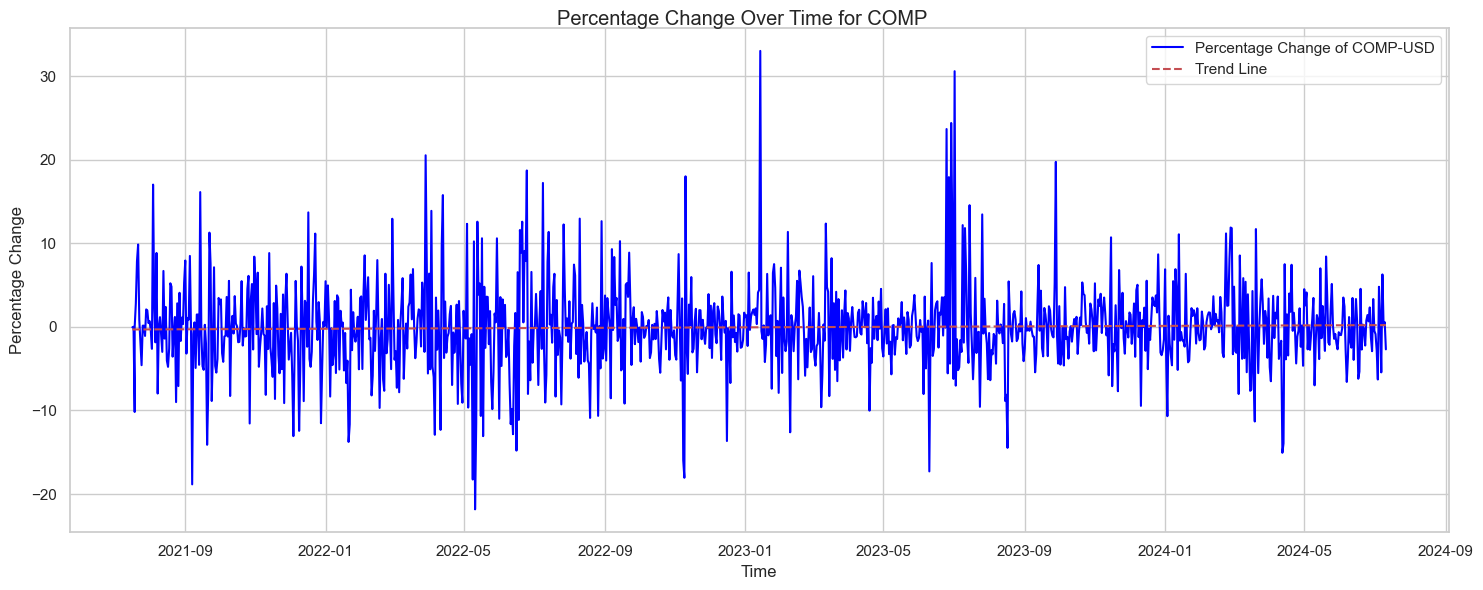

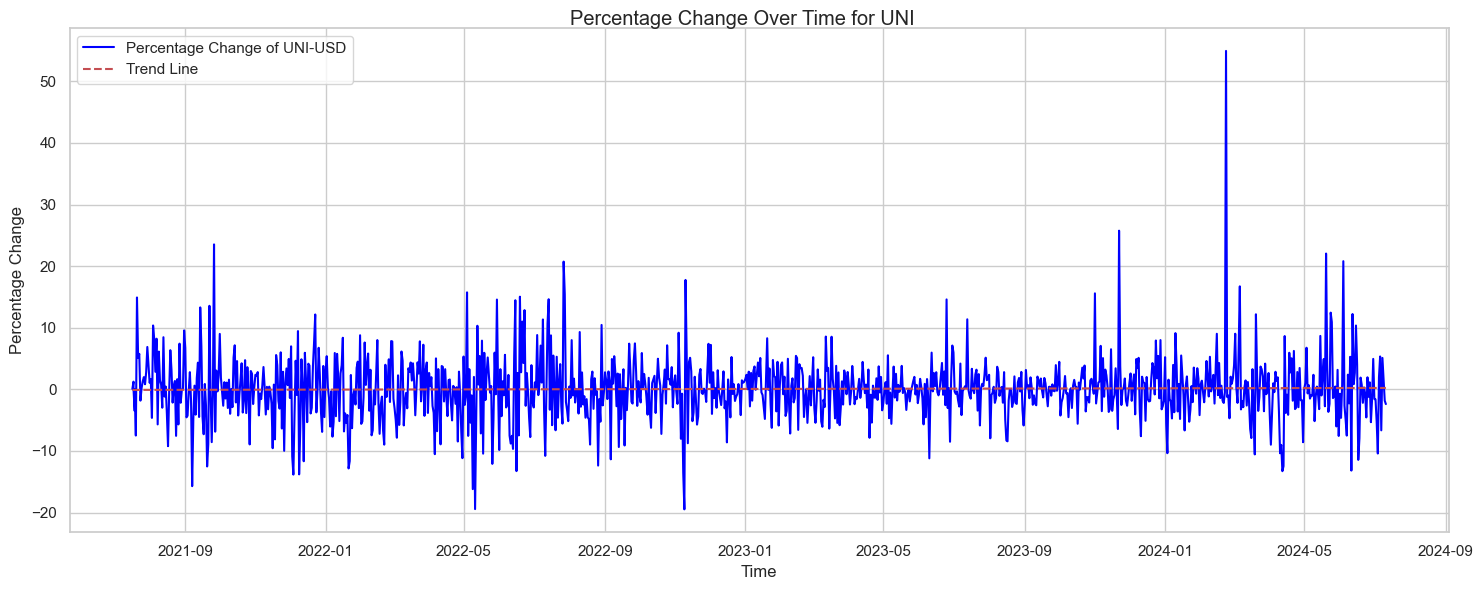

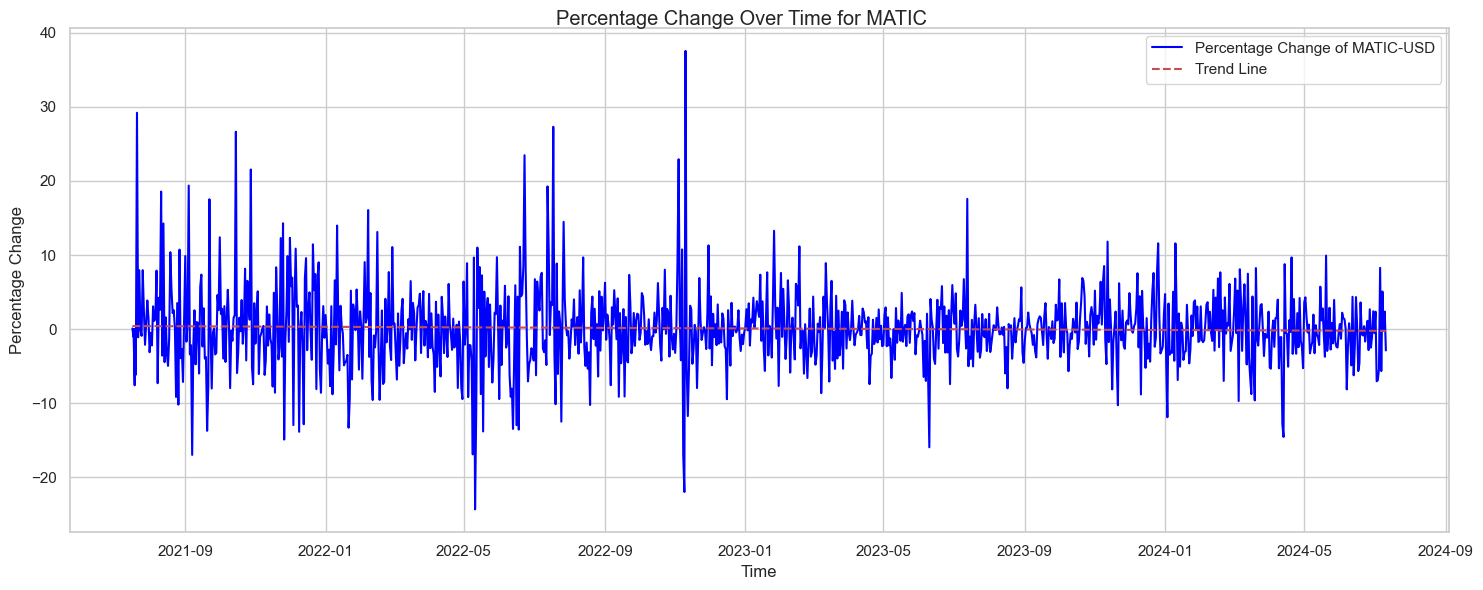

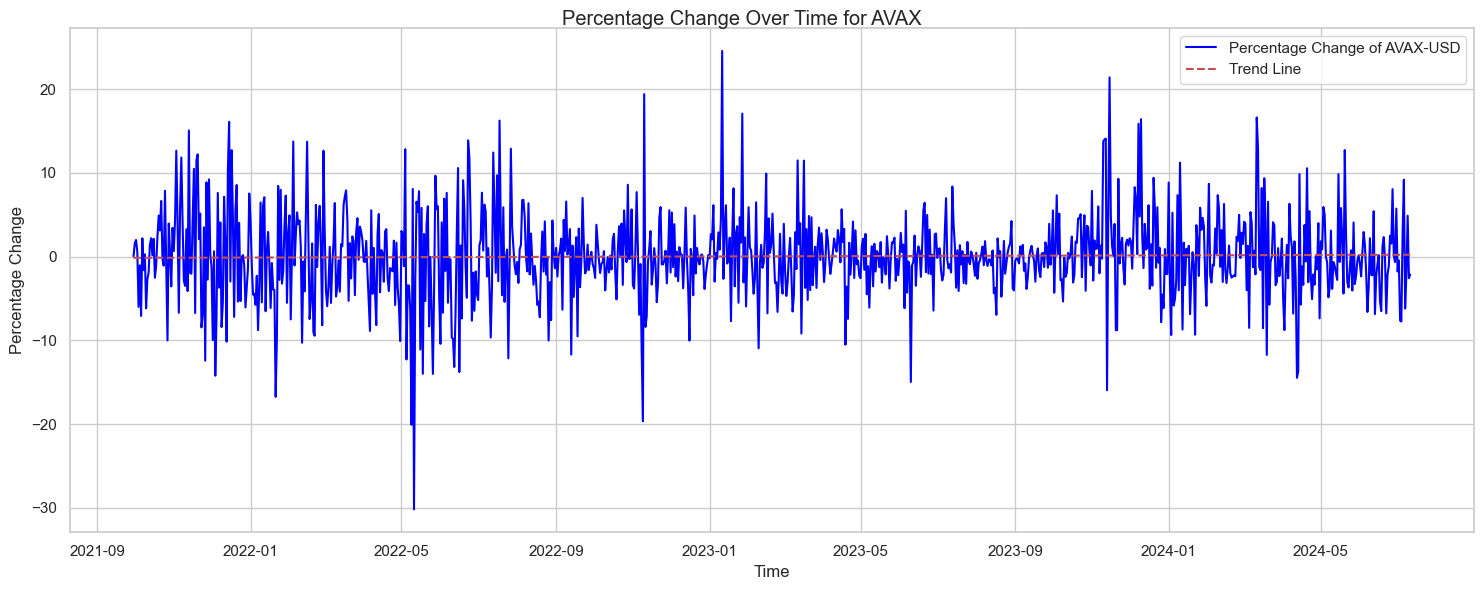

In [27]:
# Function to plot percentage change with trend lines for each unique cryptocurrency
def plotPercentageChangeWithTrend(name, data):
    unique_product_ids = data['product_id'].unique()
    fig, axs = plt.subplots(len(unique_product_ids), figsize=(15, 6 * len(unique_product_ids)), sharex=True)

    # Ensure 'axs' is always an array, even with one product_id
    axs = np.array(axs).reshape(-1)

    # Iterate over each unique cryptocurrency for plotting
    for i, (label, group_data) in enumerate(data.groupby('product_id')):
        # Ensure data for plotting is continuous and free of NaN values at the start
        df_product_nonan = group_data.dropna(subset=['pct_change'])
        
        axs[i].plot(group_data.index, group_data['pct_change'], label=f'Percentage Change of {label}', color='blue')
        
        # Only add a trend line if there are enough data points after dropping NaNs
        if len(df_product_nonan) > 1:  # ensure at least two data points are available
            valid_dates = mdates.date2num(df_product_nonan.index)  # convert dates to numerical format
            z = np.polyfit(valid_dates, df_product_nonan['pct_change'], 1)
            p = np.poly1d(z)
            axs[i].plot(df_product_nonan.index, p(valid_dates), "r--", label="Trend Line")
        
    
        axs[i].set_ylabel('Percentage Change')
        axs[i].legend()

    plt.suptitle(f'Percentage Change Over Time for {name}')
    plt.xlabel('Time')
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust the top to fit the suptitle
    plt.show()

# Example usage
for name, df in cryptos_info.items():
    plotPercentageChangeWithTrend(name, df)


In [28]:
# # Function to plot percentage change with subplots and trend lines
# def plotPercentageChangeWithTrend(name, df):
#     num_products = len(df['product_id'].unique())
#     fig, axs = plt.subplots(num_products, figsize=(15, 6 * num_products), sharex=True)

#     # Ensure 'axs' is always an array, even with one product_id
#     axs = np.array(axs).reshape(-1)

#     # Iterate over each unique cryptocurrency for plotting
#     for i, (label, df_product) in enumerate(df.groupby('product_id')):
#         # Reset index to make 'time' column accessible
#         df_product = df_product.reset_index()

#         # Ensure data for plotting is continuous and free of NaN values at the start
#         df_product_nonan = df_product.dropna(subset=['pct_change'])
        
#         axs[i].plot(df_product['time'], df_product['pct_change'], label=f'Percentage Change of {label}', color='blue')
        
#         # Only add a trend line if there are enough data points after dropping NaNs
#         if len(df_product_nonan) > 1:  # ensure at least two data points are available
#             valid_dates = mdates.date2num(df_product_nonan['time'])  # convert dates to numerical format
#             z = np.polyfit(valid_dates, df_product_nonan['pct_change'], 1)
#             p = np.poly1d(z)
#             axs[i].plot(df_product_nonan['time'], p(valid_dates), "r--", label="Trend Line")
        
#         axs[i].set_ylabel('Percentage Change')
#         axs[i].legend()

#     plt.suptitle(f'Percentage Change Over Time for {name}', fontsize=18)
#     plt.xlabel('Time')
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.95)  # Adjust the top to fit the suptitle
#     plt.show()

# # Example usage
# for name, df in cryptos_info.items():
#     plotPercentageChangeWithTrend(name, df)


<Figure size 1200x600 with 0 Axes>

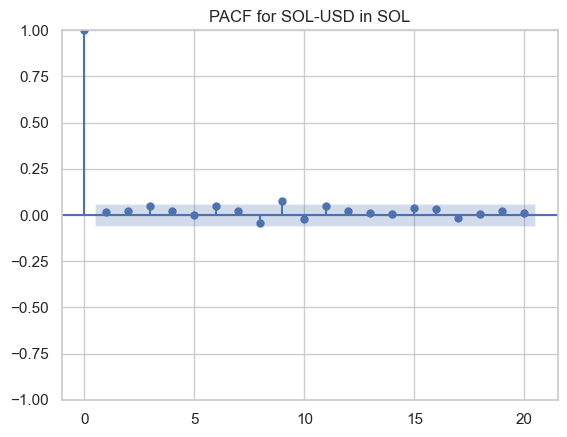

<Figure size 1200x600 with 0 Axes>

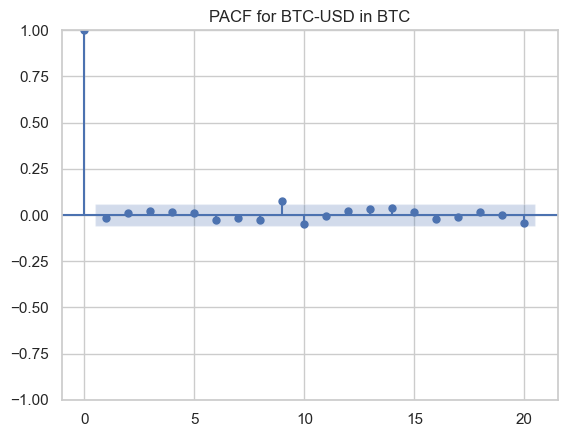

<Figure size 1200x600 with 0 Axes>

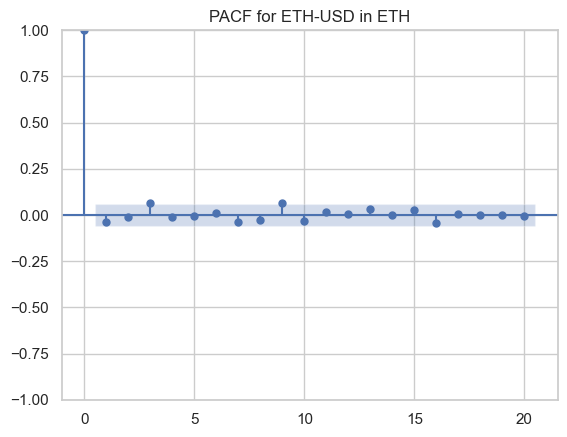

<Figure size 1200x600 with 0 Axes>

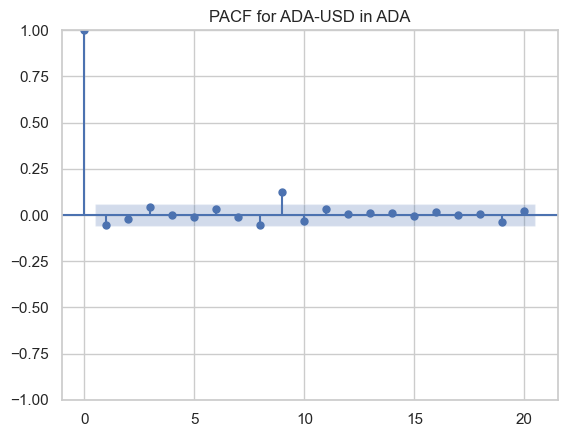

<Figure size 1200x600 with 0 Axes>

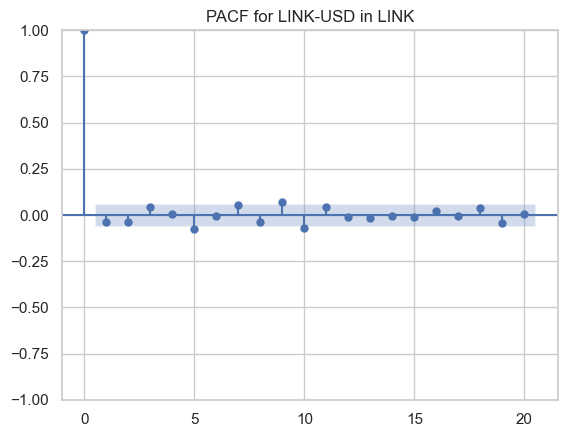

<Figure size 1200x600 with 0 Axes>

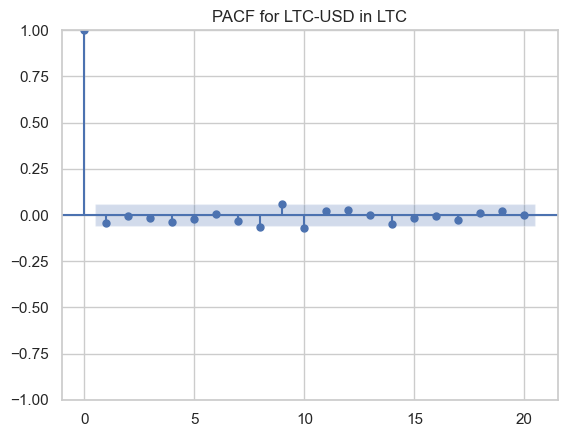

<Figure size 1200x600 with 0 Axes>

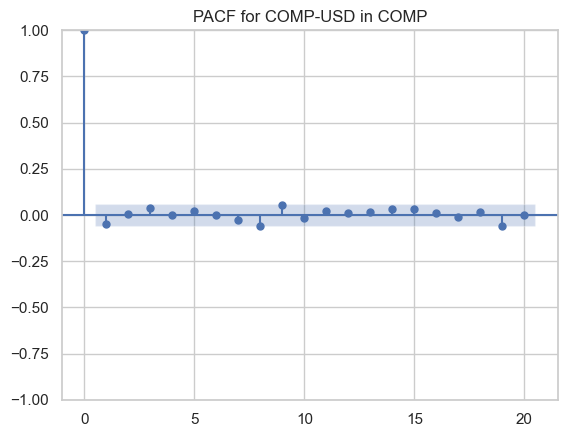

<Figure size 1200x600 with 0 Axes>

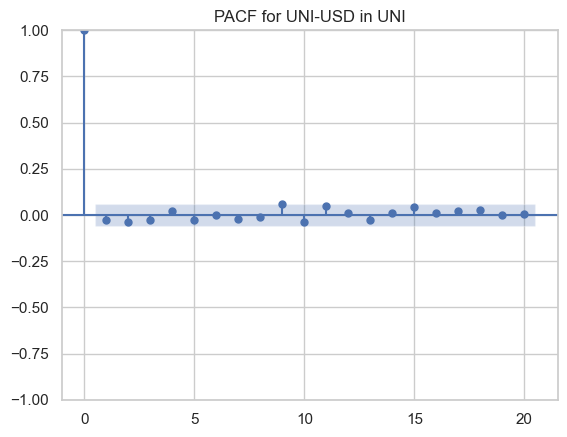

<Figure size 1200x600 with 0 Axes>

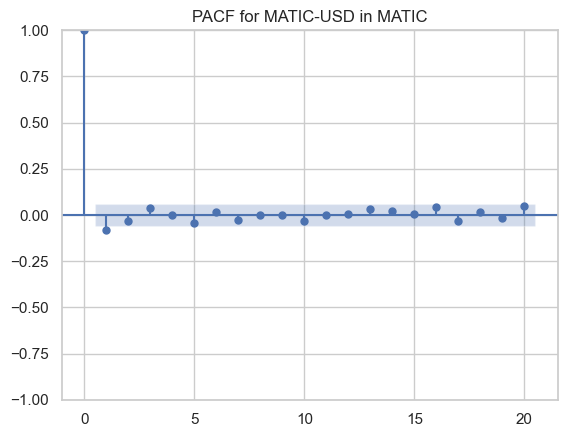

<Figure size 1200x600 with 0 Axes>

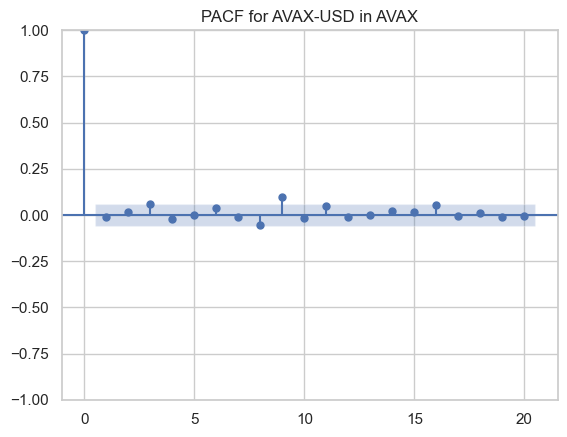

In [29]:
# Function to plot PACF
def plot_pacf_for_coin(name, data, lags=20):
    plt.figure(figsize=(12, 6))
    sm.graphics.tsa.plot_pacf(data.dropna(), lags=lags, title=f'PACF for {name}')
    plt.show()

# Iterate over each cryptocurrency
for name, df in cryptos_info.items():
    for coin in df['product_id'].unique():
        # Assuming 'pct_change' is the column of interest
        coin_data = df[df['product_id'] == coin]['pct_change']
        plot_pacf_for_coin(f'{coin} in {name}', coin_data)


In [30]:
# Function to add technical indicators for each product_id
def add_technical_indicators(group):
    group['pct_change'] = group['close'].pct_change()

    # Adding lag features for close prices and volume
    for lag in [1, 3, 7]:  # Example lags: previous day, 3 days ago, and a week ago
        group[f'close_lag_{lag}'] = group['close'].shift(lag)
        group[f'volume_lag_{lag}'] = group['volume'].shift(lag)

    # Calculate Moving Average (MA)
    group['close_MA10'] = group['close'].rolling(window=10).mean()

    # Calculate Exponential Moving Average (EMA) for different periods
    for window in [7, 14, 30]:
        group[f'close_ema_{window}'] = group['close'].ewm(span=window, adjust=False).mean()

    # Calculate Relative Strength Index (RSI)
    delta = group['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    group['RSI'] = 100 - (100 / (1 + rs))

    # Calculate Moving Average Convergence Divergence (MACD)
    exp1 = group['close'].ewm(span=12, adjust=False).mean()
    exp2 = group['close'].ewm(span=26, adjust=False).mean()
    group['MACD'] = exp1 - exp2
    group['Signal_Line'] = group['MACD'].ewm(span=9, adjust=False).mean()

    # Calculate Rolling Volatility
    for window in [7, 14, 30]:
        group[f'volatility_{window}d'] = group['pct_change'].rolling(window=window).std() * np.sqrt(window)

    # Calculate Market Momentum
    for window in [1, 7, 30]:  # momentum over 1 day, 1 week, and 1 month
        group[f'momentum_{window}d'] = group['close'] / group['close'].shift(window) - 1

    return group

In [31]:
# Apply the function to each group
# df_new = df.reset_index(drop=True)
df_new = df.groupby('product_id').apply(add_technical_indicators)

# Reset the index correctly and store it in df_new_reset
# Drop the existing 'product_id' column if it exists
if 'product_id' in df_new.columns:
    df_new = df_new.drop(columns=['product_id'])

# Drop the existing 'time' column if it exists
if 'time' in df_new.columns:
    df_new = df_new.drop(columns=['time'])
df_new_reset = df_new.reset_index(level=['product_id', 'time'])

# Ensure 'time' and 'product_id' columns exist and are in the correct format
# df_new_reset['time'] = pd.to_datetime(df_new_reset['time'])
# df_new_reset['product_id'] = df_new_reset['product_id'].astype(str)
# # df_new_reset.drop(columns=['index'], inplace = True)
df_new_reset.head()

product_id       time    low   high   open  close      volume  price_change  \
0   AVAX-USD 2021-09-30  64.68  68.05  68.05  66.73  385245.057         -1.32   
1   AVAX-USD 2021-10-01  63.29  70.06  66.74  67.79  521295.848          1.05   
2   AVAX-USD 2021-10-02  65.89  82.00  67.74  69.14  644927.008          1.40   
3   AVAX-USD 2021-10-03  67.74  72.74  69.21  69.54  381978.007          0.33   
4   AVAX-USD 2021-10-04  64.00  69.55  69.53  65.37  372626.671         -4.16   

   average_price  volatility  pct_change  close_lag_1  volume_lag_1  \
0         66.365    5.210266         NaN          NaN           NaN   
1         66.675   10.696793    0.015885        66.73    385245.057   
2         73.945   24.449841    0.019914        67.79    521295.848   
3         70.240    7.381163    0.005785        69.14    644927.008   
4         66.775    8.671875   -0.059965        69.54    381978.007   

   close_lag_3  volume_lag_3  close_lag_7  volume_lag_7  close_MA10  \
0          NaN           NaN          NaN           NaN         NaN   
1          NaN           NaN          NaN           NaN         NaN   
2          NaN           NaN          NaN           NaN         NaN   
3        66.73    385245.057          NaN           NaN         NaN   
4        67.79    521295.848          NaN           NaN         NaN   

   close_ema_7  close_ema_14  close_ema_30  RSI      MACD  Signal_Line  \
0    66.730000     66.730000     66.730000  NaN  0.000000     0.000000   
1    66.995000     66.871333     66.798387  NaN  0.084558     0.016912   
2    67.531250     67.173822     66.949459  NaN  0.257537     0.065037   
3    68.033438     67.489313     67.116591  NaN  0.422035     0.136436   
4    67.367578     67.206738     67.003907  NaN  0.213456     0.151840   

   volatility_7d  volatility_14d  volatility_30d  momentum_1d  momentum_7d  \
0            NaN             NaN             NaN          NaN          NaN   
1            NaN             NaN             NaN     0.015885          NaN   
2            NaN             NaN             NaN     0.019914          NaN   
3            NaN             NaN             NaN     0.005785          NaN   
4            NaN             NaN             NaN    -0.059965          NaN   

   momentum_30d  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN

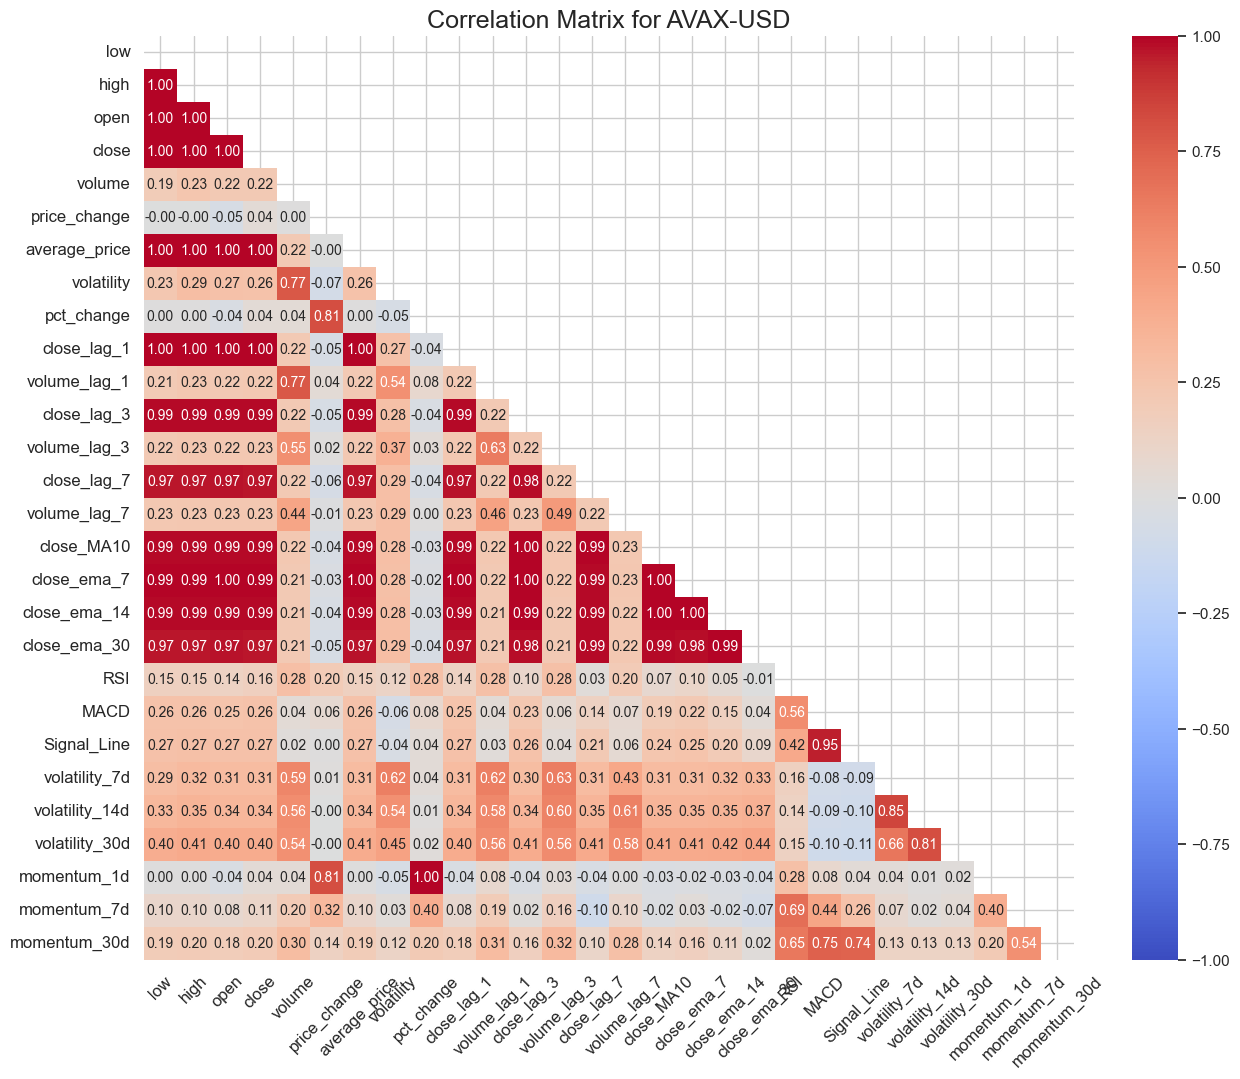

In [32]:
for coin in df_new_reset['product_id'].unique():
    plt.figure(figsize=(15, 12))  # Adjusted figure size for 30 numerical features
    coin_data = df_new_reset[df_new_reset['product_id'] == coin].select_dtypes(include=[np.number])
    corr_matrix = coin_data.corr()
    
    # Generate a heatmap with upper triangle masked
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, mask=mask, annot_kws={'fontsize': 10})  # Adjusted annotation font size
    
    plt.title(f'Correlation Matrix for {coin}', fontsize=18)  # Increased title font size
    plt.xticks(rotation=45, fontsize=12)  # Increased x-axis font size
    plt.yticks(rotation=0, fontsize=12)  # Increased y-axis font size
    plt.savefig(f'pictures/{coin}_pct_change_distribution.png')
    plt.show()

## Data Preparation

In [35]:
print(df_new_reset.columns)

Index(['product_id', 'time', 'low', 'high', 'open', 'close', 'volume',
       'price_change', 'average_price', 'volatility', 'pct_change',
       'close_lag_1', 'volume_lag_1', 'close_lag_3', 'volume_lag_3',
       'close_lag_7', 'volume_lag_7', 'close_MA10', 'close_ema_7',
       'close_ema_14', 'close_ema_30', 'RSI', 'MACD', 'Signal_Line',
       'volatility_7d', 'volatility_14d', 'volatility_30d', 'momentum_1d',
       'momentum_7d', 'momentum_30d'],
      dtype='object')


In [36]:
# Convert 'time' column to datetime
df_new_reset['time'] = pd.to_datetime(df_new_reset['time'])

# Check numeric columns for appropriate types
numeric_columns = ['low', 'high', 'open', 'close', 'volume', 'price_change', 'average_price', 
                   'volatility', 'pct_change', 'close_lag_1', 'volume_lag_1', 'close_lag_3', 
                   'volume_lag_3', 'close_lag_7', 'volume_lag_7', 'close_MA10', 'close_ema_7', 
                   'close_ema_14', 'close_ema_30', 'RSI', 'MACD', 'Signal_Line', 
                   'volatility_7d', 'volatility_14d', 'volatility_30d', 'momentum_1d', 
                   'momentum_7d', 'momentum_30d']

# Convert numeric columns to float if necessary
df_new_reset[numeric_columns] = df_new_reset[numeric_columns].astype(float)

# Ensure 'product_id' remains as object type
# If 'product_id' needs further adjustments, specify here

# Display updated dtypes to confirm changes
print(df_new_reset.dtypes)


product_id                object
time              datetime64[ns]
low                      float64
high                     float64
open                     float64
close                    float64
volume                   float64
price_change             float64
average_price            float64
volatility               float64
pct_change               float64
close_lag_1              float64
volume_lag_1             float64
close_lag_3              float64
volume_lag_3             float64
close_lag_7              float64
volume_lag_7             float64
close_MA10               float64
close_ema_7              float64
close_ema_14             float64
close_ema_30             float64
RSI                      float64
MACD                     float64
Signal_Line              float64
volatility_7d            float64
volatility_14d           float64
volatility_30d           float64
momentum_1d              float64
momentum_7d              float64
momentum_30d             float64
dtype: obj

In [38]:
# Calculate null counts and percentages for each column
null_counts = df_new_reset.isnull().sum()
null_percentages = (null_counts / len(df_new_reset)) * 100

# Combine counts and percentages into a single DataFrame
null_summary = pd.DataFrame({
    'Counts': null_counts,
    'Percentages': null_percentages
})

# Sort by percentage of null values in descending order
null_summary_sorted = null_summary.sort_values(by='Percentages', ascending=False)

# Print columns with null values sorted by highest percentage
print("Columns with null values sorted by highest percentage:")
print(null_summary_sorted)


Columns with null values sorted by highest percentage:
                Counts  Percentages
momentum_30d        30     2.952756
volatility_30d      30     2.952756
volatility_14d      14     1.377953
RSI                 13     1.279528
close_MA10           9     0.885827
volume_lag_7         7     0.688976
momentum_7d          7     0.688976
volatility_7d        7     0.688976
close_lag_7          7     0.688976
close_lag_3          3     0.295276
volume_lag_3         3     0.295276
close_lag_1          1     0.098425
volume_lag_1         1     0.098425
momentum_1d          1     0.098425
pct_change           1     0.098425
volatility           0     0.000000
MACD                 0     0.000000
low                  0     0.000000
high                 0     0.000000
open                 0     0.000000
close                0     0.000000
Signal_Line          0     0.000000
close_ema_14         0     0.000000
volume               0     0.000000
close_ema_30         0     0.000000
close_ema

In [40]:
# Columns to drop
columns_to_drop = [
    'average_price', 'close_lag_1', 'close_lag_3', 'close_lag_7',
    'open', 'high', 'price_change'
]

# Drop the specified columns
df_new_reset.drop(columns=columns_to_drop, inplace=True)


Features to drop due to high correlation in AVAX-USD (>0.8): ['close_ema_30', 'volatility_14d', 'momentum_1d', 'close', 'close_ema_14', 'close_ema_7', 'Signal_Line', 'volatility_30d', 'close_MA10']


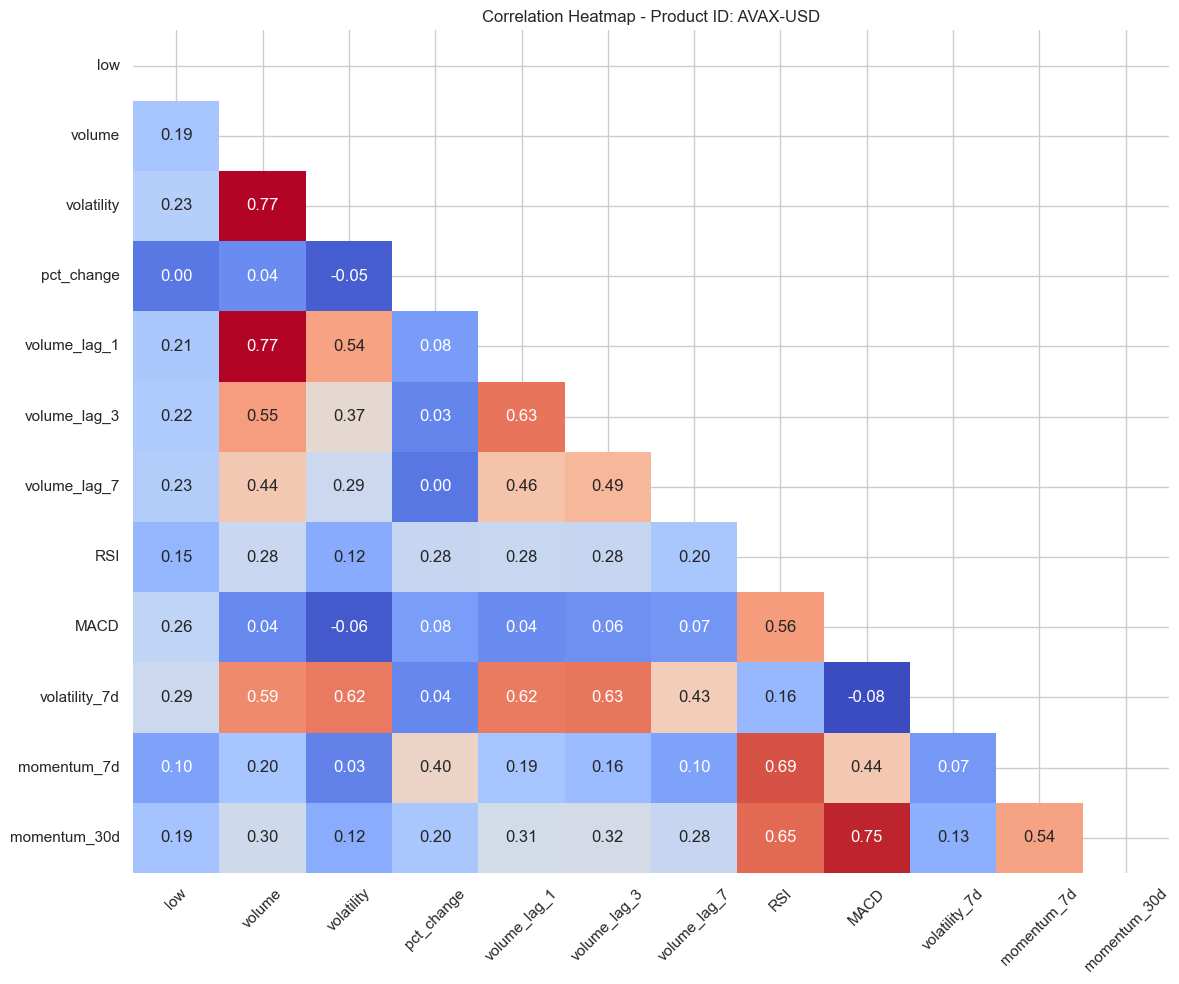

In [41]:
# Function to filter out highly correlated features
def filter_high_correlation(corr_matrix, threshold=0.80):
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                to_drop.add(corr_matrix.columns[i])
    return list(to_drop)

# Group by 'product_id'
grouped = df_new_reset.groupby('product_id')

# Iterate over each group and plot correlation matrix
for i, (product_id, group) in enumerate(grouped):
    if i >= 10:
        break

    # Initial computation of correlations
    numeric_columns = group.select_dtypes(include=['float64', 'int64']).columns
    corr = group[numeric_columns].corr()

    # Filter out highly correlated features and drop them
    high_corr_features = filter_high_correlation(corr, threshold=0.80)
    print(f"Features to drop due to high correlation in {product_id} (>{0.80}): {high_corr_features}")

    # Drop the highly correlated features
    group = group.drop(columns=high_corr_features)

    # Recompute correlations after dropping
    numeric_columns = group.select_dtypes(include=['float64', 'int64']).columns
    corr = group[numeric_columns].corr()

    # Create a mask to display only the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Initialize a figure with larger size
    plt.figure(figsize=(12, 10))

    # Plot the heatmap
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', mask=mask, cbar=False)

    # Customize plot
    plt.title(f'Correlation Heatmap - Product ID: {product_id}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Show plot
    plt.tight_layout()
    plt.show()


### Handling Missing Values

In [42]:
# Handle missing values in numerical columns
def impute_numerical(group):
    # Forward fill
    group = group.ffill()
    # Backward fill
    group = group.bfill()
    # Linear interpolation
    group = group.interpolate(method='linear')
    return group

# Handle missing values in categorical columns
def impute_categorical(group):
    # Forward fill for categorical columns
    return group.ffill()

# Group by 'product_id' and apply imputation functions
for product_id, group in df_new_reset.groupby('product_id'):
    # Impute numerical columns
    df_new_reset.loc[group.index, group.select_dtypes(include=['float64', 'int64']).columns] = impute_numerical(
        group.select_dtypes(include=['float64', 'int64'])
    )
    # Impute categorical columns
    df_new_reset.loc[group.index, group.select_dtypes(include=['object']).columns] = impute_categorical(
        group.select_dtypes(include=['object'])
    )

# Validate after imputation
print("Null values after imputation:")
print(df_new_reset.isnull().sum())


Null values after imputation:
product_id        0
time              0
low               0
close             0
volume            0
volatility        0
pct_change        0
volume_lag_1      0
volume_lag_3      0
volume_lag_7      0
close_MA10        0
close_ema_7       0
close_ema_14      0
close_ema_30      0
RSI               0
MACD              0
Signal_Line       0
volatility_7d     0
volatility_14d    0
volatility_30d    0
momentum_1d       0
momentum_7d       0
momentum_30d      0
dtype: int64


In [ ]:
#df_new_reset.to_csv('Cleaned_Data/cleaned_crypto_updated_module5.csv')